In [26]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
from scipy.integrate import simpson
import time

def ode(z, y):
    f = y[0] # y1 = f
    df_dz = y[1] # y2 = df/dz
    dy2_dz = -K_sqr * (7/2 * f)**(-3/7)
    return np.array([df_dz, dy2_dz])

def BC(ya, yb):
    return np.array([yb[0] - f_Z, ya[1] - df0_dz])

@nb.jit
def ini_guess(f_t, z_arr, Lz):
    guess_arr = np.ones((2, z_arr.size))
    guess_arr[0, :] = f_t + heat_flux / a * (Lz - z_arr)
    guess_arr[1, :] = heat_flux / (-a)
    return guess_arr

#@nb.jit
def integration(x, y):
    delta_x = np.diff(x)
    #return np.trapz(y, delta_x)
    #return simpson(y = y, x = delta_x) # Slower
    return np.sum((y[:-1] + y[1:]) / 2 * delta_x)

epsilon0 = 8.8541878188e-12
me = 9.1093837015e-31
coulomb_log = 13
a = 9.6 * ((2 * np.pi)**(3/2) * epsilon0**2) / (me**(1/2) * e**(1/2) * coulomb_log) # [W/m eV^-7/2]

Lz = 50.0 # [m]
m = 1.67e-27# [kg] 
gamma_hat = 7.0 * np.sqrt(2/m)
e = 1.60218e-19 # [C]
heat_flux = 1e7 # [W/m2]

N = int(1e2)
z_arr = np.linspace(0, Lz, int(1e3))
K_sqr = 0
Tt_0 = np.logspace(0, 3, N)
ft_0 = (2/7) * Tt_0**(7/2)
Tu_0 = np.zeros(N)
qt_0 = np.zeros(N)
nt_0 = np.zeros(N)
nu_0 = np.zeros(N)
fu_0 = np.zeros(N)

start_time = time.time()
for index in range(N):
    f_Z = 2/7 * Tt_0[index]**(7/2) # f(Z) = f(T_t)
    df0_dz = heat_flux / (-a) # df(Z)/dz = f(q_u)
    y_ini = ini_guess(f_Z, z_arr, Lz)
    solution = solve_bvp(ode, BC, z_arr, y_ini, max_nodes = 1e6, tol = 1e-6)
    fu_0[index] = solution.y[0][0]
    Tu_0[index] = (7/2 * solution.y[0][0])**(2/7)
    qt_0[index] = np.sqrt(K_sqr * a**2 * (Tu_0[index]**2 - Tt_0[index]**2) + heat_flux**2)
    nt_0[index] = qt_0[index] / (gamma_hat * (e * Tt_0[index])**(3/2) * 1e18)
nu_arr = 2*nt_0*Tt_0/Tu_0
end_time = time.time()
print(f'Standard model calculation time = {(end_time - start_time):.6f} s')

N = int(1e2)
K_sqr = 1e6
z_arr = np.linspace(0, Lz, int(1e4))
Tt_arr = np.logspace(0, 3, N)
ft_arr = (2/7) * Tt_arr**(7/2)
delta_z = np.diff(z_arr)
T_arr = np.zeros(N)
R_arr = np.zeros(N)
Tu_arr = np.zeros(N)
qt_arr = np.zeros(N)
nt_arr = np.zeros(N)
nu_arr = np.zeros(N)
fu_arr = np.zeros(N)

start_time = time.time()
for index in range(N):
    f_Z = 2/7 * Tt_arr[index]**(7/2) # f(Z) = f(T_t)
    df0_dz = heat_flux / (-a) # df(Z)/dz = f(q_u)
    y_ini = ini_guess(f_Z, z_arr, Lz)
    solution = solve_bvp(ode, BC, z_arr, y_ini, max_nodes = 1e6, tol = 1e-3)
    z_arr = np.linspace(0, Lz, solution.x.size)
    R_arr[index] = integration(z_arr, ((7/2 * solution.y[0])**(2/7))**(-3/2))
    fu_arr[index] = solution.y[0][0]
    Tu_arr[index] = (7/2 * solution.y[0][0])**(2/7)
    qt_arr[index] = np.sqrt(K_sqr * a**2 * (Tu_arr[index]**2 - Tt_arr[index]**2) + heat_flux**2)
    nt_arr[index] = qt_arr[index] / (gamma_hat * (e * Tt_arr[index])**(3/2) * 1e18)
nu_arr = 2*nt_arr*Tt_arr/Tu_arr
end_time = time.time()
print(f'Numerical solution calculation time = {(end_time - start_time):.6f} s')

sigma_hat = a * 0.6125
deltaq_arr = qt_arr - heat_flux
R_arr = R_arr / sigma_hat

Standard model calculation time = 0.694515 s
Numerical solution calculation time = 453.988252 s


[0.55522072]
[0.55522008]


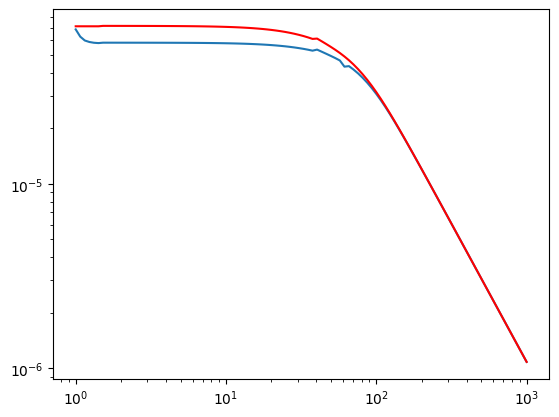

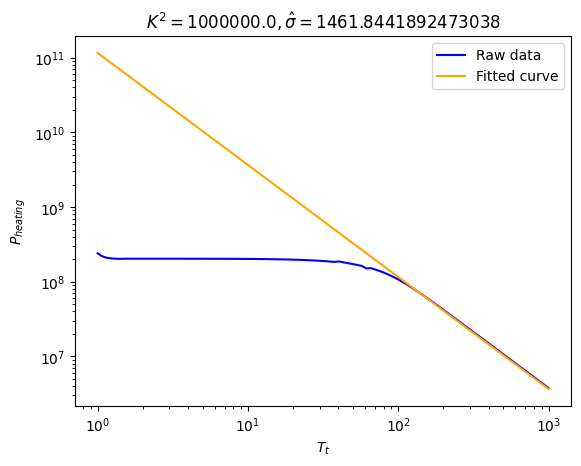

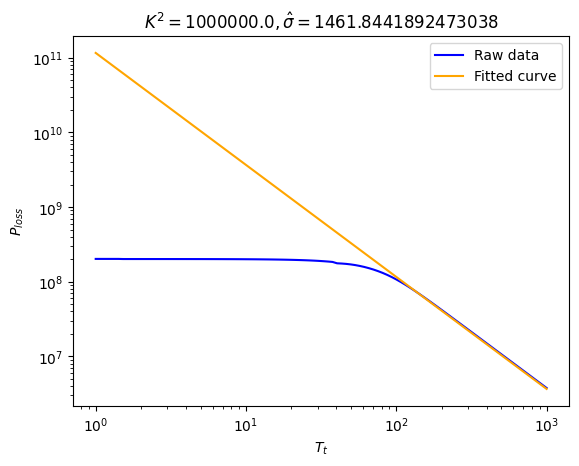

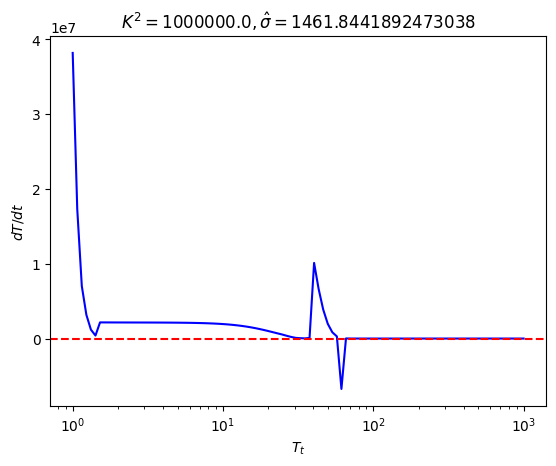

In [27]:
from scipy.optimize import curve_fit

def func(x, C1):
    return C1 * Constan1 * x**(-3/2)

R_arr_apx = 7/4 * Lz / sigma_hat * (Tu_arr**2 - Tt_arr**2) / (Tu_arr**(7/2) - Tt_arr**(7/2))

j = np.sqrt(K_sqr * a * sigma_hat)
voltage = R_arr * j

plt.figure()
plt.loglog(Tt_arr, R_arr)
plt.loglog(Tt_arr, R_arr_apx, color = 'r')

Constan1 = K_sqr*7/4*a*Lz


x = Tt_arr
y = voltage**2/R_arr
params, params_covariance = curve_fit(func, x[68:-1], y[68:-1], p0 = 1, maxfev=int(1e9), ftol=1e-15, xtol=1e-15)
print(params)
plt.figure()
plt.title(f'$K^2 = {K_sqr}, \hat\sigma = {sigma_hat}$')
plt.xlabel('$T_t$')
plt.ylabel('$P_{heating}$')
plt.loglog(x, y, color = 'b', label = 'Raw data')
#plt.loglog(x, func(x, 0.6), label=f"Guess curve", color='r')
plt.loglog(x, func(x, params), label=f"Fitted curve", color='orange')
#plt.xlim(1, 1e3)
plt.legend()

x = Tt_arr
y = deltaq_arr
params, params_covariance = curve_fit(func, x[68:-1], y[68:-1], p0 = 1, maxfev=int(1e9), ftol=1e-15, xtol=1e-15)
print(params)
plt.figure()
plt.title(f'$K^2 = {K_sqr}, \hat\sigma = {sigma_hat}$')
plt.xlabel('$T_t$')
plt.ylabel('$P_{loss}$')
plt.loglog(x, y, color = 'b', label = 'Raw data')
#plt.loglog(x, func(x, 0.6), label=f"Guess curve", color='r')
plt.loglog(x, func(x, params), label=f"Fitted curve", color='orange')
#plt.xlim(1, 1e3)
plt.legend()

dQ_dt = (voltage**2/R_arr - deltaq_arr)
plt.figure()
plt.title(f'$K^2 = {K_sqr}, \hat\sigma = {sigma_hat}$')
plt.xlabel('$T_t$')
plt.ylabel('$dT/dt$')
plt.semilogx(Tt_arr, dQ_dt, color = 'b')
plt.axhline(0, color='r', linestyle='--')
#plt.xlim(1, 1e3)

#plt.figure()
#plt.title(f'$K^2 = {K_sqr}, \hat\sigma = {sigma_hat}$')
#plt.xlabel('$T_u$')
#plt.ylabel('$dT/dt$')
#plt.semilogx(Tu_arr, dT_dt, color = 'b')
#plt.grid()
#plt.xlim(1, 1e3)

1867875.9883828792
T_t =  70.54802310718645
T_u =  97.5575010480838
114.97569953977356
[0.54987961]
[0.8603483]


(1, 100.0)

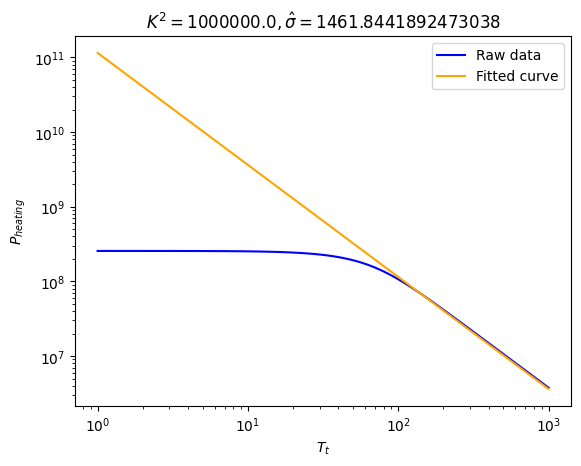

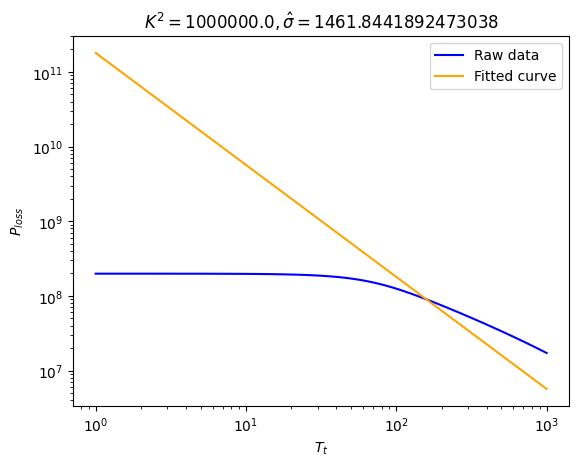

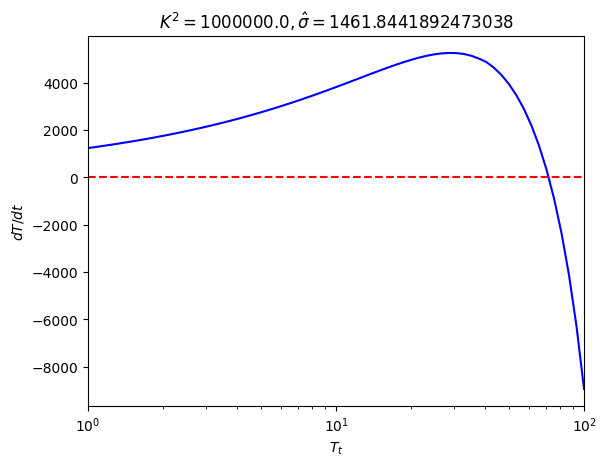

In [28]:
from scipy.special import gamma as gamma_func
from scipy.optimize import curve_fit

def func(x, C1):
    return C1 * Constan1 * x**(-3/2)

Tt = Tt_arr
varpi = gamma_func(1/4)**2 / (2 * np.sqrt(2*np.pi)) #3/5 * np.pi/varpi = 0.72
Tu = (Tt**(7/2) + ((7/2 * heat_flux * Lz/a)**(10/7) + (K_sqr * Lz**2 / (3/5 * np.pi/varpi)**2))**(7/10))**(2/7)
#Tu = (Tt**(7/2) + (7/2 * heat_flux * Lz/a) + (np.sqrt(K_sqr) * Lz / (3/5 * np.pi/varpi))**(7/5) )**(2/7)
qt = np.sqrt(K_sqr * a**2 * (Tu**2 - Tt**2) + heat_flux**2)
nt = qt / (gamma_hat * (e * Tt)**(3/2) * 1e18)
nu = 2*nt*Tt/Tu

sigma_hat = 0.6125 * a
deltaq = qt - heat_flux
R = 7/4 * Lz / sigma_hat * (Tu**2 - Tt**2) / (Tu**(7/2) - Tt**(7/2))
j = np.sqrt(K_sqr * a * sigma_hat)
print(j)
voltage = R * j

dT_dt_simple = (voltage**2/R - deltaq)/ (3 * nu_arr * Lz)
print('T_t = ', Tt[np.argmin(abs(dT_dt_simple))])
print('T_u = ', Tu[np.argmin(abs(dT_dt_simple))])

Constan1 = K_sqr*7/4*a*Lz

print(Tt_arr[68])
x = Tt
y = voltage**2/R
params, params_covariance = curve_fit(func, x[68:-1], y[68:-1], p0 = 1, maxfev=int(1e9), ftol=1e-15, xtol=1e-15)
print(params)
plt.figure()
plt.title(f'$K^2 = {K_sqr}, \hat\sigma = {sigma_hat}$')
plt.xlabel('$T_t$')
plt.ylabel('$P_{heating}$')
plt.loglog(x, y, color = 'b', label = 'Raw data')
#plt.loglog(x, func(x, 0.6), label=f"Guess curve", color='r')
plt.loglog(x, func(x, params), label=f"Fitted curve", color='orange')
#plt.xlim(1, 1e3)
plt.legend()

x = Tt
y = deltaq
params, params_covariance = curve_fit(func, x[68:-1], y[68:-1], p0 = 1, maxfev=int(1e9), ftol=1e-15, xtol=1e-15)
print(params)
plt.figure()
plt.title(f'$K^2 = {K_sqr}, \hat\sigma = {sigma_hat}$')
plt.xlabel('$T_t$')
plt.ylabel('$P_{loss}$')
plt.loglog(x, y, color = 'b', label = 'Raw data')
#plt.loglog(x, func(x, 0.6), label=f"Guess curve", color='r')
plt.loglog(x, func(x, params), label=f"Fitted curve", color='orange')
#plt.xlim(1, 1e3)
plt.legend()
plt.figure()
plt.title(f'$K^2 = {K_sqr}, \hat\sigma = {sigma_hat}$')
plt.xlabel('$T_t$')
plt.ylabel('$dT/dt$')
plt.semilogx(Tt[0:67], dT_dt_simple[0:67], color = 'b')
plt.axhline(0, color='r', linestyle='--')
plt.xlim(1, 1e2)

#plt.figure()
#plt.title(f'$K^2 = {K_sqr}, \hat\sigma = {sigma_hat}$')
#plt.xlabel('$T_u$')
#plt.ylabel('$dT/dt$')
#plt.semilogx(Tu, dT_dt_simple, color = 'b')
#plt.grid()
#plt.xlim(1, 1e3)

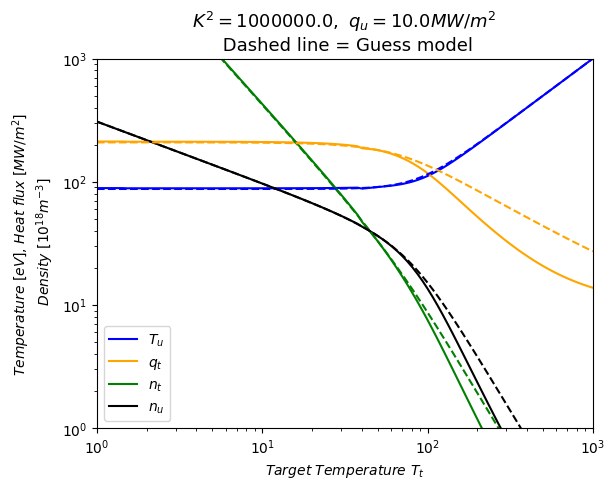

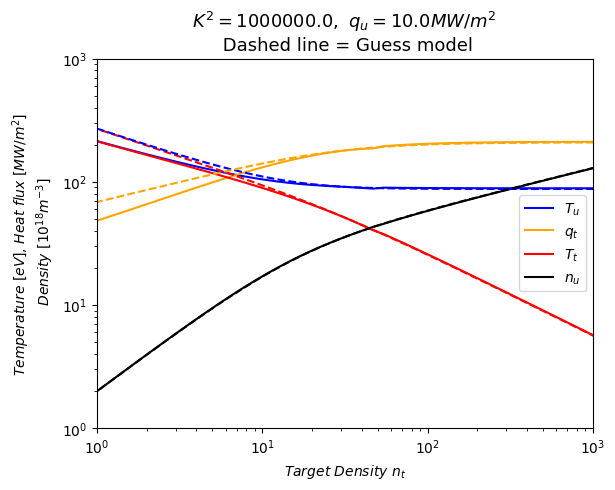

In [29]:
plt.figure()
plt.title(f'$K^2 = {K_sqr},\ q_u = {heat_flux/1e6} MW/m^2$ \n Dashed line = Guess model', fontsize = 13)
plt.loglog(Tt_arr, Tu_arr, color = 'b', label = '$T_u$')
plt.loglog(Tt_arr, qt_arr/1e6, color = 'orange', label = '$q_t$')
plt.loglog(Tt_arr, nt_arr, color = 'g', label = '$n_t$')
plt.loglog(Tt_arr, nu_arr, color = 'black', label = '$n_u$')

plt.loglog(Tt, nt, color = 'g', linestyle = '--')
plt.loglog(Tt, Tu, color = 'b', linestyle = '--')
plt.loglog(Tt, nu, color = 'black', linestyle = '--')
plt.loglog(Tt, qt/1e6, color = 'orange', linestyle = '--')
plt.xlabel('$Target\ Temperature\ T_t$', fontsize = 10)
plt.ylabel('$Temperature\ [eV]$, $Heat\ flux\ [MW/m^2]$ \n $Density\ [10^{18}m^{-3}]$', fontsize = 10)
plt.legend(fontsize = 10)
plt.ylim(1, 1e3)
plt.xlim(1, 1e3)
plt.show()

plt.figure()
plt.title(f'$K^2 = {K_sqr},\ q_u = {heat_flux/1e6} MW/m^2$ \n Dashed line = Guess model', fontsize = 13)
plt.loglog(nt_arr, Tu_arr, color = 'b', label = '$T_u$')
plt.loglog(nt_arr, qt_arr/1e6, color = 'orange', label = '$q_t$')
plt.loglog(nt_arr, Tt_arr, color = 'r', label = '$T_t$')
plt.loglog(nt_arr, nu_arr, color = 'black', label = '$n_u$')
plt.loglog(nt, Tt, color = 'r', linestyle = '--')
plt.loglog(nt, Tu, color = 'b', linestyle = '--')
plt.loglog(nt, nu, color = 'black', linestyle = '--')
plt.loglog(nt, qt/1e6, color = 'orange', linestyle = '--')
plt.ylabel('$Temperature\ [eV]$, $Heat\ flux\ [MW/m^2]$ \n $Density\ [10^{18}m^{-3}]$', fontsize = 10)
plt.xlabel('$Target\ Density\ n_t$', fontsize = 10)
plt.legend(fontsize = 10)
plt.ylim(1, 1e3)
plt.xlim(1, 1e3)
plt.show()

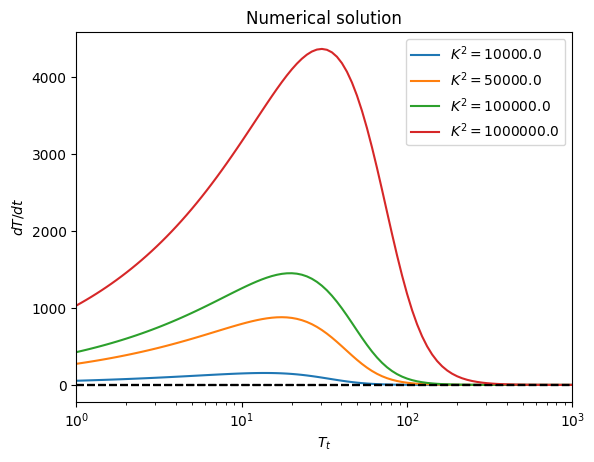

In [30]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
import time

def ode(z, y):
    f = y[0] # y1 = f
    df_dz = y[1] # y2 = df/dz
    dy2_dz = -K_sqr * (7/2 * f)**(-3/7)
    return np.array([df_dz, dy2_dz])

def BC(ya, yb):
    return np.array([yb[0] - f_Z, ya[1] - df0_dz])

@nb.jit
def ini_guess(f_t, z_arr, Lz):
    guess_arr = np.ones((2, z_arr.size))
    guess_arr[0, :] = f_t + heat_flux / a * (Lz - z_arr)
    guess_arr[1, :] = heat_flux / (-a)
    return guess_arr

epsilon0 = 8.8541878188e-12
me = 9.1093837015e-31
coulomb_log = 13
a = 9.6 * ((2 * np.pi)**(3/2) * epsilon0**2) / (me**(1/2) * e**(1/2) * coulomb_log) # [W/m eV^-7/2]
Lz = 50.0 # [m]
m = 1.67e-27# [kg] 
gamma_hat = 7.0 * np.sqrt(2/m)
e = 1.60218e-19 # [C]
heat_flux = 1e7 # [W/m2]

N = int(1e2)
K_vals = np.array([1e4, 5e4, 1e5, 1e6])
Tt_arr = np.logspace(0, 3, N)
dT_dt = np.zeros((4, N))
for k in range(4):
    K_sqr = K_vals[k]
    z_arr = np.linspace(0, Lz, int(1e2))
    ft_arr = (2/7) * Tt_arr**(7/2)
    Tu_arr = np.zeros(N)
    qt_arr = np.zeros(N)
    nt_arr = np.zeros(N)
    nu_arr = np.zeros(N)
    fu_arr = np.zeros(N)

    for index in range(N):
        f_Z = 2/7 * Tt_arr[index]**(7/2) # f(Z) = f(T_t)
        df0_dz = heat_flux / (-a) # df(Z)/dz = f(q_u)
        y_ini = ini_guess(f_Z, z_arr, Lz)
        solution = solve_bvp(ode, BC, z_arr, y_ini, max_nodes = 1e6, tol = 1e-4)
        fu_arr[index] = solution.y[0][0]
        Tu_arr[index] = (7/2 * solution.y[0][0])**(2/7)
        qt_arr[index] = np.sqrt(K_sqr * a**2 * (Tu_arr[index]**2 - Tt_arr[index]**2) + heat_flux**2)
        nt_arr[index] = qt_arr[index] / (gamma_hat * (e * Tt_arr[index])**(3/2) * 1e18)
    nu_arr = 2*nt_arr*Tt_arr/Tu_arr
    sigma_hat = a * 0.6125
    deltaq_arr = qt_arr - heat_flux
    R_arr = 7/4 * Lz / sigma_hat * (Tu_arr**2 - Tt_arr**2) / (Tu_arr**(7/2) - Tt_arr**(7/2))
    j = np.sqrt(K_sqr * a * sigma_hat)
    voltage = R_arr * j
    dT_dt[k] = (voltage**2/R_arr - deltaq_arr) / (3 * nu_arr * Lz)

    plt.xlabel('$T_t$')
    plt.ylabel('$dT/dt$')
    plt.semilogx(Tt_arr, dT_dt[k], label = f'$K^2 = {K_sqr}$')
    plt.axhline(0, color='black', linestyle='--')
    plt.xlim(1, 1e3)

plt.title('Numerical solution')
plt.legend()

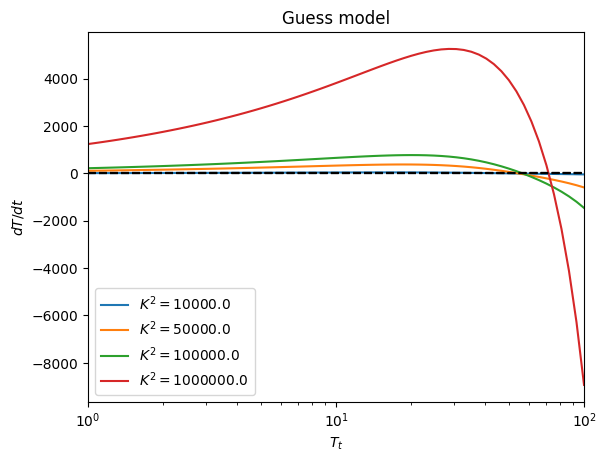

In [31]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
from scipy.special import gamma as gamma_func


def ode(z, y):
    f = y[0] # y1 = f
    df_dz = y[1] # y2 = df/dz
    dy2_dz = -K_sqr * (7/2 * f)**(-3/7)
    return np.array([df_dz, dy2_dz])

def BC(ya, yb):
    return np.array([yb[0] - f_Z, ya[1] - df0_dz])

@nb.jit
def ini_guess(f_t, z_arr, Lz):
    guess_arr = np.ones((2, z_arr.size))
    guess_arr[0, :] = f_t + heat_flux / a * (Lz - z_arr)
    guess_arr[1, :] = heat_flux / (-a)
    return guess_arr

epsilon0 = 8.8541878188e-12
me = 9.1093837015e-31
coulomb_log = 13
a = 9.6 * ((2 * np.pi)**(3/2) * epsilon0**2) / (me**(1/2) * e**(1/2) * coulomb_log) # [W/m eV^-7/2]
Lz = 50.0 # [m]
m = 1.67e-27# [kg] 
gamma_hat = 7.0 * np.sqrt(2/m)
e = 1.60218e-19 # [C]
heat_flux = 1e7 # [W/m2]

N = int(1e2)
K_vals = np.array([1e4, 5e4, 1e5, 1e6])
Tt_arr = np.logspace(0, 3, N)
dT_dt = np.zeros((4, N))
for k in range(4):
    K_sqr = K_vals[k]
    Tt = Tt_arr
    varpi = gamma_func(1/4)**2 / (2 * np.sqrt(2*np.pi)) #3/5 * np.pi/varpi = 0.72
    Tu = (Tt**(7/2) + ((7/2 * heat_flux * Lz/a)**(10/7) + (K_sqr * Lz**2 / (3/5 * np.pi/varpi)**2))**(7/10))**(2/7)
    #Tu = (Tt**(7/2) + (7/2 * heat_flux * Lz/a) + (np.sqrt(K_sqr) * Lz / (3/5 * np.pi/varpi))**(7/5) )**(2/7)
    qt = np.sqrt(K_sqr * a**2 * (Tu**2 - Tt**2) + heat_flux**2)
    nt = qt / (gamma_hat * (e * Tt)**(3/2) * 1e18)
    nu = 2*nt*Tt/Tu
    sigma_hat = a * 0.6125
    deltaq = qt - heat_flux
    R = 7/4 * Lz / sigma_hat * (Tu**2 - Tt**2) / (Tu**(7/2) - Tt**(7/2))
    j = np.sqrt(K_sqr * a * sigma_hat)
    voltage = R * j

    dT_dt[k] = (voltage**2/R - deltaq)/ (3 * nu_arr * Lz)

    #plt.title(f'$\hat\sigma = {sigma_hat}$')
    plt.xlabel('$T_t$')
    plt.ylabel('$dT/dt$')
    plt.semilogx(Tt_arr[0:67], dT_dt[k,0:67], label = f'$K^2 = {K_sqr}$')
    plt.axhline(0, color='black', linestyle='--')
    plt.xlim(1, 1e2)

plt.title('Guess model')
plt.legend()
#plt.figure()
#plt.title(f'$K^2 = {K_sqr}, \hat\sigma = {sigma_hat}$')
#plt.xlabel('$T_u$')
#plt.ylabel('$dT/dt$')
#plt.semilogx(Tu_arr, dT_dt, color = 'b')
#plt.grid()
#plt.xlim(1, 1e3)

Initial calculated voltage =  63.80779800026424
Optimization time = 80.713339 s
K^2 value = 28478572325.0164
Expected voltage =  330
Calculated voltage =  330.0000000000005


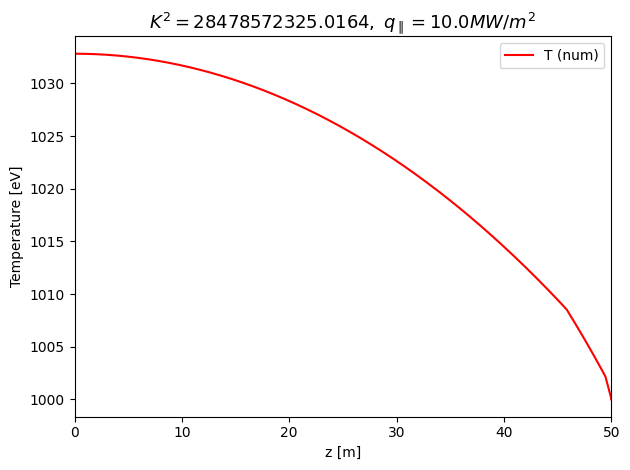

In [35]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
from scipy.optimize import root_scalar
import time
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

def my_incredible_ode_solver(T_t_input, z_arr_input, K_square):
    def BC(ya, yb):
        return np.array([yb[0] - f_Z, ya[1] - df0_dz])
    def ode(z, y):
        f = y[0] # y1 = f
        df_dz = y[1] # y2 = df/dz
        dy2_dz = -K_square * (7/2 * f)**(-3/7)
        return [df_dz, dy2_dz]
    @nb.jit
    def ini_guess(f_t, z_arr, Lz): #Linear guess
        guess_arr = np.ones((2, z_arr.size))
        guess_arr[0, :] = f_t + heat_flux / chi_hat * (Lz - z_arr)
        guess_arr[1, :] = heat_flux / (-chi_hat)
        return guess_arr

    f_Z = 2/7 * T_t_input**(7/2) # f(Z) = f(T_t)
    df0_dz = heat_flux / (-chi_hat) # df(Z)/dz = f(q_u)
    y_ini = ini_guess(T_t_input, z_arr_input, Lz)
    solution = solve_bvp(ode, BC, z_arr_input, y_ini, max_nodes = 1e6, tol = 1e-3)
    T_arr_output = (7/2 * solution.y[0])**(2/7)
    dT_arr_output = solution.y[1]/(T_arr_output**(5/2))
    
    qt_arr_output = np.sqrt(K_square * chi_hat**2 * (T_arr_output[0]**2 - T_arr_output[-1]**2) + heat_flux**2)
    voltage_output = (qt_arr_output-heat_flux) / np.sqrt(K_square * chi_hat * sigma_hat)
    return T_arr_output, dT_arr_output, qt_arr_output, voltage_output

def g(x):
    return my_incredible_ode_solver(Tt, z_arr, x)[3] - V_expected 

N = int(1e4)
K_sqr_ini = 1e9
Lz = 50.0 # [m]
m = 1.67e-27# [kg] 
gamma_hat = 7.0 * np.sqrt(2/m)
e = 1.60218e-19 # [C]
heat_flux = 1e7 # [W/m2]
V_expected = 330 # [V]
epsilon0 = 8.8541878188e-12
me = 9.1093837015e-31
coulomb_log = 13
chi_hat = 9.6 * ((2 * np.pi)**(3/2) * epsilon0**2) / (me**(1/2) * e**(1/2) * coulomb_log) # [W/m eV^-7/2]
sigma_hat = 0.6125 * chi_hat

Tt = 1000
z_arr = np.linspace(0, Lz, N)
T_arr = np.zeros((N))
dT_arr = np.zeros((N))
print('Initial calculated voltage = ', my_incredible_ode_solver(Tt, z_arr, K_sqr_ini)[3])

start_time = time.time()
result = root_scalar(g, x0=K_sqr_ini, method='secant') #root_scalar(g, x0=K_sqr_ini, method='secant')
end_time = time.time()
print(f'Optimization time = {(end_time - start_time):.6f} s')
print('K^2 value =', result.root)
print('Expected voltage = ', V_expected)
T_arr, dT_arr, qt_arr, V_calc = my_incredible_ode_solver(Tt, z_arr, result.root)
print('Calculated voltage = ', V_calc)

plt.figure()
plt.title(f'$K^2 = {result.root},\ q_\parallel = {heat_flux/1e6} MW/m^2$', fontsize = 13)
plt.plot(np.linspace(0, Lz, T_arr.size), T_arr, color = 'r', label = 'T (num)')
plt.xlabel('z [m]', fontsize = 10)
plt.ylabel('Temperature [eV]', fontsize = 10)
#plt.ylabel('f', fontsize = 10)
plt.legend(fontsize = 10)
#plt.ylim(Tt,)
plt.xlim(0, Lz)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
from scipy.optimize import root_scalar
import time
import warnings
import math

#warnings.filterwarnings("ignore", category=RuntimeWarning)
@nb.jit
def ini_guess(f_t, z_arr, Lz, qu_input, chi): #ode guess
    guess_arr = np.ones((2, z_arr.size))
    guess_arr[0, :] = f_t + qu_input / chi * (Lz - z_arr)
    guess_arr[1, :] = qu_input / (-chi)
    return guess_arr #y_ini = ini_guess(T_t_input, z_arr_input, Lz)

def my_incredible_ode_solver(T_t_input, z_arr_input, initial_guess, K_square):
    @nb.jit
    def BC(ya, yb):
        return np.array([yb[0] - f_Z, ya[1] - df0_dz])
    @nb.jit
    def ode(z, y):
        f = y[0] # y1 = f
        df_dz = y[1] # y2 = df/dz
        dy2_dz = -K_square * (7/2 * f)**(-3/7)
        return [df_dz, dy2_dz]

    f_Z = 2/7 * T_t_input**(7/2) # f(Z) = f(T_t)
    df0_dz = heat_flux / (-chi_hat) # df(Z)/dz = f(q_u)
    solution = solve_bvp(ode, BC, z_arr_input, initial_guess, max_nodes = 1e6, tol = 1e-3)
    (solution.message != 'The algorithm converged to the desired accuracy.') and print(solution.message)
    T_arr_output = (7/2 * solution.y[0])**(2/7)
    dT_arr_output = solution.y[1]/(T_arr_output**(5/2))
    
    qt_arr_output = np.sqrt(K_square * chi_hat**2 * (T_arr_output[0]**2 - T_arr_output[-1]**2) + heat_flux**2)
    voltage_output = (qt_arr_output-heat_flux) / np.sqrt(K_square * chi_hat * sigma_hat)
    return T_arr_output, dT_arr_output, voltage_output, solution.y[0], solution.y[1]

def g(x):
    return my_incredible_ode_solver(Tt, z_space, y_ini, x)[2] - V_expected 

Lz = 50.0 # [m]
m = 1.67e-27# [kg] 
gamma_hat = 7.0 * np.sqrt(2/m)
e = 1.60218e-19 # [C]
heat_flux = 1e7 # [W/m2]
V_expected = 0.1 # [V]
epsilon0 = 8.8541878188e-12
me = 9.1093837015e-31
coulomb_log = 13
chi_hat = 9.6 * ((2 * np.pi)**(3/2) * epsilon0**2) / (me**(1/2) * e**(1/2) * coulomb_log) # [W/m eV^-7/2]
sigma_hat = 0.6125 * chi_hat

N = int(20)
N_nodes = int(1e3)
Tt_arr = np.logspace(0, 3, N)
z_arr = np.linspace(0, Lz, N_nodes)
z_space = z_arr

Tu_arr = np.zeros(N)
qt_arr = np.zeros(N)
nt_arr = np.zeros(N)
nu_arr = np.zeros(N)
K_arr = np.zeros(N)

K_sqr_ini = 0
K_arr[-1] = K_sqr_ini
y_ini = ini_guess(Tt_arr[0], z_arr, Lz, heat_flux, chi_hat)

start_time = time.time()
for i in range(N):
    Tt = Tt_arr[i]
    T_arr = np.zeros((N_nodes))
    dT_arr = np.zeros((N_nodes))
    result = root_scalar(g, x0=K_arr[i-1], method='secant') #root_scalar(g, x0=K_sqr_ini, method='secant')
    if math.isnan(result.root) or (result.root==0):
        print('Break error in index = ', i)
        break
    K_arr[i] = result.root
    T_arr, dT_arr, V_calc, f_arr, df_arr = my_incredible_ode_solver(Tt, z_space, y_ini, result.root)
    y_ini = np.array([f_arr, df_arr])
    z_space = np.linspace(0, Lz, f_arr.size)
    Tu_arr[i] = T_arr[0]
    qt_arr[i] = np.sqrt(K_arr[i] * chi_hat**2 * (Tu_arr[i]**2 - Tt**2) + heat_flux**2)
    nt_arr[i] = qt_arr[i] / (gamma_hat * (e * Tt)**(3/2) * 1e18)
    result.clear()

end_time = time.time()
print(f'Voltage fixed - calculation time = {(end_time - start_time):.6f} s')
nu_arr = 2*nt_arr*Tt_arr/Tu_arr

plt.figure()
plt.title(f'$Voltage = {V_expected} V,\ q_u = {heat_flux/1e6} MW/m^2$ \n Dashed line = Standard model', fontsize = 13)
plt.loglog(Tt_arr, Tu_arr, color = 'b', label = '$T_u$')
plt.loglog(Tt_arr, qt_arr/1e6, color = 'orange', label = '$q_t$')
plt.loglog(Tt_arr, nt_arr, color = 'g', label = '$n_t$')
plt.loglog(Tt_arr, nu_arr, color = 'black', label = '$n_u$')

/tmp/ipykernel_288899/3663195700.py:37: RuntimeWarning: invalid value encountered in double_scalars
  voltage_output = (qt_arr_output-heat_flux) / np.sqrt(K_square * chi_hat * sigma_hat)


A singular Jacobian encountered when solving the collocation system.
A singular Jacobian encountered when solving the collocation system.
A singular Jacobian encountered when solving the collocation system.
A singular Jacobian encountered when solving the collocation system.
A singular Jacobian encountered when solving the collocation system.
A singular Jacobian encountered when solving the collocation system.
A singular Jacobian encountered when solving the collocation system.
A singular Jacobian encountered when solving the collocation system.
A singular Jacobian encountered when solving the collocation system.


Exception ignored on calling ctypes callback function: <function ExecutionEngine._raw_object_cache_notify at 0x7ff014705cf0>
Traceback (most recent call last):
  File "/home/penguindrum/.local/lib/python3.10/site-packages/llvmlite/binding/executionengine.py", line 178, in _raw_object_cache_notify
    def _raw_object_cache_notify(self, data):
KeyboardInterrupt: 


A singular Jacobian encountered when solving the collocation system.
A singular Jacobian encountered when solving the collocation system.
A singular Jacobian encountered when solving the collocation system.
A singular Jacobian encountered when solving the collocation system.
A singular Jacobian encountered when solving the collocation system.
A singular Jacobian encountered when solving the collocation system.
A singular Jacobian encountered when solving the collocation system.
A singular Jacobian encountered when solving the collocation system.
A singular Jacobian encountered when solving the collocation system.
A singular Jacobian encountered when solving the collocation system.
A singular Jacobian encountered when solving the collocation system.
A singular Jacobian encountered when solving the collocation system.
A singular Jacobian encountered when solving the collocation system.
A singular Jacobian encountered when solving the collocation system.
A singular Jacobian encountered wh

Standard model calculation time = 12.361556 s


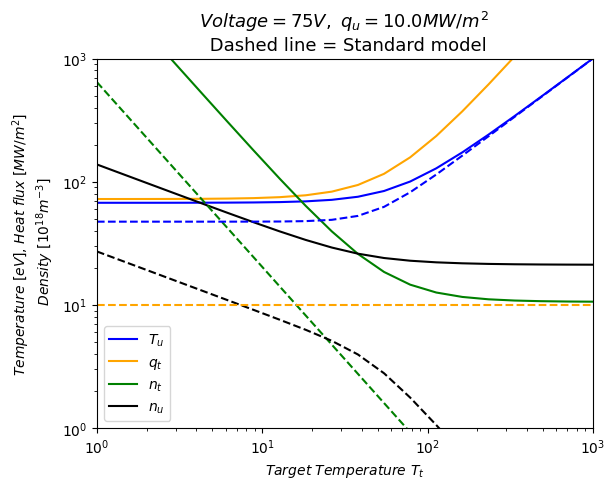

In [31]:
N = int(20)
z_arr = np.linspace(0, Lz, int(1e2))
K_sqr = 0
Tt_0 = np.logspace(0, 3, N)
ft_0 = (2/7) * Tt_0**(7/2)
Tu_0 = np.zeros(N)
qt_0 = np.zeros(N)
nt_0 = np.zeros(N)
nu_0 = np.zeros(N)
fu_0 = np.zeros(N)

start_time = time.time()
for index in range(N):
    Tt = Tt_0[index]
    T_arr, dT_arr, V_calc, f_arr, df_arr = my_incredible_ode_solver(Tt, z_arr, ini_guess(Tt, z_arr, Lz, heat_flux, chi_hat), 0)
    Tu_0[index] = T_arr[0]
    qt_0[index] = np.sqrt(K_sqr * chi_hat**2 * (Tu_0[index]**2 - Tt_0[index]**2) + heat_flux**2)
    nt_0[index] = qt_0[index] / (gamma_hat * (e * Tt_0[index])**(3/2) * 1e18)
nu_0 = 2*nt_0*Tt_0/Tu_0
end_time = time.time()
print(f'Standard model calculation time = {(end_time - start_time):.6f} s')

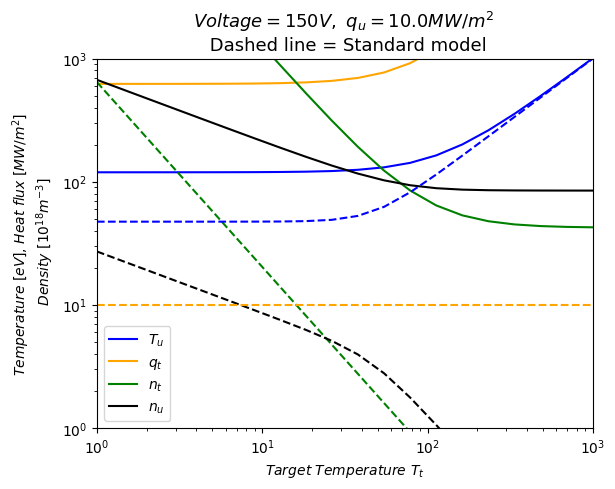

In [40]:
plt.title(f'$Voltage = {V_expected} V,\ q_u = {heat_flux/1e6} MW/m^2$ \n Dashed line = Standard model', fontsize = 13)
plt.loglog(Tt_arr, Tu_arr, color = 'b', label = '$T_u$')
plt.loglog(Tt_arr, qt_arr/1e6, color = 'orange', label = '$q_t$')
plt.loglog(Tt_arr, nt_arr, color = 'g', label = '$n_t$')
plt.loglog(Tt_arr, nu_arr, color = 'black', label = '$n_u$')

plt.loglog(Tt_0, nt_0, color = 'g', linestyle = '--')
plt.loglog(Tt_0, Tu_0, color = 'b', linestyle = '--')
plt.loglog(Tt_0, nu_0, color = 'black', linestyle = '--')
plt.loglog(Tt_0, qt_0/1e6, color = 'orange', linestyle = '--')
plt.xlabel('$Target\ Temperature\ T_t$', fontsize = 10)
plt.ylabel('$Temperature\ [eV]$, $Heat\ flux\ [MW/m^2]$ \n $Density\ [10^{18}m^{-3}]$', fontsize = 10)
plt.legend(fontsize = 10)
plt.ylim(1, 1e3)
plt.xlim(1, 1e3)
plt.show()

Critical point =  78.47599703514611 [eV]


(1, 1000.0)

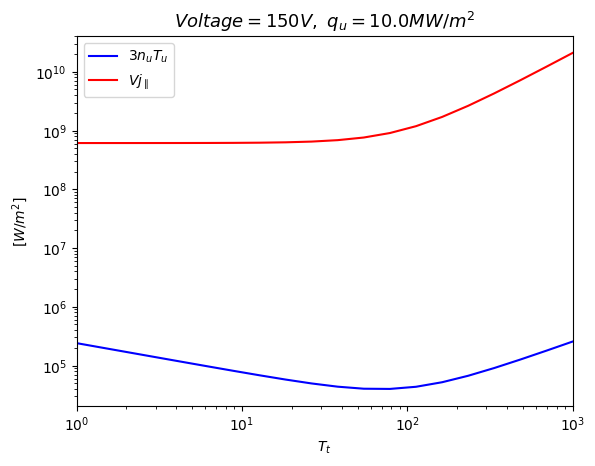

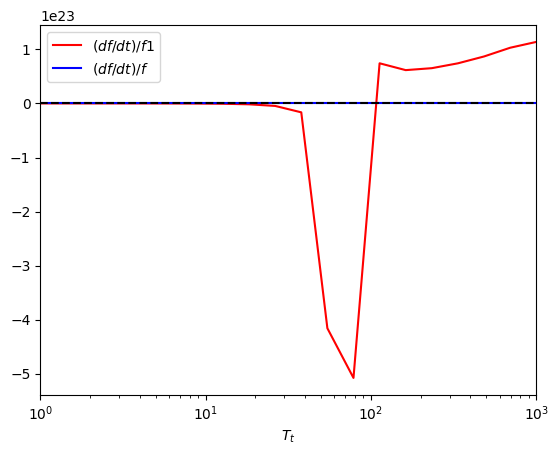

In [41]:
plt.figure()
plt.title(f'$Voltage = {V_expected} V,\ q_u = {heat_flux/1e6} MW/m^2$', fontsize = 13)
plt.loglog(Tt_arr, 3 * nu_arr *Tu_arr, color = 'b', label = '$3n_u T_u$')
plt.loglog(Tt_arr, V_expected * np.sqrt(K_arr * chi_hat * sigma_hat), color = 'r', label = '$Vj_\parallel$')
#plt.loglog(Tt_arr, V_expected * np.sqrt(K_arr * chi_hat * sigma_hat * 1e36)/(3 * nu_arr *Tu_arr), color = 'orange', label = '$Vj_\parallel/3n_uT_u$')

plt.xlabel('$T_t$')
plt.ylabel('$[W/m^2]$')
plt.xlim(1, 1e3)
plt.legend()

plt.figure()
deri1 = np.gradient(3 * nu_arr *Tu_arr, Tt_arr)
deri2 = np.gradient(np.sqrt(K_arr * chi_hat * sigma_hat), Tt_arr)
tau = (V_expected * deri2) /deri1
tau1 = np.gradient(V_expected *np.sqrt(K_arr * chi_hat * sigma_hat * 1e36), 3 * nu_arr *Tu_arr)
plt.semilogx(Tt_arr, tau1, color = 'r', label = '$(df/dt)/f1$')
plt.semilogx(Tt_arr, tau, color = 'b', label = '$(df/dt)/f$')

#plt.semilogx(Tt_arr, V_expected * np.sqrt(chi_hat * sigma_hat) / 3 * np.gradient(K_arr, nu_arr * Tu_arr), color = 'b', label = '$Test$')

#plt.semilogx(Tt_arr, tau, color = 'r', label = '$(df/dt)/f$')
print('Critical point = ', Tt_arr[np.argmin(abs(1/tau))], '[eV]')
#plt.semilogx(Tt_arr, tau, color = 'b', label = '$(df/dt)/f$')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('$T_t$')
#sign = np.sign(tau)
#plt.semilogx(Tt_arr, sign, label = '$Sign$')
plt.legend()
plt.xlim(1, 1e3)


[4.77767074e+06 4.77855976e+06 4.78039880e+06 4.78420261e+06
 4.79206913e+06 4.80833558e+06 4.84197350e+06 4.91157843e+06
 5.05591305e+06 5.35686485e+06 5.99224136e+06 7.36737682e+06
 1.04724811e+07 1.79153745e+07 3.69842549e+07 8.87551767e+07
 2.35151917e+08 6.59405764e+08 1.90520763e+09 5.58869495e+09]


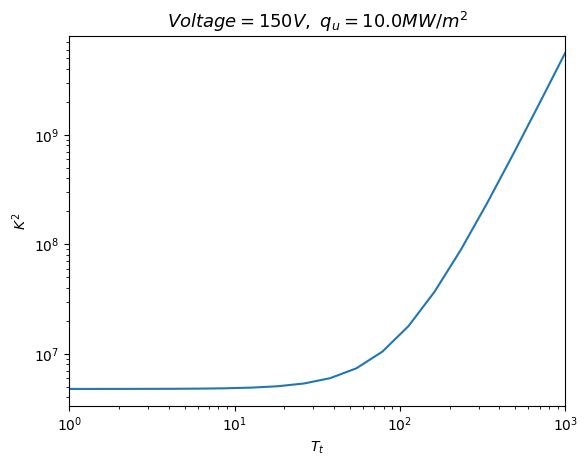

In [42]:
plt.figure()
plt.loglog(Tt_arr, K_arr)
plt.title(f'$Voltage = {V_expected} V,\ q_u = {heat_flux/1e6} MW/m^2$', fontsize = 13)
plt.xlabel('$T_t$')
plt.ylabel('$K^2$')
plt.xlim(1,1e3)
print(K_arr)

Initial calculated voltage =  350.0000021099864
Optimization time = 6.153019 s
K^2 value = 942784148.557576
Expected voltage =  350
Calculated voltage =  350.0


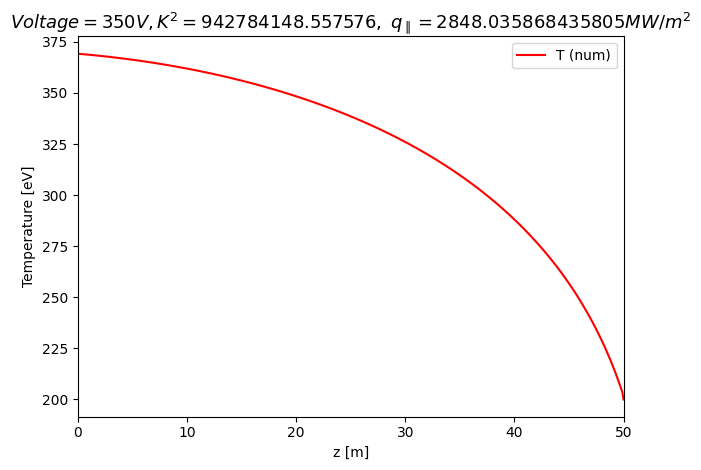

In [14]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
from scipy.optimize import root_scalar
import time
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

def my_incredible_ode_solver(T_t_input, z_arr_input, K_square):
    def BC(ya, yb):
        return np.array([yb[0] - f_Z, ya[1] - df0_dz])
    def ode(z, y):
        f = y[0] # y1 = f
        df_dz = y[1] # y2 = df/dz
        dy2_dz = -K_square * (7/2 * f)**(-3/7)
        return [df_dz, dy2_dz]
    @nb.jit
    def ini_guess(f_t, z_arr, Lz): #Linear guess
        guess_arr = np.ones((2, z_arr.size))
        guess_arr[0, :] = f_t + heat_flux / chi_hat * (Lz - z_arr)
        guess_arr[1, :] = heat_flux / (-chi_hat)
        return guess_arr

    f_Z = 2/7 * T_t_input**(7/2) # f(Z) = f(T_t)
    df0_dz = heat_flux / (-chi_hat) # df(Z)/dz = f(q_u)
    y_ini = ini_guess(T_t_input, z_arr_input, Lz)
    solution = solve_bvp(ode, BC, z_arr_input, y_ini, max_nodes = 1e6, tol = 1e-5)
    f_arr_output = solution.y[0]
    T_arr_output = (7/2 * solution.y[0])**(2/7)
    dT_arr_output = solution.y[1]/(T_arr_output**(5/2))
    
    qt_arr_output = np.sqrt(K_square * chi_hat**2 * (T_arr_output[0]**2 - T_arr_output[-1]**2) + heat_flux**2)
    voltage_output = (qt_arr_output-heat_flux) / np.sqrt(K_square * chi_hat * sigma_hat)
    return T_arr_output, dT_arr_output, qt_arr_output, voltage_output, f_arr_output

def g(x):
    return my_incredible_ode_solver(Tt, z_arr, x)[3] - V_expected 

N = int(1e4)
K_sqr_ini = 942784167.6743213
chi_hat = 2.0e3 # [W/m eV^-7/2]
Lz = 50.0 # [m]
m = 1.67e-27# [kg] 
e = 1.60218e-19 # [C]
heat_flux = 2848035868.435805 # [W/m2]
V_expected = 350 # [V]

epsilon0 = 8.8541878188e-12
me = 9.1093837015e-31
coulomb_log = 13
chi_hat = 9.6 * ((2 * np.pi)**(3/2) * epsilon0**2) / (me**(1/2) * e**(1/2) * coulomb_log) # [W/m eV^-7/2]
sigma_hat = 0.6125 * chi_hat

Tt = 200
z_arr = np.linspace(0, Lz, N)
T_arr = np.zeros((N))
f_arr = np.zeros((N))
dT_arr = np.zeros((N))
print('Initial calculated voltage = ', my_incredible_ode_solver(Tt, z_arr, K_sqr_ini)[3])

start_time = time.time()
result = root_scalar(g, x0=K_sqr_ini, method='secant') #root_scalar(g, x0=K_sqr_ini, method='secant')
end_time = time.time()
print(f'Optimization time = {(end_time - start_time):.6f} s')
print('K^2 value =', result.root)
print('Expected voltage = ', V_expected)
T_arr, dT_arr, qt, V_calc, f_arr = my_incredible_ode_solver(Tt, z_arr, result.root)

print('Calculated voltage = ', V_calc)

plt.figure()
plt.title(f'$Voltage = {V_expected} V, K^2 = {result.root},\ q_\parallel = {heat_flux/1e6} MW/m^2$', fontsize = 13)
plt.plot(np.linspace(0, Lz, T_arr.size), T_arr, color = 'r', label = 'T (num)')
plt.xlabel('z [m]', fontsize = 10)
plt.ylabel('Temperature [eV]', fontsize = 10)
#plt.ylabel('f', fontsize = 10)
plt.legend(fontsize = 10)
#plt.ylim(Tt,)
plt.xlim(0, Lz)
plt.tight_layout()
plt.show()

The algorithm converged to the desired accuracy.
The algorithm converged to the desired accuracy.


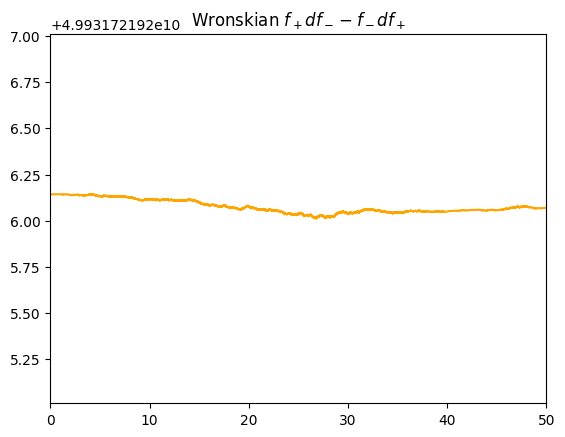

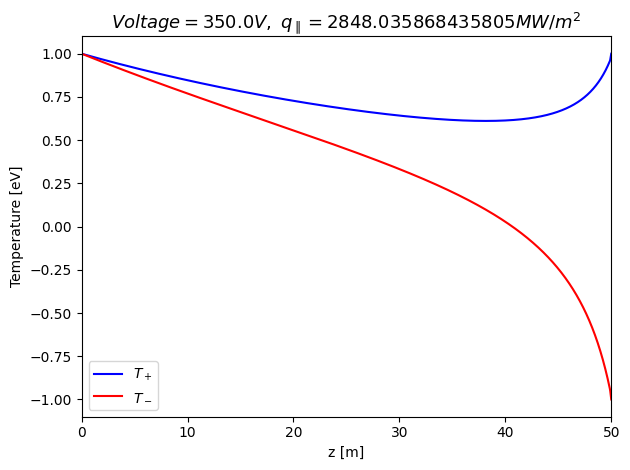

[[ 3.00415847e+10  5.60822574e+07  1.54584760e+08]
 [ 9.96812554e+09  1.27853925e+08  1.73348879e+08]
 [ 3.87229005e+10 -5.73037377e+07  5.73037377e+07]]
9.31022308304655e+24


In [15]:
def perturbation_ode_solver(f0_input, z_arr_input, Ksqr_input, bc1 = 1, bc2 = 1):
    def BC_perturbation(ya, yb):
        return np.array([ya[0] - bc1, yb[0] - bc2])
    def ode_perturbation(z, y):
        f1 = y[0] # y1 = f
        df_dz = y[1] # y2 = df/dz
        f0 = np.interp(np.linspace(0, 1, f1.size), np.linspace(0, 1, f0_input.size), f0_input, left=f0_input[0], right=f0_input[-1])
        df2_dz = 3/2 * Ksqr_input * (7/2)**(-10/7) * f0**(-10/7) * f1
        return [df_dz, df2_dz]
    @nb.jit
    def ini_guess(value1, slope, z): #Linear guess
        guess_arr = np.ones((2, z.size))
        guess_arr[0] = value1 + slope * z
        guess_arr[1] = slope
        return guess_arr
    
    y_ini = ini_guess(bc1, (bc2-bc1)/Lz, z_arr_input)
    solution = solve_bvp(ode_perturbation, BC_perturbation, z_arr_input, y_ini, max_nodes = 1e6, tol = 1e-3)
    print(solution.message)
    return solution.y[0], solution.y[1]

j0 = np.sqrt(result.root * chi_hat * sigma_hat)
z_arr = np.linspace(0, Lz, f_arr.size)

T_plus, dT_plus = perturbation_ode_solver(f_arr, z_arr, result.root, 1 * T_arr[0]**(5/2), 1 * T_arr[-1]**(5/2))
T_minus, dT_minus = perturbation_ode_solver(f_arr, z_arr, result.root, 1 * T_arr[0]**(5/2), -1 * T_arr[-1]**(5/2))

T_plus = np.interp(np.linspace(0, 1, T_arr.size), np.linspace(0, 1, T_plus.size), T_plus)
T_minus = np.interp(np.linspace(0, 1, T_arr.size), np.linspace(0, 1, T_minus.size), T_minus)
dT_plus = np.interp(np.linspace(0, 1, T_arr.size), np.linspace(0, 1, dT_plus.size), dT_plus)
dT_minus = np.interp(np.linspace(0, 1, T_arr.size), np.linspace(0, 1, dT_minus.size), dT_minus)

Wronskian = abs(T_plus * dT_minus - T_minus * dT_plus) #np.round(Wronskian, decimals = 16)
plt.figure()
plt.title(f'Wronskian $f_+df_- - f_-df_+$')
plt.plot(np.linspace(0, Lz, T_arr.size), np.round(Wronskian, decimals = 5), color = 'orange')
plt.ylim(np.min(Wronskian)-1, np.min(Wronskian)+1)
plt.xlim(0, Lz)

T_plus = T_plus / T_arr**(5/2)
T_minus = T_minus / T_arr**(5/2)
plt.figure()
plt.title(f'$Voltage = {np.round(V_calc, decimals = 2)} V,\ q_\parallel = {heat_flux/1e6} MW/m^2$', fontsize = 13)
plt.plot(np.linspace(0, Lz, T_plus.size), T_plus, color = 'b', label = '$T_+$')
plt.plot(np.linspace(0, Lz, T_minus.size), T_minus, color = 'r', label = '$T_-$')
plt.xlabel('z [m]', fontsize = 10)
plt.ylabel('Temperature [eV]', fontsize = 10)
#plt.ylabel('f', fontsize = 10)
plt.legend(fontsize = 10)
#plt.ylim(Tt,)
plt.xlim(0, Lz)
plt.tight_layout()
plt.show()

from scipy.integrate import simpson

M11 = 7/2 * heat_flux;      M12 = -chi_hat * dT_plus[0];        M13 = -chi_hat * dT_minus[0]
M21 = qt + 5/2 * heat_flux;     M22 = -chi_hat * dT_plus[-1];       M23 = -chi_hat * dT_minus[-1]
M31 = 2 * qt - 5/2 * heat_flux;     M32 = - 1/2 * qt * T_plus[-1]/T_arr[-1];        M33 = - 1/2 * qt * T_minus[-1]/T_arr[-1]

M = np.array([[M21, M22, M23],
             [M11, M12, M13],
             [M31, M32, M33]])
det_M = np.linalg.det(M)
print(M)
print(det_M)


In [4]:
M11 = 7/2 * heat_flux;      M12 = -chi_hat * dT_plus[0];        M13 = -chi_hat * dT_minus[0]
M21 = 3 * qt;     M22 = -chi_hat * dT_plus[-1] - 1/2 * qt * T_plus[-1]/T_arr[-1];       M23 = -chi_hat * dT_minus[-1] - 1/2 * qt * T_minus[-1]/T_arr[-1]
M31 = qt -  heat_flux;     M32 = -chi_hat * dT_plus[-1] - (-chi_hat * dT_plus[0]);       M33 = -chi_hat * dT_minus[-1] - (-chi_hat * dT_minus[0])

M = np.array([[M11, M12, M13],
              [M21, M22, M23],
             [M31, M32, M33]])
det_M = np.linalg.det(M)
print(M)
print(det_M)

[[ 3.50000000e+06  8.33763986e+04  9.61561205e+06]
 [ 1.18116058e+07  1.98695640e+04  9.63519909e+06]
 [ 2.93720193e+06 -4.38208250e+04 -9.89635989e+01]]
-1.700697293449539e+18


In [14]:
int1 = sigma_hat * V_calc / j0
int2 = 3/2 * 1/result.root * (dT_plus[-1] - dT_plus[0])
int3 = 3/2 * 1/result.root * (dT_minus[-1] - dT_minus[0])
M = np.array([[1, -5/2 * j0, 0, 0],
              [int1, -3/2 * j0 * int1, -3/2 * j0 * int2, -3/2 * j0 * int3],
              [0, 7/2 * heat_flux, -chi_hat * dT_plus[0], -chi_hat * dT_minus[0]],
              [0, 3 * qt, (-chi_hat * dT_plus[-1] - 1/2 * T_plus[-1]/T_arr[-1] * qt), (-chi_hat * dT_minus[-1] - 1/2 * T_minus[-1]/T_arr[-1] * qt)]])
det_M = np.linalg.det(M)
print(M)
print(det_M)

[[ 1.00000000e+00 -3.00579011e+07  0.00000000e+00  0.00000000e+00]
 [ 2.43171368e-02 -4.38553257e+05 -4.27063584e+03 -1.19207298e+03]
 [ 0.00000000e+00  3.50000000e+07  2.44953965e+07  3.22623635e+07]
 [ 0.00000000e+00  7.24389627e+09 -3.18865089e+06  3.99780190e+07]]
-4.640500895723211e+20


In [43]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
from scipy.optimize import root_scalar
import time
import warnings
import math
from scipy.integrate import simpson
from scipy.interpolate import interp1d

#warnings.filterwarnings("ignore", category=RuntimeWarning)

def my_incredible_ode_solver(T_t_input, z_arr_input, qu_input, K_square):
    def BC(ya, yb):
        return np.array([yb[0] - f_Z, ya[1] - df0_dz])
    def ode(z, y):
        f = y[0] # y1 = f
        df_dz = y[1] # y2 = df/dz
        dy2_dz = -K_square * (7/2 * f)**(-3/7)
        return [df_dz, dy2_dz]
    def ini_guess(f_t, z_arr, Lz): #Linear guess
        guess_arr = np.ones((2, z_arr.size))
        guess_arr[0, :] = f_t + qu_input / chi_hat * (Lz - z_arr)
        guess_arr[1, :] = qu_input / (-chi_hat)
        return guess_arr

    f_Z = 2/7 * T_t_input**(7/2) # f(Z) = f(T_t)
    df0_dz = qu_input / (-chi_hat) # df(Z)/dz = f(q_u)
    y_ini = ini_guess(T_t_input, z_arr_input, Lz)
    solution = solve_bvp(ode, BC, z_arr_input, y_ini, max_nodes = 1e6, tol = 1e-5)
    f_arr_output = solution.y[0]
    T_arr_output = (7/2 * solution.y[0])**(2/7)
    dT_arr_output = solution.y[1]/(T_arr_output**(5/2))
    
    qt_output = np.sqrt(K_square * chi_hat**2 * (T_arr_output[0]**2 - T_arr_output[-1]**2) + qu_input**2)
    voltage_output = (qt_output-qu_input) / np.sqrt(K_square * chi_hat * sigma_hat)
    
    return T_arr_output, dT_arr_output, voltage_output, qt_output, f_arr_output

def g(x):
    return my_incredible_ode_solver(Tt, z_arr, heat_flux, x)[2] - V_expected

def perturbation_ode_solver(f0_input, z_arr_input, Ksqr_input, bc1 = 1, bc2 = 1):
    
    f0_interp = interp1d(np.linspace(0, Lz, f0_input.size), f0_input, kind='cubic', bounds_error=False)

    def BC_perturbation(ya, yb):
        return np.array([ya[0] - bc1, yb[0] - bc2])
    def ode_perturbation(z, y):
        f1 = y[0] # y1 = f
        df_dz = y[1] # y2 = df/dz
        #f0 = np.interp(np.linspace(0, 1, f1.size), np.linspace(0, 1, f0_input.size), f0_input, left=f0_input[0], right=f0_input[-1])
        f0 = f0_interp(z)
        df2_dz = 3/2 * Ksqr_input * (7/2)**(-10/7) * f0**(-10/7) * f1
        return [df_dz, df2_dz]
    def ini_guess(value1, slope, z): #Linear guess
        guess_arr = np.ones((2, z.size))
        guess_arr[0] = value1 + slope * z
        guess_arr[1] = slope
        return guess_arr
    
    y_ini = ini_guess(bc1, (bc2-bc1)/Lz, z_arr_input)
    solution = solve_bvp(ode_perturbation, BC_perturbation, z_arr_input, y_ini, max_nodes = 1e6, tol = 1e-3)
    (solution.message != 'The algorithm converged to the desired accuracy.') and print(solution.message)
    return solution.y[0], solution.y[1]

@nb.jit
def detcalc1(T0, T_plus, T_minus, dT_plus, dT_minus, qu, qt, Ksqr, chi_input, sigma_input, voltage, j):
    int1 = sigma_input * voltage / j
    int2 = 2/3 * 1/Ksqr * (dT_plus[-1] - dT_plus[0])
    int3 = 2/3 * 1/Ksqr * (dT_minus[-1] - dT_minus[0])
    Matrix = np.array([[1, -5/2 * j, 0, 0],
                [int1, -3/2 * j * int1, -3/2 * j * int2, -3/2 * j * int3],
                [0, 7/2 * qu, -chi_input * dT_plus[0], -chi_input * dT_minus[0]],
                [0, 3 * qt, (-chi_input * dT_plus[-1] - 1/2 * T_plus[-1]/T0[-1] * qt), (-chi_input * dT_minus[-1] - 1/2 * T_minus[-1]/T0[-1] * qt)]])
    return np.linalg.det(Matrix), Matrix

@nb.jit
def detcalc2(T0, T_plus, T_minus, dT_plus, dT_minus, qu, qt, chi_input):
    M11 = 7/2 * qu
    M12 = -chi_input * dT_plus[0]
    M13 = -chi_input * dT_minus[0]
    M21 = 3 * qt
    M22 = -chi_input * dT_plus[-1] - 1/2 * qt * T_plus[-1]/T0[-1]
    M23 = -chi_input * dT_minus[-1] - 1/2 * qt * T_minus[-1]/T0[-1]
    M31 = qt - qu
    M32 = -chi_input * dT_plus[-1] - (-chi_input * dT_plus[0])
    M33 = -chi_input * dT_minus[-1] - (-chi_input * dT_minus[0])
    
    Matrix = np.array([[M11, M12, M13],
                [M21, M22, M23],
                [M31, M32, M33]])
    return np.linalg.det(Matrix), Matrix

@nb.jit
def detcalc2_mk2(T0, T_plus, T_minus, dT_plus, dT_minus, qu, qt, chi_input):
    M11 = 7/2 * qu
    M12 = -chi_input * dT_plus[0]
    M13 = -chi_input * dT_minus[0]
    M21 = 3 * qt
    M22 = -chi_input * dT_plus[-1] - 1/2 * qt * T_plus[-1]/T0[-1]
    M23 = -chi_input * dT_minus[-1] - 1/2 * qt * T_minus[-1]/T0[-1]
    M31 = qt - qu + qt
    M32 = -chi_input * dT_plus[-1] - (-chi_input * dT_plus[0])
    M33 = -chi_input * dT_minus[-1] - (-chi_input * dT_minus[0])

    Matrix = np.array([[M11, M12, M13],
                [M21, M22, M23],
                [M31, M32, M33]])
    return np.linalg.det(Matrix), Matrix

@nb.jit
def detcalc3(T0, T_plus, T_minus, dT_plus, dT_minus, qu, qt, chi_input):
    M11 = 7/2 * qu;      M12 = -chi_hat * dT_plus[0];        M13 = -chi_input * dT_minus[0]
    M21 = qt + 5/2 * qu;     M22 = -chi_hat * dT_plus[-1];       M23 = -chi_input * dT_minus[-1]
    M31 = 2 * qt - 5/2 * qu;     M32 = - 1/2 * qt * T_plus[-1]/T0[-1];        M33 = - 1/2 * qt * T_minus[-1]/T0[-1]

    Matrix = np.array([[M21, M22, M23],
                       [M11, M12, M13],
                       [M31, M32, M33]])
    return np.linalg.det(Matrix), Matrix

K_sqr_ini = 1e3
Lz = 50.0 # [m]
m = 1.67e-27# [kg] 
gamma_hat = 7.0 * np.sqrt(2/m)
e = 1.60218e-19 # [C]
V_expected = 150 # [V]
Tt = 100 # [eV]

epsilon0 = 8.8541878188e-12
me = 9.1093837015e-31
coulomb_log = 13
chi_hat = 9.6 * ((2 * np.pi)**(3/2) * epsilon0**2) / (me**(1/2) * e**(1/2) * coulomb_log) # [W/m eV^-7/2]
sigma_hat = 0.6125 * chi_hat

N = int(40)
N_nodes = int(1e4)
qu_arr = np.logspace(7, 9, N)
N = qu_arr.size
z_arr = np.linspace(0, Lz, N_nodes)
Tu_arr = np.zeros(N); qt_arr = np.zeros(N); nt_arr = np.zeros(N); nu_arr = np.zeros(N); K_arr = np.zeros(N)
det_M2 = np.zeros(N)
M2 = np.zeros((qu_arr.size, 3, 3))
det_M3 = np.zeros(N)
M3 = np.zeros((qu_arr.size, 3, 3))
det_M1 = np.zeros(N)
M1 = np.zeros((qu_arr.size, 4, 4))

det_M = np.zeros(N)
M = np.zeros((qu_arr.size, 3, 3))
K_arr[-1] = K_sqr_ini
start_time = time.time()

for i in range(N):
    heat_flux = qu_arr[i]
    T_arr = np.zeros((N_nodes)); f_arr = np.zeros((N_nodes)); dT_arr = np.zeros((N_nodes))
    result = root_scalar(g, x0=K_arr[i-1], method='secant') #root_scalar(g, x0=K_sqr_ini, method='secant')
    if math.isnan(result.root) or (result.root==0):
        print('Break error in index = ', i)
        break
    K_arr[i] = result.root
    T_arr, dT_arr, V_calc, qt, f_arr = my_incredible_ode_solver(Tt, z_arr, heat_flux, result.root)
    z_space = np.linspace(0, Lz, T_arr.size)
    Tu_arr[i] = T_arr[0]
    qt_arr[i] = qt
    nt_arr[i] = qt / (gamma_hat * (e * Tt)**(3/2))
    
    j0 = np.sqrt(result.root * chi_hat * sigma_hat)
    T_plus, dT_plus = perturbation_ode_solver(f_arr, z_space, result.root, 1 * T_arr[0]**(5/2), 1 * T_arr[-1]**(5/2))
    T_minus, dT_minus = perturbation_ode_solver(f_arr, z_space, result.root, 1 * T_arr[0]**(5/2), -1 * T_arr[-1]**(5/2))
    
    T_plus = np.interp(np.linspace(0, 1, T_arr.size), np.linspace(0, 1, T_plus.size), T_plus)
    T_minus = np.interp(np.linspace(0, 1, T_arr.size), np.linspace(0, 1, T_minus.size), T_minus)
    dT_plus = np.interp(np.linspace(0, 1, T_arr.size), np.linspace(0, 1, dT_plus.size), dT_plus)
    dT_minus = np.interp(np.linspace(0, 1, T_arr.size), np.linspace(0, 1, dT_minus.size), dT_minus)

    T_plus = T_plus / T_arr**(5/2)
    T_minus = T_minus / T_arr**(5/2)
    
    det_M[i], M[i] = detcalc2_mk2(T_arr, T_plus, T_minus, dT_plus, dT_minus, heat_flux, qt, chi_hat)
    det_M3[i], M3[i] = detcalc3(T_arr, T_plus, T_minus, dT_plus, dT_minus, heat_flux, qt, chi_hat)
    #det_M2[i], M2[i] = detcalc2(T_arr, T_plus, T_minus, dT_plus, dT_minus, heat_flux, qt, chi_hat)
    #det_M1[i], M1[i] = detcalc1(T_arr, T_plus, T_minus, dT_plus, dT_minus, heat_flux, qt, result.root, chi_hat, sigma_hat, V_calc, j0)
    result.clear()

end_time = time.time()
print(f'Loop time = {(end_time - start_time):.6f} s')
nu_arr = 2*nt_arr*Tt/Tu_arr

Loop time = 214.197650 s


## $2q_t$ - $q_u$ 100V

Have negative value = [False]


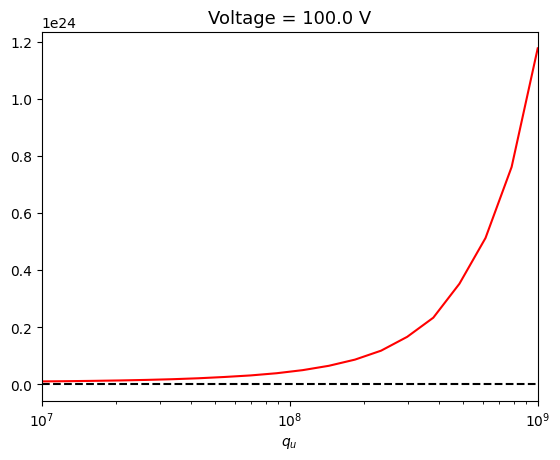

In [24]:
print('Have negative value =', np.in1d(-1, np.sign(det_M)))
plt.figure()
plt.title(f'Voltage = {np.round(V_calc, decimals = 2)} V', fontsize = 13)
plt.axhline(0, color='black', linestyle='--')
plt.semilogx(qu_arr[np.nonzero(det_M<0)], det_M[np.nonzero(det_M<0)], color = 'b')
plt.semilogx(qu_arr[np.nonzero(det_M>0)], det_M[np.nonzero(det_M>0)], color = 'r')
plt.xlabel('$q_u$')
#plt.legend(fontsize = 10)
plt.xlim(qu_arr[0], qu_arr[-1])
plt.show()

## 12.5V

Have negative value =  [False]


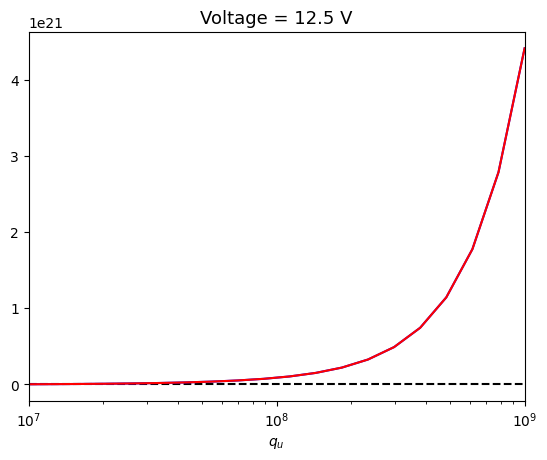

In [22]:
print('Have negative value = ', np.in1d(-1, np.sign(det_M3)))
plt.figure()
plt.title(f'Voltage = {np.round(V_calc, decimals = 2)} V', fontsize = 13)
plt.axhline(0, color='black', linestyle='--')
plt.semilogx(qu_arr, det_M3, color = 'b')
plt.semilogx(qu_arr[np.nonzero(det_M3>=0)], det_M3[np.nonzero(det_M3>=0)], color = 'r')
plt.xlabel('$q_u$')
#plt.legend(fontsize = 10)
plt.xlim(qu_arr[0], qu_arr[-1])
plt.show()

## 25V

Have negative value =  [ True]


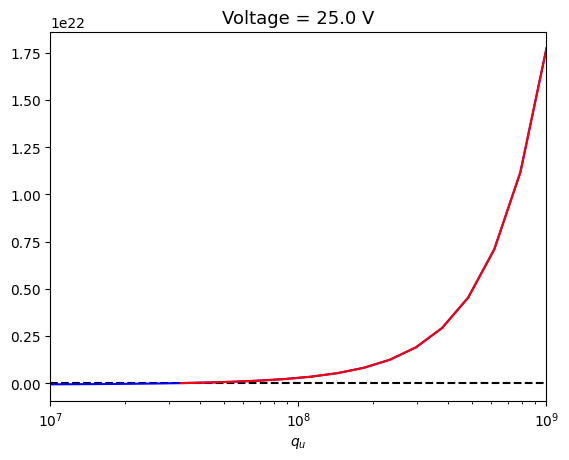

In [20]:
print('Have negative value = ', np.in1d(-1, np.sign(det_M3)))
plt.figure()
plt.title(f'Voltage = {np.round(V_calc, decimals = 2)} V', fontsize = 13)
plt.axhline(0, color='black', linestyle='--')
plt.semilogx(qu_arr, det_M3, color = 'b')
plt.semilogx(qu_arr[np.nonzero(det_M3>=0)], det_M3[np.nonzero(det_M3>=0)], color = 'r')
plt.xlabel('$q_u$')
#plt.legend(fontsize = 10)
plt.xlim(qu_arr[0], qu_arr[-1])
plt.show()

## 50V

Have negative value =  [ True]


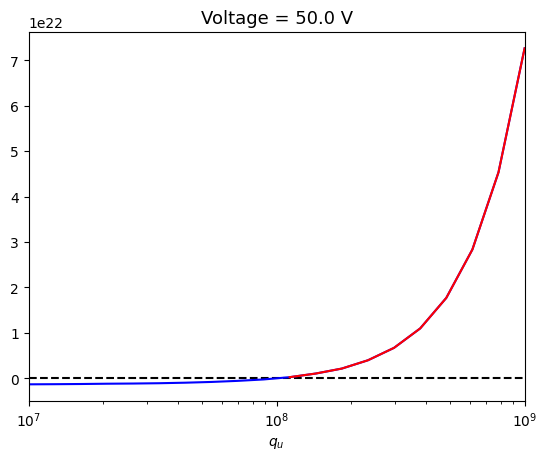

In [6]:
print('Have negative value = ', np.in1d(-1, np.sign(det_M3)))
plt.figure()
plt.title(f'Voltage = {np.round(V_calc, decimals = 2)} V', fontsize = 13)
plt.axhline(0, color='black', linestyle='--')
plt.semilogx(qu_arr, det_M3, color = 'b')
plt.semilogx(qu_arr[np.nonzero(det_M3>=0)], det_M3[np.nonzero(det_M3>=0)], color = 'r')
plt.xlabel('$q_u$')
#plt.legend(fontsize = 10)
plt.xlim(qu_arr[0], qu_arr[-1])
plt.show()


## 100V

Have negative value =  [ True]


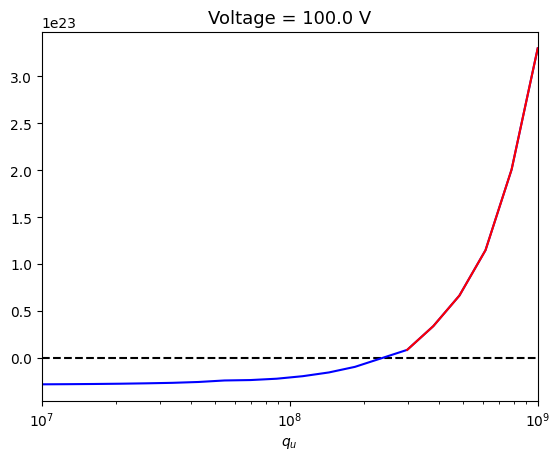

In [25]:
print('Have negative value = ', np.in1d(-1, np.sign(det_M3)))
plt.figure()
plt.title(f'Voltage = {np.round(V_calc, decimals = 2)} V', fontsize = 13)
plt.axhline(0, color='black', linestyle='--')
plt.semilogx(qu_arr, det_M3, color = 'b')
plt.semilogx(qu_arr[np.nonzero(det_M3>=0)], det_M3[np.nonzero(det_M3>=0)], color = 'r')
plt.xlabel('$q_u$')
#plt.legend(fontsize = 10)
plt.xlim(qu_arr[0], qu_arr[-1])
plt.show()


## 150V

Have negative value = [ True]


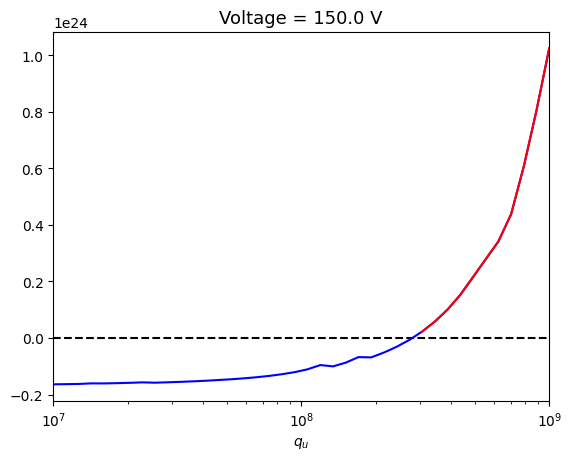

In [44]:
#150V
print('Have negative value =', np.in1d(-1, np.sign(det_M3)))
plt.figure()
plt.title(f'Voltage = {np.round(V_calc, decimals = 2)} V', fontsize = 13)
plt.axhline(0, color='black', linestyle='--')
plt.semilogx(qu_arr, det_M3, color = 'b')
plt.semilogx(qu_arr[np.nonzero(det_M3>0)], det_M3[np.nonzero(det_M3>0)], color = 'r')
plt.xlabel('$q_u$')
#plt.legend(fontsize = 10)
plt.xlim(qu_arr[0], qu_arr[-1])
plt.show()

## 200V

Have negative value = [ True]


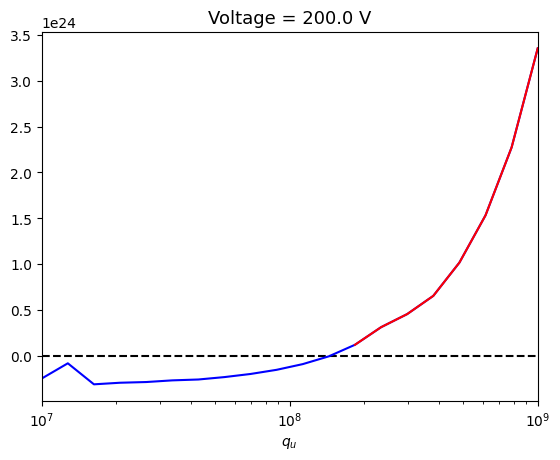

In [9]:
print('Have negative value =', np.in1d(-1, np.sign(det_M3)))
plt.figure()
plt.title(f'Voltage = {np.round(V_calc, decimals = 2)} V', fontsize = 13)
plt.axhline(0, color='black', linestyle='--')
plt.semilogx(qu_arr, det_M3, color = 'b')
plt.semilogx(qu_arr[np.nonzero(det_M3>0)], det_M3[np.nonzero(det_M3>0)], color = 'r')
plt.xlabel('$q_u$')
#plt.legend(fontsize = 10)
plt.xlim(qu_arr[0], qu_arr[-1])
plt.show()

## $\frac{d}{dz}(T^{5/2}\frac{dT}{dz}) = -K^2T^{-3/2}-\alpha T^{\beta}$

In [ ]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
from scipy.optimize import root_scalar
import time
import warnings
import math
from scipy.integrate import simpson
from scipy.interpolate import interp1d

#warnings.filterwarnings("ignore", category=RuntimeWarning)
def ini_guess(f_t, z_arr, Lz, qu_input, chi): #ode guess
    guess_arr = np.ones((2, z_arr.size))
    guess_arr[0, :] = f_t + qu_input / chi * (Lz - z_arr)
    guess_arr[1, :] = qu_input / (-chi)
    return guess_arr #y_ini = ini_guess(T_t_input, z_arr_input, Lz)

def my_incredible_ode_solver(T_t_input, z_arr_input, initial_guess, qu_input, K_square, loss1, loss2):
    @nb.jit
    def BC(ya, yb):
        return np.array([yb[0] - f_Z, ya[1] - df0_dz])
    @nb.jit
    def ode(z, y):
        f = y[0] # y1 = f
        df_dz = y[1] # y2 = df/dz
        dy2_dz = -K_square * (7/2 * f)**(-3/7) - loss1 * (7/2 * f)**(2/7 * loss2)
        return [df_dz, dy2_dz]
    
    f_Z = 2/7 * T_t_input**(7/2) # f(Z) = f(T_t)
    df0_dz = qu_input / (-chi_hat) # df(Z)/dz = f(q_u)
    solution = solve_bvp(ode, BC, z_arr_input, initial_guess, max_nodes = 1e6, tol = 1e-5)
    f_arr_output = solution.y[0]
    df_arr_output = solution.y[1]
    T_arr_output = (7/2 * solution.y[0])**(2/7)
    z_arr_input = np.linspace(0, Lz, T_arr_output.size)
    dT_arr_output = solution.y[1]/(T_arr_output**(5/2))
    int_loss = simpson(T_arr_output**(beta), x = z_arr_input)
    
    qt_output = np.sqrt(K_square * chi_hat**2 * (T_arr_output[0]**2 - T_arr_output[-1]**2) + qu_input**2 + 2*loss1/(loss2 + 7/2) * (T_arr_output[0]**(loss2 + 7/2) - T_arr_output[-1]**(loss2 + 7/2)))
    voltage_output = (qt_output - qu_input - loss1/chi_hat*int_loss) / np.sqrt(K_square * chi_hat * sigma_hat)#
    
    return T_arr_output, dT_arr_output, voltage_output, qt_output, f_arr_output, df_arr_output

def g(x):
    return my_incredible_ode_solver(Tt, z_space, y_ini, heat_flux, x, alpha, beta)[2] - V_expected 

def ini_guess_p(value, slope, z): #Linear guess
    guess_arr = np.ones((2, z.size))
    guess_arr[0, :] = value + slope * z
    guess_arr[1, :] = slope
    return guess_arr #y_ini = ini_guess(bc1, (bc2-bc1)/Lz, z_arr_input)
    
def perturbation_ode_solver(f0_input, z_arr_input, initial_guess, chi_input, sigma_input, j_0, loss1, loss2, bc1 = 1, bc2 = 0.1):

    f0_interp = interp1d(np.linspace(0, Lz, f0_input.size), f0_input, kind='cubic', bounds_error=False)
    
    def BC_perturbation(ya, yb):
        return np.array([ya[0] - bc1, yb[0] - bc2])
    def ode_perturbation(z, y):
        f1 = y[0] # y1 = f
        df_dz = y[1] # y2 = df/dz
        #f0 = np.interp(np.linspace(0, 1, f1.size), np.linspace(0, 1, f0_input.size), f0_input, left=f0_input[0], right=f0_input[-1])
        f0 = f0_interp(z)
        df2_dz = (-3/2 * j_0**2/sigma_input * (7/2)**(-10/7) * f0**(-10/7) * f1 - loss1/2 * (7/2)**(2/7*loss2) * f0**(2/7*loss2) - loss1 * loss2 * (7/2)**(2/7*loss2 - 1) * f0**(2/7*loss2 - 1) * f1) / -chi_input
        return [df_dz, df2_dz]
    
    solution = solve_bvp(ode_perturbation, BC_perturbation, z_arr_input, initial_guess, max_nodes = 1e6, tol = 1e-3)
    (solution.message != 'The algorithm converged to the desired accuracy.') and print(solution.message)
    return solution.y[0], solution.y[1]

@nb.jit
def calculator_detM(T0_arr, T1_arr, T2_arr, deri1, deri2, int1, int2, int3, int4, qt, qu, voltage, j0, sigma, chi, alpha, beta):
    #int1 = sigma_hat * V_calc / j0
    #int2 = simpson(T_arr**(beta), x = z_space) # int of T_arr**beta
    int_pm1 = 2/3 * chi*sigma/j0**2 * (deri1[-1] - deri1[0]) - alpha/3 * sigma/j0**2 * int2 - 2/3 * alpha * beta * sigma/j0**2 * int3
    int_pm2 = 2/3 * chi*sigma/j0**2 * (deri2[-1] - deri2[0]) - alpha/3 * sigma/j0**2 * int2 - 2/3 * alpha * beta * sigma/j0**2 * int4

    M11 = 2 * j0/sigma * int1
    M12 = -(5 * j0**2/sigma * int1 + alpha * beta * int2) 

    M21 = int1
    M22 = -3/2 * j0 * int1
    M23 = -3/2 * j0 * int_pm1
    M24 = -3/2 * j0 * int_pm2

    M32 = 7/2 * qu
    M33 = -chi * deri1[0]
    M34 = -chi * deri2[0]
    M42 = 3 * qt
    M43 = -chi * deri1[-1] - 1/2 * T1_arr[-1]/T0_arr[-1] * qt
    M44 = -chi * deri2[-1] - 1/2 * T2_arr[-1]/T0_arr[-1] * qt
    Matrix = np.array([[M11, M12, 0, 0],
                    [M21, M22, M23, M24],
                    [0, M32, M33, M34,],
                    [0, M42, M43, M44]])

    return np.linalg.det(Matrix), Matrix

K_sqr_ini = 1e4
Lz = 50.0 # [m]
m = 1.67e-27# [kg] 
gamma_hat = 7.0 * np.sqrt(2/m)
e = 1.60218e-19 # [C]
V_expected = 25 # [V]
Tt = 100 # [eV]
epsilon0 = 8.8541878188e-12
me = 9.1093837015e-31
coulomb_log = 13
chi_hat = 9.6 * ((2 * np.pi)**(3/2) * epsilon0**2) / (me**(1/2) * e**(1/2) * coulomb_log) # [W/m eV^-7/2]
sigma_hat = 0.6125 * chi_hat

alpha = 1 # Loss multiplier
beta = 3/2 # Loss exp

N = int(20)
N_nodes = int(1e4)
qu_arr = np.logspace(7, 9, N)
N = qu_arr.size
z_arr = np.linspace(0, Lz, N_nodes)
y_ini = np.zeros((2, N_nodes))
Tu_arr = np.zeros(N); qt_arr = np.zeros(N); nt_arr = np.zeros(N); nu_arr = np.zeros(N); K_arr = np.zeros(N)
M = np.zeros((qu_arr.size, 4, 4))
det_M = np.zeros(N)
K_arr[-1] = K_sqr_ini

y_ini = ini_guess(Tt, z_arr, Lz, qu_arr[0], chi_hat)
z_space = z_arr
start_time = time.time()

for i in range(N):
    heat_flux = qu_arr[i]
    T_arr = np.zeros((N_nodes)); f_arr = np.zeros((N_nodes)); dT_arr = np.zeros((N_nodes)); df_arr = np.zeros((N_nodes))
    result = root_scalar(g, x0=K_arr[i-1], method='secant') #root_scalar(g, x0=K_sqr_ini, method='secant')
    if math.isnan(result.root) or (result.root==0):
        print('Break error in index = ', i)
        break
    K_arr[i] = result.root
    T_arr, dT_arr, V_calc, qt, f_arr, df_arr = my_incredible_ode_solver(Tt, z_space, y_ini, heat_flux, result.root, alpha, beta)
    y_ini = np.array([f_arr, df_arr])
    z_space = np.linspace(0, Lz, f_arr.size)
    Tu_arr[i] = T_arr[0]
    qt_arr[i] = qt
    nt_arr[i] = qt / (gamma_hat * (e * Tt)**(3/2) * 1e18)
    
    if i==0:
        yp_ini1 = ini_guess_p(T_arr[-1]**(5/2)*1, (T_arr[-1]**(5/2)*1-T_arr[-1]**(5/2)*1)/Lz, z_space)
        yp_ini2 = ini_guess_p(T_arr[-1]**(5/2)*1, (T_arr[-1]**(5/2)*-1-T_arr[-1]**(5/2)*1)/Lz, z_space)
    
    yp_ini1[0] = np.interp(np.linspace(0, 1, f_arr.size), np.linspace(0, 1, yp_ini1[0].size), yp_ini1[0])
    yp_ini1[1] = np.interp(np.linspace(0, 1, f_arr.size), np.linspace(0, 1, yp_ini1[1].size), yp_ini1[1])
    yp_ini2[0] = np.interp(np.linspace(0, 1, f_arr.size), np.linspace(0, 1, yp_ini2[0].size), yp_ini2[0])
    yp_ini2[1] = np.interp(np.linspace(0, 1, f_arr.size), np.linspace(0, 1, yp_ini2[1].size), yp_ini2[1])

    j0 = np.sqrt(result.root * chi_hat * sigma_hat)
    T_plus, dT_plus = perturbation_ode_solver(f_arr, z_space, yp_ini1, chi_hat, sigma_hat, j0, alpha, beta, T_arr[0]**(5/2)*1, T_arr[-1]**(5/2)*1)
    T_minus, dT_minus = perturbation_ode_solver(f_arr, z_space, yp_ini2, chi_hat, sigma_hat, j0, alpha, beta, T_arr[0]**(5/2)*1, T_arr[-1]**(5/2)*-1)

    yp_ini1 = np.array([T_plus, dT_plus])
    yp_ini2 = np.array([T_minus, dT_minus])
    T_plus = np.interp(np.linspace(0, 1, T_arr.size), np.linspace(0, 1, T_plus.size), T_plus)
    T_minus = np.interp(np.linspace(0, 1, T_arr.size), np.linspace(0, 1, T_minus.size), T_minus)
    dT_plus = np.interp(np.linspace(0, 1, T_arr.size), np.linspace(0, 1, dT_plus.size), dT_plus)
    dT_minus = np.interp(np.linspace(0, 1, T_arr.size), np.linspace(0, 1, dT_minus.size), dT_minus)

    T_plus = T_plus / T_arr**(5/2)
    T_minus = T_minus / T_arr**(5/2)

    int1 = sigma_hat * V_calc / j0
    int2 = simpson(T_arr**(beta), x = z_space) # int of T_arr**beta
    int3 = simpson(T_arr**(beta-1) * T_plus, x = z_space)
    int4 = simpson(T_arr**(beta-1) * T_minus, x = z_space)
    
    #(T0_arr, T1_arr, T2_arr, deri1, deri2, int1, int2, int3, int4, qt, qu, voltage, j0, sigma, chi, alpha, beta)
    det_M[i], M[i] = calculator_detM(T_arr, T_plus, T_minus, dT_plus, dT_minus, int1, int2, int3, int4, qt, heat_flux, V_calc, j0, sigma_hat, chi_hat, alpha, beta)
    
    result.clear()

end_time = time.time()
print(f'Loop time = {(end_time - start_time):.6f} s')
nu_arr = 2*nt_arr*Tt/Tu_arr

Loop time = 107.894512 s


Have negative value =  [ True]
[-1.13347903e+21 -1.12685052e+21 -1.11623570e+21 -1.10237006e+21
 -1.08415541e+21 -1.06006823e+21 -1.02797248e+21 -9.84837047e+20
 -9.26317631e+20 -8.46129443e+20 -7.35109089e+20 -5.79812316e+20
 -3.60420421e+20 -4.76193950e+19  4.02054919e+20  1.05315739e+21
  2.00170044e+21  3.39066385e+21  5.43324180e+21  8.44774509e+21]


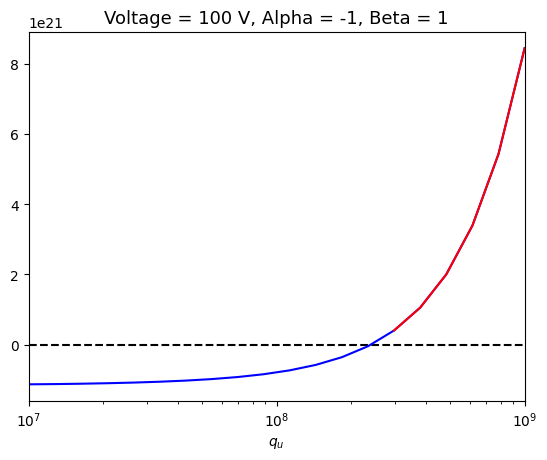

In [ ]:
print('Have negative value = ', np.in1d(-1, np.sign(det_M)))
print(det_M)
plt.figure()
plt.title(f'Voltage = {V_expected} V, Alpha = {alpha}, Beta = {beta}', fontsize = 13)
plt.axhline(0, color='black', linestyle='--')
plt.semilogx(qu_arr, det_M, color = 'b')
plt.semilogx(qu_arr[np.nonzero(det_M>0)], det_M[np.nonzero(det_M>0)], color = 'r')
plt.xlabel('$q_u$')
#plt.legend(fontsize = 10)
plt.xlim(qu_arr[0], qu_arr[-1])
plt.show()

Have negative value =  [ True]
[-1.08051458e+21 -1.07211174e+21 -1.06125657e+21 -1.04647764e+21
 -1.02612202e+21 -1.00046000e+21 -9.59516302e+20 -8.91499548e+20
 -8.65384280e+20 -8.02210856e+20 -6.93458558e+20 -5.40820370e+20
 -3.24527617e+20 -1.53325359e+19  2.77475387e+20  1.05240672e+21
  1.98122357e+21  3.26807667e+21  5.43173121e+21  8.43793775e+21]


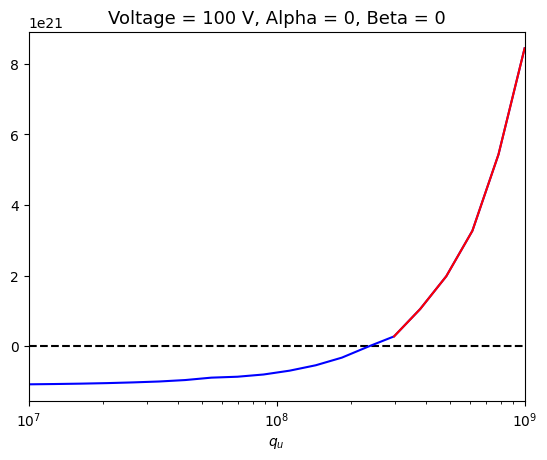

In [ ]:
print('Have negative value = ', np.in1d(-1, np.sign(det_M)))
print(det_M)
plt.figure()
plt.title(f'Voltage = {V_expected} V, Alpha = {alpha}, Beta = {beta}', fontsize = 13)
plt.axhline(0, color='black', linestyle='--')
plt.semilogx(qu_arr, det_M, color = 'b')
plt.semilogx(qu_arr[np.nonzero(det_M>0)], det_M[np.nonzero(det_M>0)], color = 'r')
plt.xlabel('$q_u$')
#plt.legend(fontsize = 10)
plt.xlim(qu_arr[0], qu_arr[-1])
plt.show()

Have negative value =  [ True]
[-1.00533593e+22 -1.00341803e+22 -9.93701549e+21 -9.81177646e+21
 -9.64988987e+21 -9.43990170e+21 -9.16637241e+21 -8.80828291e+21
 -8.33674346e+21 -7.71160399e+21 -6.87651455e+21 -5.75162588e+21
 -4.22281475e+21 -2.12576292e+21  7.77576560e+20  4.83374839e+21
  1.05492586e+22  1.86667608e+22  3.02781205e+22  4.69925583e+22]


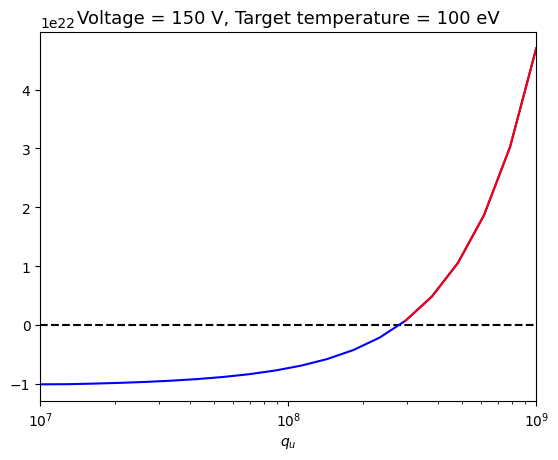

In [55]:
print('Have negative value = ', np.in1d(-1, np.sign(det_M)))
print(det_M)
plt.figure()
plt.title(f'Voltage = {V_expected} V, Target temperature = {Tt} eV', fontsize = 13)
plt.axhline(0, color='black', linestyle='--')
plt.semilogx(qu_arr, det_M, color = 'b')
plt.semilogx(qu_arr[np.nonzero(det_M>0)], det_M[np.nonzero(det_M>0)], color = 'r')
plt.xlabel('$q_u$')
#plt.legend(fontsize = 10)
plt.xlim(qu_arr[0], qu_arr[-1])
plt.show()

Have negative value =  [ True]
[-5.73932324e+18 -5.11716319e+18 -4.24954455e+18 -3.10424893e+18
 -1.58116568e+18  4.61430980e+17  3.22641461e+18  7.00717362e+18
  1.22318432e+19  1.95300121e+19  2.98333638e+19  4.45275445e+19
  6.56813695e+19  9.63928523e+19  1.41311821e+20  2.07429631e+20
  3.05273063e+20  4.50710063e+20  6.67681831e+20  9.92337612e+20]


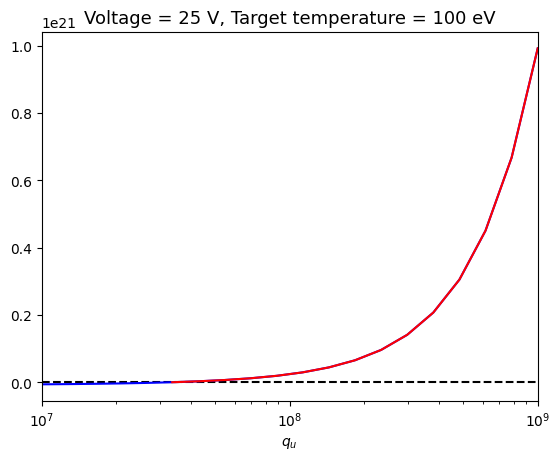

In [53]:
print('Have negative value = ', np.in1d(-1, np.sign(det_M)))
print(det_M)
plt.figure()
plt.title(f'Voltage = {V_expected} V, Target temperature = {Tt} eV', fontsize = 13)
plt.axhline(0, color='black', linestyle='--')
plt.semilogx(qu_arr, det_M, color = 'b')
plt.semilogx(qu_arr[np.nonzero(det_M>0)], det_M[np.nonzero(det_M>0)], color = 'r')
plt.xlabel('$q_u$')
#plt.legend(fontsize = 10)
plt.xlim(qu_arr[0], qu_arr[-1])
plt.show()

Have negative value =  [False]
[2.09355593e+18 2.53238196e+18 3.11070693e+18 3.88398671e+18
 4.93514183e+18 6.38834195e+18 8.42879386e+18 1.13311621e+19
 1.55010034e+19 2.15363941e+19 3.03210990e+19 4.31666103e+19
 6.20291192e+19 8.98405136e+19 1.31012265e+20 1.92201227e+20
 2.83472350e+20 4.20063251e+20 6.25061764e+20 9.33468559e+20]


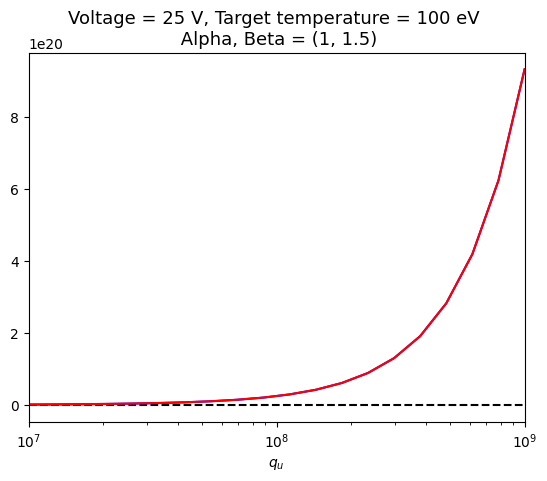

In [2]:
print('Have negative value = ', np.in1d(-1, np.sign(det_M)))
print(det_M)
plt.figure()
plt.title(f'Voltage = {V_expected} V, Target temperature = {Tt} eV \n Alpha, Beta = {alpha, beta}', fontsize = 13)
plt.axhline(0, color='black', linestyle='--')
plt.semilogx(qu_arr, det_M, color = 'b')
plt.semilogx(qu_arr[np.nonzero(det_M>0)], det_M[np.nonzero(det_M>0)], color = 'r')
plt.xlabel('$q_u$')
#plt.legend(fontsize = 10)
plt.xlim(qu_arr[0], qu_arr[-1])
plt.show()

In [ ]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
from scipy.optimize import root_scalar
import time
import warnings
import math
from scipy.integrate import simpson
from scipy.interpolate import interp1d

#warnings.filterwarnings("ignore", category=RuntimeWarning)
def ini_guess(f_t, z_arr, Lz, qu_input, chi): #ode guess
    guess_arr = np.ones((2, z_arr.size))
    guess_arr[0, :] = f_t + qu_input / chi * (Lz - z_arr)
    guess_arr[1, :] = qu_input / (-chi)
    return guess_arr #y_ini = ini_guess(T_t_input, z_arr_input, Lz)

def my_incredible_ode_solver(T_t_input, z_arr_input, initial_guess, qu_input, K_square):
    def BC(ya, yb):
        return np.array([yb[0] - f_Z, ya[1] - df0_dz])
    def ode(z, y):
        f = y[0] # y1 = f
        df_dz = y[1] # y2 = df/dz
        dy2_dz = -K_square * (7/2 * f)**(-3/7)
        return [df_dz, dy2_dz]
    def ini_guess(f_t, z_arr, Lz): #Linear guess
        guess_arr = np.ones((2, z_arr.size))
        guess_arr[0, :] = f_t + qu_input / chi_hat * (Lz - z_arr)
        guess_arr[1, :] = qu_input / (-chi_hat)
        return guess_arr

    f_Z = 2/7 * T_t_input**(7/2) # f(Z) = f(T_t)
    df0_dz = qu_input / (-chi_hat) # df(Z)/dz = f(q_u)
    y_ini = ini_guess(T_t_input, z_arr_input, Lz)
    solution = solve_bvp(ode, BC, z_arr_input, initial_guess, max_nodes = 1e6, tol = 1e-5)
    f_arr_output = solution.y[0]
    T_arr_output = (7/2 * solution.y[0])**(2/7)
    dT_arr_output = solution.y[1]/(T_arr_output**(5/2))
    
    qt_output = np.sqrt(K_square * chi_hat**2 * (T_arr_output[0]**2 - T_arr_output[-1]**2) + qu_input**2)
    voltage_output = (qt_output-qu_input) / np.sqrt(K_square * chi_hat * sigma_hat)
    
    return T_arr_output, dT_arr_output, voltage_output, qt_output, f_arr_output

def g(x):
    return my_incredible_ode_solver(Tt, z_space, y_ini, heat_flux, x, alpha, beta)[2] - V_expected 

def ini_guess_p(value, slope, z): #Linear guess
    guess_arr = np.ones((2, z.size))
    guess_arr[0, :] = value + slope * z
    guess_arr[1, :] = slope
    return guess_arr #y_ini = ini_guess(bc1, (bc2-bc1)/Lz, z_arr_input)
    
def perturbation_ode_solver(f0_input, z_arr_input, initial_guess, chi_input, sigma_input, j_0, loss1, loss2, bc1 = 1, bc2 = 0.1):

    f0_interp = interp1d(np.linspace(0, Lz, f0_input.size), f0_input, kind='cubic', bounds_error=False)
    
    def BC_perturbation(ya, yb):
        return np.array([ya[0] - bc1, yb[0] - bc2])
    def ode_perturbation(z, y):
        f1 = y[0] # y1 = f
        df_dz = y[1] # y2 = df/dz
        #f0 = np.interp(np.linspace(0, 1, f1.size), np.linspace(0, 1, f0_input.size), f0_input, left=f0_input[0], right=f0_input[-1])
        f0 = f0_interp(z)
        df2_dz = (-3/2 * j_0**2/sigma_input * (7/2)**(-10/7) * f0**(-10/7) * f1 - loss1/2 * (7/2)**(2/7*loss2) * f0**(2/7*loss2) - loss1 * loss2 * (7/2)**(2/7*loss2 - 1) * f0**(2/7*loss2 - 1) * f1) / -chi_input
        return [df_dz, df2_dz]
    
    solution = solve_bvp(ode_perturbation, BC_perturbation, z_arr_input, initial_guess, max_nodes = 1e6, tol = 1e-3)
    (solution.message != 'The algorithm converged to the desired accuracy.') and print(solution.message)
    return solution.y[0], solution.y[1]

@nb.jit
def calculator_detM(T0_arr, T1_arr, T2_arr, deri1, deri2, int1, int2, int3, int4, qt, qu, voltage, j0, sigma, chi, alpha, beta):
    #int1 = sigma_hat * V_calc / j0
    #int2 = simpson(T_arr**(beta), x = z_space) # int of T_arr**beta
    int_pm1 = 2/3 * chi*sigma/j0**2 * (deri1[-1] - deri1[0]) - alpha/3 * sigma/j0**2 * int2 - 2/3 * alpha * beta * sigma/j0**2 * int3
    int_pm2 = 2/3 * chi*sigma/j0**2 * (deri2[-1] - deri2[0]) - alpha/3 * sigma/j0**2 * int2 - 2/3 * alpha * beta * sigma/j0**2 * int4

    M11 = 2 * j0/sigma * int1
    M12 = -(5 * j0**2/sigma * int1 + alpha * beta * int2) 

    M21 = int1
    M22 = -3/2 * j0 * int1
    M23 = -3/2 * j0 * int_pm1
    M24 = -3/2 * j0 * int_pm2

    M32 = 7/2 * qu
    M33 = -chi * deri1[0]
    M34 = -chi * deri2[0]
    M42 = 3 * qt
    M43 = -chi * deri1[-1] - 1/2 * T1_arr[-1]/T0_arr[-1] * qt
    M44 = -chi * deri2[-1] - 1/2 * T2_arr[-1]/T0_arr[-1] * qt
    Matrix = np.array([[M11, M12, 0, 0],
                    [M21, M22, M23, M24],
                    [0, M32, M33, M34,],
                    [0, M42, M43, M44]])

    return np.linalg.det(Matrix), Matrix

K_sqr_ini = 1e4
Lz = 50.0 # [m]
m = 1.67e-27# [kg] 
gamma_hat = 7.0 * np.sqrt(2/m)
e = 1.60218e-19 # [C]
V_expected = 90 # [V]
Tt = 100 # [eV]
epsilon0 = 8.8541878188e-12
me = 9.1093837015e-31
coulomb_log = 13
chi_hat = 9.6 * ((2 * np.pi)**(3/2) * epsilon0**2) / (me**(1/2) * e**(1/2) * coulomb_log) # [W/m eV^-7/2]
sigma_hat = 0.6125 * chi_hat

alpha = 0 # Loss multiplier
beta = 0 # Loss exp

N = int(40)
N_nodes = int(1e4)
qu_arr = np.logspace(7, 9, N)
N = qu_arr.size
z_arr = np.linspace(0, Lz, N_nodes)
y_ini = np.zeros((2, N_nodes))
Tu_arr = np.zeros(N); qt_arr = np.zeros(N); nt_arr = np.zeros(N); nu_arr = np.zeros(N); K_arr = np.zeros(N)
p1 = np.zeros(N); p2 = np.zeros(N);
M = np.zeros((qu_arr.size, 4, 4))
det_M = np.zeros(N)
K_arr[-1] = K_sqr_ini

y_ini = ini_guess(Tt, z_arr, Lz, qu_arr[0], chi_hat)
z_space = z_arr
start_time = time.time()

for i in range(N):
    heat_flux = qu_arr[i]
    T_arr = np.zeros((N_nodes)); f_arr = np.zeros((N_nodes)); dT_arr = np.zeros((N_nodes)); df_arr = np.zeros((N_nodes))
    result = root_scalar(g, x0=K_arr[i-1], method='secant') #root_scalar(g, x0=K_sqr_ini, method='secant')
    if math.isnan(result.root) or (result.root==0):
        print('Break error in index = ', i)
        break
    K_arr[i] = result.root
    T_arr, dT_arr, V_calc, qt, f_arr, df_arr = my_incredible_ode_solver(Tt, z_space, y_ini, heat_flux, result.root, alpha, beta)
    y_ini = np.array([f_arr, df_arr])
    z_space = np.linspace(0, Lz, f_arr.size)
    Tu_arr[i] = T_arr[0]
    qt_arr[i] = qt
    nt_arr[i] = qt / (gamma_hat * (e * Tt)**(3/2) * 1e18)
    p1[i] = (nt_arr[i] * Tt / heat_flux)**(6/7)
    p2[i] = (V_calc / heat_flux)**(2/7)
    
    if i==0:
        yp_ini1 = ini_guess_p(T_arr[-1]**(5/2)*1, (T_arr[-1]**(5/2)*1-T_arr[-1]**(5/2)*1)/Lz, z_space)
        yp_ini2 = ini_guess_p(T_arr[-1]**(5/2)*1, (T_arr[-1]**(5/2)*-1-T_arr[-1]**(5/2)*1)/Lz, z_space)
    
    yp_ini1[0] = np.interp(np.linspace(0, 1, f_arr.size), np.linspace(0, 1, yp_ini1[0].size), yp_ini1[0])
    yp_ini1[1] = np.interp(np.linspace(0, 1, f_arr.size), np.linspace(0, 1, yp_ini1[1].size), yp_ini1[1])
    yp_ini2[0] = np.interp(np.linspace(0, 1, f_arr.size), np.linspace(0, 1, yp_ini2[0].size), yp_ini2[0])
    yp_ini2[1] = np.interp(np.linspace(0, 1, f_arr.size), np.linspace(0, 1, yp_ini2[1].size), yp_ini2[1])

    j0 = np.sqrt(result.root * chi_hat * sigma_hat)
    T_plus, dT_plus = perturbation_ode_solver(f_arr, z_space, yp_ini1, chi_hat, sigma_hat, j0, alpha, beta, T_arr[0]**(5/2)*1, T_arr[-1]**(5/2)*1)
    T_minus, dT_minus = perturbation_ode_solver(f_arr, z_space, yp_ini2, chi_hat, sigma_hat, j0, alpha, beta, T_arr[0]**(5/2)*1, T_arr[-1]**(5/2)*-1)

    yp_ini1 = np.array([T_plus, dT_plus])
    yp_ini2 = np.array([T_minus, dT_minus])
    T_plus = np.interp(np.linspace(0, 1, T_arr.size), np.linspace(0, 1, T_plus.size), T_plus)
    T_minus = np.interp(np.linspace(0, 1, T_arr.size), np.linspace(0, 1, T_minus.size), T_minus)
    dT_plus = np.interp(np.linspace(0, 1, T_arr.size), np.linspace(0, 1, dT_plus.size), dT_plus)
    dT_minus = np.interp(np.linspace(0, 1, T_arr.size), np.linspace(0, 1, dT_minus.size), dT_minus)

    T_plus = T_plus / T_arr**(5/2)
    T_minus = T_minus / T_arr**(5/2)

    int1 = sigma_hat * V_calc / j0
    int2 = simpson(T_arr**(beta), x = z_space) # int of T_arr**beta
    int3 = simpson(T_arr**(beta-1) * T_plus, x = z_space)
    int4 = simpson(T_arr**(beta-1) * T_minus, x = z_space)
    
    #(T0_arr, T1_arr, T2_arr, deri1, deri2, int1, int2, int3, int4, qt, qu, voltage, j0, sigma, chi, alpha, beta)
    det_M[i], M[i] = calculator_detM(T_arr, T_plus, T_minus, dT_plus, dT_minus, int1, int2, int3, int4, qt, heat_flux, V_calc, j0, sigma_hat, chi_hat, alpha, beta)
    
    result.clear()

end_time = time.time()
print(f'Loop time = {(end_time - start_time):.6f} s')
nu_arr = 2*nt_arr*Tt/Tu_arr

Loop time = 323.485303 s


## Scan(?) in parametric space

In [511]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
from scipy.optimize import root_scalar
import time
import warnings
import math
from scipy.integrate import simpson
from scipy.interpolate import interp1d

#warnings.filterwarnings("ignore", category=RuntimeWarning)
@nb.jit
def ini_guess(f_t, z_arr, Lz, qu_input, chi): #ode guess
    guess_arr = np.ones((2, z_arr.size))
    guess_arr[0, :] = f_t + qu_input / chi * (Lz - z_arr)
    guess_arr[1, :] = qu_input / (-chi)
    return guess_arr #y_ini = ini_guess(T_t_input, z_arr_input, Lz)

def my_incredible_ode_solver(T_t_input, z_arr_input, initial_guess, qu_input, K_square):
    def BC(ya, yb):
        return np.array([yb[0] - f_Z, ya[1] - df0_dz])
    def ode(z, y):
        f = y[0] # y1 = f
        df_dz = y[1] # y2 = df/dz
        dy2_dz = -K_square * (7/2 * f)**(-3/7)
        return [df_dz, dy2_dz]
    def ini_guess(f_t, z_arr, Lz): #Linear guess
        guess_arr = np.ones((2, z_arr.size))
        guess_arr[0, :] = f_t + qu_input / chi_hat * (Lz - z_arr)
        guess_arr[1, :] = qu_input / (-chi_hat)
        return guess_arr

    f_Z = 2/7 * T_t_input**(7/2) # f(Z) = f(T_t)
    df0_dz = qu_input / (-chi_hat) # df(Z)/dz = f(q_u)
    y_ini = ini_guess(T_t_input, z_arr_input, Lz)
    solution = solve_bvp(ode, BC, z_arr_input, initial_guess, max_nodes = 1e6, tol = 1e-5)
    f_arr_output = solution.y[0]
    df_arr_output = solution.y[1]
    T_arr_output = (7/2 * solution.y[0])**(2/7)
    dT_arr_output = solution.y[1]/(T_arr_output**(5/2))
    qt_output = np.sqrt(K_square * chi_hat**2 * (T_arr_output[0]**2 - T_arr_output[-1]**2) + qu_input**2)
    voltage_output = (qt_output-qu_input) / np.sqrt(K_square * chi_hat * sigma_hat)
    
    return T_arr_output, dT_arr_output, voltage_output, qt_output, f_arr_output, df_arr_output

def g(x):
    return my_incredible_ode_solver(Tt, z_space, y_ini, heat_flux, x)[2] - V_expected 

@nb.jit
def ini_guess_p(value, slope, z): #Linear guess
    guess_arr = np.ones((2, z.size))
    guess_arr[0, :] = value + slope * z
    guess_arr[1, :] = slope
    return guess_arr #y_ini = ini_guess(bc1, (bc2-bc1)/Lz, z_arr_input)
    
def perturbation_ode_solver(f0_input, z_arr_input, initial_guess, Ksqr_input, bc1 = 1, bc2 = 1):
    
    f0_interp = interp1d(np.linspace(0, Lz, f0_input.size), f0_input, kind='cubic', bounds_error=False)

    def BC_perturbation(ya, yb):
        return np.array([ya[0] - bc1, yb[0] - bc2])
    def ode_perturbation(z, y):
        f1 = y[0] # y1 = f
        df_dz = y[1] # y2 = df/dz
        #f0 = np.interp(np.linspace(0, 1, f1.size), np.linspace(0, 1, f0_input.size), f0_input, left=f0_input[0], right=f0_input[-1])
        f0 = f0_interp(z)
        df2_dz = 3/2 * Ksqr_input * (7/2)**(-10/7) * f0**(-10/7) * f1
        return [df_dz, df2_dz]
    def ini_guess(value1, slope, z): #Linear guess
        guess_arr = np.ones((2, z.size))
        guess_arr[0] = value1 + slope * z
        guess_arr[1] = slope
        return guess_arr
    
    y_ini = ini_guess(bc1, (bc2-bc1)/Lz, z_arr_input)
    solution = solve_bvp(ode_perturbation, BC_perturbation, z_arr_input, initial_guess, max_nodes = 1e6, tol = 1e-3)
    (solution.message != 'The algorithm converged to the desired accuracy.') and print(solution.message)
    return solution.y[0], solution.y[1]

@nb.jit
def calculator_detM(T0, T_plus, T_minus, dT_plus, dT_minus, qu, qt, chi_input):
    M11 = 7/2 * qu;      M12 = -chi_hat * dT_plus[0];        M13 = -chi_input * dT_minus[0]
    M21 = qt + 5/2 * qu;     M22 = -chi_hat * dT_plus[-1];       M23 = -chi_input * dT_minus[-1]
    M31 = 2 * qt - 5/2 * qu;     M32 = - 1/2 * qt * T_plus[-1]/T0[-1];        M33 = - 1/2 * qt * T_minus[-1]/T0[-1]

    Matrix = np.array([[M21, M22, M23],
                       [M11, M12, M13],
                       [M31, M32, M33]])
    return np.linalg.det(Matrix), Matrix

Lz = 50.0 # [m]
m = 1.67e-27# [kg] 
gamma_hat = 7.0 * np.sqrt(2/m)
e = 1.60218e-19 # [C]
epsilon0 = 8.8541878188e-12
me = 9.1093837015e-31
coulomb_log = 13
chi_hat = 9.6 * ((2 * np.pi)**(3/2) * epsilon0**2) / (me**(1/2) * e**(1/2) * coulomb_log) # [W/m eV^-7/2]
sigma_hat = 0.6125 * chi_hat
Tt = 75 # [eV]
print('T_t =', Tt,'[eV]')

N = int(80)
N_nodes = int(1e4)
z_arr = np.linspace(0, Lz, N_nodes)
#qu_arr = np.concatenate([np.arange(1e6, 1.1e7, 0.5e6), np.arange(1e7, 1.1e8, 0.5e7), np.arange(1e8, 1.1e9, 0.5e8), np.arange(1e9, 1.1e10, 0.5e9)])
#qu_arr = np.concatenate([np.arange(1e5, 1.1e6, 0.5e5), np.arange(1e6, 1.1e7, 0.5e6), np.arange(1e7, 1.1e8, 0.5e7), np.arange(1e8, 1.1e9, 0.5e8)]) #zero arr

#qu_arr = np.concatenate([np.logspace(6, 7, 20)[:-1], np.logspace(7, 8, 20)[:-1], np.logspace(8, 9, 20)[:-1], np.logspace(9, 10, 20)])
#qu_arr = np.concatenate([np.logspace(5, 6, 20)[:-1], np.logspace(6, 7, 20)[:-1], np.logspace(7, 8, 20)[:-1], np.logspace(8, 9, 20)]) #Ksi arr = 40, zero arr = 20
qu_arr = np.concatenate([np.logspace(5, 6, 40)[:-1], np.logspace(6, 7, 40)[:-1], np.logspace(7, 8, 40)[:-1], np.logspace(8, 9, 40)]) #Ksi arr = 40, zero arr = 20
N = qu_arr.size
#qu_arr = np.logspace(6, 10, N)

#voltage_arr = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]) #100eV
voltage_arr = np.array([125, 137.5, 150, 160, 162.5, 165, 166, 166.5]) #Low Tt 75
#voltage_arr = np.array([2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 25]) #High Tt 500
#voltage_arr = np.array([2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 25, 30, 35, 40, 45, 50]) #High Tt 300

#voltage_arr = np.array([125, 150, 155, 157.5, 160, 162.5, 165, 167.5, 170]) #Test_arr
Nv = voltage_arr.size

x_parameter = np.zeros((Nv)); y_parameter = np.zeros((Nv)); z_parameter = np.zeros((Nv)); w_parameter = np.zeros((Nv))
instability_x = np.zeros((Nv)); instability_y = np.zeros((Nv))
stability_x = np.zeros((Nv)); stability_y = np.zeros((Nv))
stability_pack = np.zeros((4, Nv))

i_start = 0
K_sqr_ini = 5e6
K_sqr = K_sqr_ini
print('Ksqr = ', K_sqr)
print('Initial calculated voltage =', my_incredible_ode_solver(Tt, z_arr, ini_guess(Tt, z_arr, Lz, qu_arr[0], chi_hat), qu_arr[0], K_sqr_ini)[2], '[V]')

for v in range(Nv):
    V_expected = voltage_arr[v]

    z_space = z_arr
    qt_arr = np.zeros(N); nt_arr = np.zeros(N); Tu_arr = np.zeros(N);
    p1 = np.zeros(N); p2 = np.zeros(N); p3 = np.zeros(N); p4 = np.zeros(N);
    M = np.zeros((N, 3, 3))
    det_M = np.zeros(N)

    y_ini = np.zeros((2, N_nodes))
    y_ini = ini_guess(Tt, z_arr, Lz, qu_arr[0], chi_hat)
    start_time = time.time()
    for i in range(i_start, N):
        heat_flux = qu_arr[i]
        T_arr = np.zeros((N_nodes)); f_arr = np.zeros((N_nodes)); dT_arr = np.zeros((N_nodes)); df_arr = np.zeros((N_nodes))
        result = root_scalar(g, x0=K_sqr, method='secant', rtol = 1e-5) #root_scalar(g, x0=K_sqr_ini, method='secant')
        if math.isnan(result.root) or (result.root==0):
            print('Break error in index = ', i)
            break
        K_sqr = result.root
        T_arr, dT_arr, V_calc, qt, f_arr, df_arr = my_incredible_ode_solver(Tt, z_space, y_ini, heat_flux, result.root)
        y_ini = np.array([f_arr, df_arr])
        z_space = np.linspace(0, Lz, f_arr.size)
        Tu_arr[i] = T_arr[0]
        qt_arr[i] = qt
        nt_arr[i] = qt / (gamma_hat * (e * Tt)**(3/2))
        p1[i] = (nt_arr[i] * Tt) / heat_flux**(6/7)
        p2[i] = V_calc / heat_flux**(2/7)
        p3[i] = V_calc/Tt
        p4[i] = heat_flux/Tt**(7/2)
        
        if i==0:
            yp_ini1 = ini_guess_p(T_arr[-1]**(5/2)*1, (T_arr[-1]**(5/2)*1-T_arr[-1]**(5/2)*1)/Lz, z_space)
            yp_ini2 = ini_guess_p(T_arr[-1]**(5/2)*1, (T_arr[-1]**(5/2)*-1-T_arr[-1]**(5/2)*1)/Lz, z_space)
        
        yp_ini1 = [np.interp(np.linspace(0, 1, f_arr.size), np.linspace(0, 1, yp_ini1[0].size), yp_ini1[0]), np.interp(np.linspace(0, 1, f_arr.size), np.linspace(0, 1, yp_ini1[1].size), yp_ini1[1])]
        yp_ini2 = [np.interp(np.linspace(0, 1, f_arr.size), np.linspace(0, 1, yp_ini2[0].size), yp_ini2[0]), np.interp(np.linspace(0, 1, f_arr.size), np.linspace(0, 1, yp_ini2[1].size), yp_ini2[1])]

        j0 = np.sqrt(result.root * chi_hat * sigma_hat)
        T_plus, dT_plus = perturbation_ode_solver(f_arr, z_space, yp_ini1, K_sqr, T_arr[0]**(5/2)*1, T_arr[-1]**(5/2)*1)
        T_minus, dT_minus = perturbation_ode_solver(f_arr, z_space, yp_ini2, K_sqr, T_arr[0]**(5/2)*1, T_arr[-1]**(5/2)*-1)
    
        yp_ini1 = np.array([T_plus, dT_plus])
        yp_ini2 = np.array([T_minus, dT_minus])
        T_plus = np.interp(np.linspace(0, 1, T_arr.size), np.linspace(0, 1, T_plus.size), T_plus)
        T_minus = np.interp(np.linspace(0, 1, T_arr.size), np.linspace(0, 1, T_minus.size), T_minus)
        dT_plus = np.interp(np.linspace(0, 1, T_arr.size), np.linspace(0, 1, dT_plus.size), dT_plus)
        dT_minus = np.interp(np.linspace(0, 1, T_arr.size), np.linspace(0, 1, dT_minus.size), dT_minus)

        T_plus = T_plus / T_arr**(5/2)
        T_minus = T_minus / T_arr**(5/2)
        #detcalc3(T_arr, T_plus, T_minus, dT_plus, dT_minus, heat_flux, qt, chi_hat)
        det_M[i], M[i] = calculator_detM(T_arr, T_plus, T_minus, dT_plus, dT_minus, heat_flux, qt, chi_hat)
        
        if det_M[i_start] > 0:
            print('Stable or Solver crashed')
            break
        elif (det_M[i-1] < 0) and (det_M[i] > 0):
            result.clear()
            break

        result.clear()
    end_time = time.time()
    print('Ksqr = ', K_sqr)
    print(f'Loop time for {V_expected}V = {(end_time - start_time):.6f} s')
    #print(np.nonzero(det_M<0)[0][-1], np.nonzero(det_M>0)[0][0])
    stability_pack[0, v] = V_expected #voltage
    stability_pack[1, v] = (nt_arr[np.nonzero(det_M<0)[0][-1]] + nt_arr[np.nonzero(det_M>0)[0][0]]) * Tt /2 #pressure
    stability_pack[2, v] = (qu_arr[np.nonzero(det_M<0)[0][-1]] + qu_arr[np.nonzero(det_M>0)[0][0]])/2 #heatflux
    Tu = ((Tu_arr[np.nonzero(det_M<0)[0][-1]] + Tu_arr[np.nonzero(det_M>0)[0][0]])/2)
    stability_pack[3, v] = Tt**(7/2) / (Tu**(7/2) - Tt**(7/2)) #ksi

    i_start = np.maximum(np.nonzero(det_M<0)[0][-1]-20, 0)
    x_parameter[v] = (p2[np.nonzero(det_M<0)[0][-1]] + p2[np.nonzero(det_M>0)[0][0]])/2
    y_parameter[v] = (p1[np.nonzero(det_M<0)[0][-1]] + p1[np.nonzero(det_M>0)[0][0]])/2

    z_parameter[v] = (p3[np.nonzero(det_M<0)[0][-1]] + p3[np.nonzero(det_M>0)[0][0]])/2
    w_parameter[v] = (p4[np.nonzero(det_M<0)[0][-1]] + p4[np.nonzero(det_M>0)[0][0]])/2
    

    instability_x[v] = p3[np.nonzero(det_M<0)[0][-1]]
    instability_y[v] = p4[np.nonzero(det_M<0)[0][-1]]
    stability_x[v] = p3[np.nonzero(det_M>0)[0][0]]
    stability_y[v] = p4[np.nonzero(det_M>0)[0][0]]


T_t = 75 [eV]
Ksqr =  5000000.0
Initial calculated voltage = 125.15412446492778 [V]
Ksqr =  6024582.765121802
Loop time for 125.0V = 233.700817 s
Ksqr =  8091922.118653956
Loop time for 137.5V = 47.292572 s
Ksqr =  10645840.98371195
Loop time for 150.0V = 40.300661 s
Ksqr =  13101205.304979134
Loop time for 160.0V = 30.812702 s
Ksqr =  13763777.132888976
Loop time for 162.5V = 41.003633 s
Ksqr =  14461018.116393888
Loop time for 165.0V = 35.698677 s
Ksqr =  14747811.816102337
Loop time for 166.0V = 39.548980 s
Ksqr =  14898237.44067312
Loop time for 166.5V = 42.372245 s


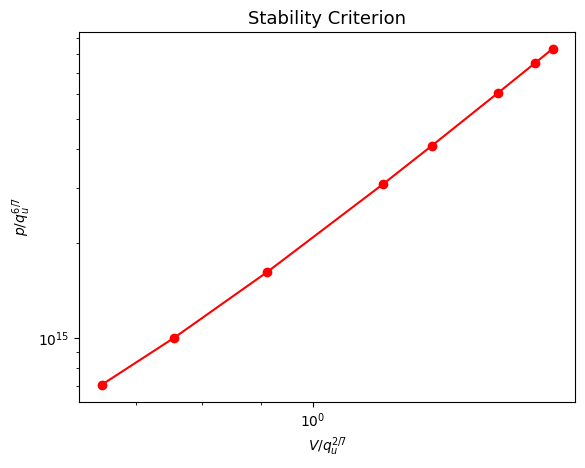

In [512]:
plt.loglog(x_parameter, y_parameter, color = 'r', marker = 'o')
#plt.loglog((y_parameter)**(3/2)/1e18, y_parameter, color = 'b', marker = 'o')
#plt.scatter(x_parameter[-2], y_parameter[-2], color='b', marker='x')
plt.title('Stability Criterion', fontsize=13)
plt.ylabel('$p/q_u^{6/7}$')
plt.xlabel('$V/q_u^{2/7}$')
plt.show()

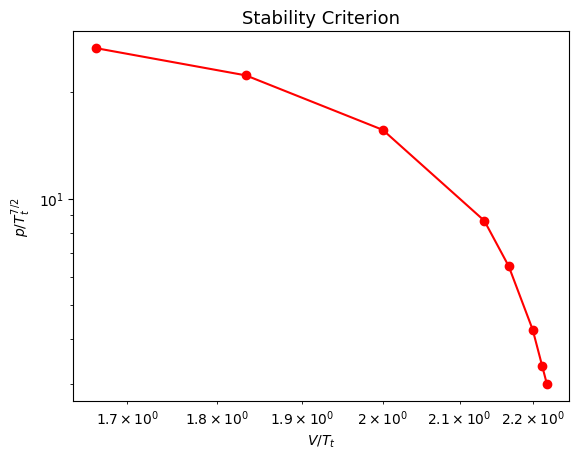

In [513]:
plt.loglog(z_parameter, w_parameter, color = 'r', marker = 'o')
#plt.loglog((y_parameter)**(3/2)/1e18, y_parameter, color = 'b', marker = 'o')
#plt.scatter(x_parameter[5], y_parameter[5], color='b', marker='x')
plt.title('Stability Criterion', fontsize=13)
plt.ylabel('$p/T_t^{7/2}$')
plt.xlabel('$V/T_t$')
plt.show()

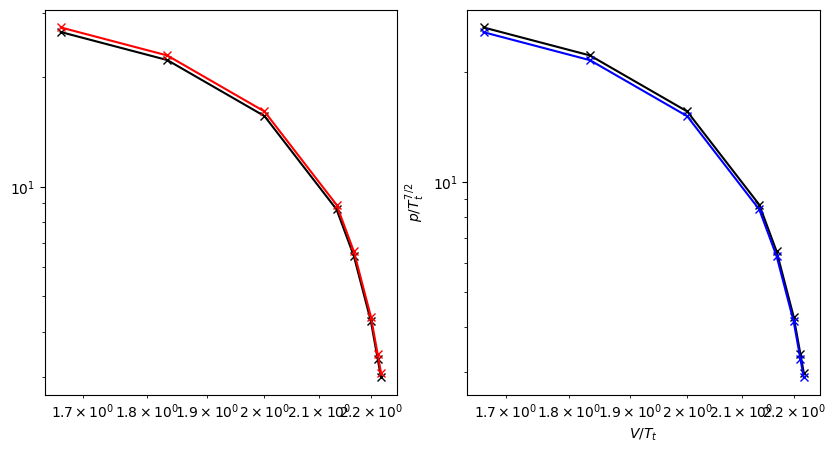

In [514]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.loglog(z_parameter[:], w_parameter[:], color='black', marker='x')
plt.loglog(stability_x[:], stability_y[:], color='r', marker='x')

plt.subplot(1, 2, 2)
plt.loglog(z_parameter[:], w_parameter[:], color='black', marker='x')
plt.loglog(instability_x[:], instability_y[:], color='b', marker='x')

#plt.scatter(x_parameter[5], y_parameter[5] * 1e18, color='b', marker='x')

#plt.title('Stability Criterion', fontsize=13)
plt.ylabel('$p/T_t^{7/2}$')
plt.xlabel('$V/T_t$')
plt.show()

In [ ]:
#1 Tt = 50
np.savez(
    'parameters1.npz',
    T=Tt,
    x=x_parameter,
    y=y_parameter,
    stability=stability_pack,
    inst_x=instability_x,
    inst_y=instability_y,
    st_x=stability_x,
    st_y=stability_y,
)

In [419]:
#2 Tt = 500
np.savez(
    'parameters2.npz',
    T=Tt,
    x=x_parameter,
    y=y_parameter,
    z=z_parameter,
    w=w_parameter,
    stability=stability_pack,
    inst_x=instability_x,
    inst_y=instability_y,
    st_x=stability_x,
    st_y=stability_y,
)

In [423]:
#3 Tt = 100
np.savez(
    'parameters3.npz',
    T=Tt,
    x=x_parameter,
    y=y_parameter,
    z=z_parameter,
    w=w_parameter,
    stability=stability_pack,
    inst_x=instability_x,
    inst_y=instability_y,
    st_x=stability_x,
    st_y=stability_y,
)

In [414]:
#4 Tt = 300 high
np.savez(
    'parameters4.npz',
    T=Tt,
    x=x_parameter,
    y=y_parameter,
    z=z_parameter,
    w=w_parameter,
    stability=stability_pack,
    inst_x=instability_x,
    inst_y=instability_y,
    st_x=stability_x,
    st_y=stability_y,
)

In [515]:
#5 Tt = 75
np.savez(
    'parameters5.npz',
    T=Tt,
    x=x_parameter,
    y=y_parameter,
    z=z_parameter,
    w=w_parameter,
    
    stability=stability_pack,
    inst_x=instability_x,
    inst_y=instability_y,
    st_x=stability_x,
    st_y=stability_y,
)

## Find factor a

500, 300 / 75 ?

In [ ]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
from scipy.optimize import root_scalar
import time
import warnings
import math
from scipy.integrate import simpson
from scipy.interpolate import interp1d

#warnings.filterwarnings("ignore", category=RuntimeWarning)
@nb.jit
def ini_guess(f_t, z_arr, Lz, qu_input, chi): #ode guess
    guess_arr = np.ones((2, z_arr.size))
    guess_arr[0, :] = f_t + qu_input / chi * (Lz - z_arr)
    guess_arr[1, :] = qu_input / (-chi)
    return guess_arr #y_ini = ini_guess(T_t_input, z_arr_input, Lz)

def my_incredible_ode_solver(T_t_input, z_arr_input, initial_guess, qu_input, K_square):
    def BC(ya, yb):
        return np.array([yb[0] - f_Z, ya[1] - df0_dz])
    def ode(z, y):
        f = y[0] # y1 = f
        df_dz = y[1] # y2 = df/dz
        dy2_dz = -K_square * (7/2 * f)**(-3/7)
        return [df_dz, dy2_dz]
    def ini_guess(f_t, z_arr, Lz): #Linear guess
        guess_arr = np.ones((2, z_arr.size))
        guess_arr[0, :] = f_t + qu_input / chi_hat * (Lz - z_arr)
        guess_arr[1, :] = qu_input / (-chi_hat)
        return guess_arr

    f_Z = 2/7 * T_t_input**(7/2) # f(Z) = f(T_t)
    df0_dz = qu_input / (-chi_hat) # df(Z)/dz = f(q_u)
    y_ini = ini_guess(T_t_input, z_arr_input, Lz)
    solution = solve_bvp(ode, BC, z_arr_input, initial_guess, max_nodes = 1e6, tol = 1e-5)
    f_arr_output = solution.y[0]
    df_arr_output = solution.y[1]
    T_arr_output = (7/2 * solution.y[0])**(2/7)
    dT_arr_output = solution.y[1]/(T_arr_output**(5/2))
    qt_output = np.sqrt(K_square * chi_hat**2 * (T_arr_output[0]**2 - T_arr_output[-1]**2) + qu_input**2)
    voltage_output = (qt_output-qu_input) / np.sqrt(K_square * chi_hat * sigma_hat)
    
    return T_arr_output, dT_arr_output, voltage_output, qt_output, f_arr_output, df_arr_output

def g(x):
    return my_incredible_ode_solver(Tt, z_space, y_ini, heat_flux, x)[2] - V_expected 

@nb.jit
def ini_guess_p(value, slope, z): #Linear guess
    guess_arr = np.ones((2, z.size))
    guess_arr[0, :] = value + slope * z
    guess_arr[1, :] = slope
    return guess_arr #y_ini = ini_guess(bc1, (bc2-bc1)/Lz, z_arr_input)
    
def perturbation_ode_solver(f0_input, z_arr_input, initial_guess, Ksqr_input, bc1 = 1, bc2 = 1):
    
    f0_interp = interp1d(np.linspace(0, Lz, f0_input.size), f0_input, kind='cubic', bounds_error=False)

    def BC_perturbation(ya, yb):
        return np.array([ya[0] - bc1, yb[0] - bc2])
    def ode_perturbation(z, y):
        f1 = y[0] # y1 = f
        df_dz = y[1] # y2 = df/dz
        #f0 = np.interp(np.linspace(0, 1, f1.size), np.linspace(0, 1, f0_input.size), f0_input, left=f0_input[0], right=f0_input[-1])
        f0 = f0_interp(z)
        df2_dz = 3/2 * Ksqr_input * (7/2)**(-10/7) * f0**(-10/7) * f1
        return [df_dz, df2_dz]
    def ini_guess(value1, slope, z): #Linear guess
        guess_arr = np.ones((2, z.size))
        guess_arr[0] = value1 + slope * z
        guess_arr[1] = slope
        return guess_arr
    
    y_ini = ini_guess(bc1, (bc2-bc1)/Lz, z_arr_input)
    solution = solve_bvp(ode_perturbation, BC_perturbation, z_arr_input, initial_guess, max_nodes = 1e6, tol = 1e-3)
    (solution.message != 'The algorithm converged to the desired accuracy.') and print(solution.message)
    return solution.y[0], solution.y[1]

@nb.jit
def calculator_detM(T0, T_plus, T_minus, dT_plus, dT_minus, qu, qt, chi_input):
    M11 = 7/2 * qu;      M12 = -chi_hat * dT_plus[0];        M13 = -chi_input * dT_minus[0]
    M21 = qt + 5/2 * qu;     M22 = -chi_hat * dT_plus[-1];       M23 = -chi_input * dT_minus[-1]
    M31 = 2 * qt - 5/2 * qu;     M32 = - 1/2 * qt * T_plus[-1]/T0[-1];        M33 = - 1/2 * qt * T_minus[-1]/T0[-1]

    Matrix = np.array([[M21, M22, M23],
                       [M11, M12, M13],
                       [M31, M32, M33]])
    return np.linalg.det(Matrix), Matrix

Lz = 50.0 # [m]
m = 1.67e-27# [kg] 
gamma_hat = 7.0 * np.sqrt(2/m)
e = 1.60218e-19 # [C]
epsilon0 = 8.8541878188e-12
me = 9.1093837015e-31
coulomb_log = 13
chi_hat = 9.6 * ((2 * np.pi)**(3/2) * epsilon0**2) / (me**(1/2) * e**(1/2) * coulomb_log) # [W/m eV^-7/2]
chi_hat = chi_hat * 1.375
sigma_hat = 0.6125 * chi_hat
Tt = 500 # [eV]
print('T_t =', Tt,'[eV]')

N = int(80)
N_nodes = int(1e4)
z_arr = np.linspace(0, Lz, N_nodes)
#qu_arr = np.concatenate([np.arange(1e6, 1.1e7, 0.5e6), np.arange(1e7, 1.1e8, 0.5e7), np.arange(1e8, 1.1e9, 0.5e8), np.arange(1e9, 1.1e10, 0.5e9)])
#qu_arr = np.concatenate([np.arange(1e5, 1.1e6, 0.5e5), np.arange(1e6, 1.1e7, 0.5e6), np.arange(1e7, 1.1e8, 0.5e7), np.arange(1e8, 1.1e9, 0.5e8)]) #zero arr

#qu_arr = np.concatenate([np.logspace(6, 7, 20)[:-1], np.logspace(7, 8, 20)[:-1], np.logspace(8, 9, 20)[:-1], np.logspace(9, 10, 20)])
#qu_arr = np.concatenate([np.logspace(5, 6, 40)[:-1], np.logspace(6, 7, 40)[:-1], np.logspace(7, 8, 40)[:-1], np.logspace(8, 9, 40)]) #Ksi arr = 40, zero arr = 20
qu_arr = np.concatenate([np.logspace(5, 6, 20)[:-1], np.logspace(6, 7, 20)[:-1], np.logspace(7, 8, 20)[:-1], np.logspace(8, 9, 20)]) #Ksi arr = 40, zero arr = 20

N = qu_arr.size
#qu_arr = np.logspace(6, 10, N)

#voltage_arr = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]) #100eV
#voltage_arr = np.array([125, 137.5, 150, 155, 160]) #Low Tt 75
voltage_arr = np.array([2.5, 5, 7.5, 10, 15, 20, 25]) #High Tt 500
#voltage_arr = np.array([2.5, 5, 7.5, 10, 20, 30, 40, 50]) #High Tt 300

#voltage_arr = np.array([125, 150, 155, 157.5, 160, 162.5, 165, 167.5, 170]) #Test_arr
Nv = voltage_arr.size

x_parameter = np.zeros((Nv)); y_parameter = np.zeros((Nv)); z_parameter = np.zeros((Nv)); w_parameter = np.zeros((Nv))
instability_x = np.zeros((Nv)); instability_y = np.zeros((Nv))
stability_x = np.zeros((Nv)); stability_y = np.zeros((Nv))
stability_pack = np.zeros((4, Nv))

i_start = 0
K_sqr_ini = 1e3
K_sqr = K_sqr_ini
print('Ksqr = ', K_sqr)
print('Initial calculated voltage =', my_incredible_ode_solver(Tt, z_arr, ini_guess(Tt, z_arr, Lz, qu_arr[0], chi_hat), qu_arr[0], K_sqr_ini)[2], '[V]')

for v in range(Nv):
    V_expected = voltage_arr[v]

    z_space = z_arr
    qt_arr = np.zeros(N); nt_arr = np.zeros(N); Tu_arr = np.zeros(N);
    p1 = np.zeros(N); p2 = np.zeros(N); p3 = np.zeros(N); p4 = np.zeros(N);
    M = np.zeros((N, 3, 3))
    det_M = np.zeros(N)

    y_ini = np.zeros((2, N_nodes))
    y_ini = ini_guess(Tt, z_arr, Lz, qu_arr[0], chi_hat)
    start_time = time.time()
    for i in range(i_start, N):
        heat_flux = qu_arr[i]
        T_arr = np.zeros((N_nodes)); f_arr = np.zeros((N_nodes)); dT_arr = np.zeros((N_nodes)); df_arr = np.zeros((N_nodes))
        result = root_scalar(g, x0=K_sqr, method='secant', rtol = 1e-5) #root_scalar(g, x0=K_sqr_ini, method='secant')
        if math.isnan(result.root) or (result.root==0):
            print('Break error in index = ', i)
            break
        K_sqr = result.root
        T_arr, dT_arr, V_calc, qt, f_arr, df_arr = my_incredible_ode_solver(Tt, z_space, y_ini, heat_flux, result.root)
        y_ini = np.array([f_arr, df_arr])
        z_space = np.linspace(0, Lz, f_arr.size)
        Tu_arr[i] = T_arr[0]
        qt_arr[i] = qt
        nt_arr[i] = qt / (gamma_hat * (e * Tt)**(3/2))
        p1[i] = (nt_arr[i] * Tt) / heat_flux**(6/7)
        p2[i] = V_calc / heat_flux**(2/7)
        p3[i] = V_calc/Tt
        p4[i] = heat_flux/Tt**(7/2)
        
        if i==0:
            yp_ini1 = ini_guess_p(T_arr[-1]**(5/2)*1, (T_arr[-1]**(5/2)*1-T_arr[-1]**(5/2)*1)/Lz, z_space)
            yp_ini2 = ini_guess_p(T_arr[-1]**(5/2)*1, (T_arr[-1]**(5/2)*-1-T_arr[-1]**(5/2)*1)/Lz, z_space)
        
        yp_ini1 = [np.interp(np.linspace(0, 1, f_arr.size), np.linspace(0, 1, yp_ini1[0].size), yp_ini1[0]), np.interp(np.linspace(0, 1, f_arr.size), np.linspace(0, 1, yp_ini1[1].size), yp_ini1[1])]
        yp_ini2 = [np.interp(np.linspace(0, 1, f_arr.size), np.linspace(0, 1, yp_ini2[0].size), yp_ini2[0]), np.interp(np.linspace(0, 1, f_arr.size), np.linspace(0, 1, yp_ini2[1].size), yp_ini2[1])]

        j0 = np.sqrt(result.root * chi_hat * sigma_hat)
        T_plus, dT_plus = perturbation_ode_solver(f_arr, z_space, yp_ini1, K_sqr, T_arr[0]**(5/2)*1, T_arr[-1]**(5/2)*1)
        T_minus, dT_minus = perturbation_ode_solver(f_arr, z_space, yp_ini2, K_sqr, T_arr[0]**(5/2)*1, T_arr[-1]**(5/2)*-1)
    
        yp_ini1 = np.array([T_plus, dT_plus])
        yp_ini2 = np.array([T_minus, dT_minus])
        T_plus = np.interp(np.linspace(0, 1, T_arr.size), np.linspace(0, 1, T_plus.size), T_plus)
        T_minus = np.interp(np.linspace(0, 1, T_arr.size), np.linspace(0, 1, T_minus.size), T_minus)
        dT_plus = np.interp(np.linspace(0, 1, T_arr.size), np.linspace(0, 1, dT_plus.size), dT_plus)
        dT_minus = np.interp(np.linspace(0, 1, T_arr.size), np.linspace(0, 1, dT_minus.size), dT_minus)

        T_plus = T_plus / T_arr**(5/2)
        T_minus = T_minus / T_arr**(5/2)
        #detcalc3(T_arr, T_plus, T_minus, dT_plus, dT_minus, heat_flux, qt, chi_hat)
        det_M[i], M[i] = calculator_detM(T_arr, T_plus, T_minus, dT_plus, dT_minus, heat_flux, qt, chi_hat)
        
        if det_M[i_start] > 0:
            print('Stable or Solver crashed')
            break
        elif (det_M[i-1] < 0) and (det_M[i] > 0):
            result.clear()
            break

        result.clear()
    end_time = time.time()
    print('Ksqr = ', K_sqr)
    print(f'Loop time for {V_expected}V = {(end_time - start_time):.6f} s')
    #print(np.nonzero(det_M<0)[0][-1], np.nonzero(det_M>0)[0][0])
    stability_pack[0, v] = V_expected #voltage
    stability_pack[1, v] = (nt_arr[np.nonzero(det_M<0)[0][-1]] + nt_arr[np.nonzero(det_M>0)[0][0]]) * Tt /2 #pressure
    stability_pack[2, v] = (qu_arr[np.nonzero(det_M<0)[0][-1]] + qu_arr[np.nonzero(det_M>0)[0][0]])/2 #heatflux
    Tu = ((Tu_arr[np.nonzero(det_M<0)[0][-1]] + Tu_arr[np.nonzero(det_M>0)[0][0]])/2)
    stability_pack[3, v] = Tt**(7/2) / (Tu**(7/2) - Tt**(7/2)) #ksi

    i_start = np.maximum(np.nonzero(det_M<0)[0][-1]-20, 0)
    x_parameter[v] = (p2[np.nonzero(det_M<0)[0][-1]] + p2[np.nonzero(det_M>0)[0][0]])/2
    y_parameter[v] = (p1[np.nonzero(det_M<0)[0][-1]] + p1[np.nonzero(det_M>0)[0][0]])/2

    z_parameter[v] = (p3[np.nonzero(det_M<0)[0][-1]] + p3[np.nonzero(det_M>0)[0][0]])/2
    w_parameter[v] = (p4[np.nonzero(det_M<0)[0][-1]] + p4[np.nonzero(det_M>0)[0][0]])/2
    

    instability_x[v] = p2[np.nonzero(det_M<0)[0][-1]]
    instability_y[v] = p1[np.nonzero(det_M<0)[0][-1]]
    stability_x[v] = p2[np.nonzero(det_M>0)[0][0]]
    stability_y[v] = p2[np.nonzero(det_M>0)[0][0]]


T_t = 500 [eV]
Ksqr =  1000.0
Initial calculated voltage = 0.18070149946527808 [V]
Ksqr =  191418.81896448435
Loop time for 2.5V = 237.550032 s
Ksqr =  765818.1027551017
Loop time for 5.0V = 54.181363 s
Ksqr =  1723661.95269488
Loop time for 7.5V = 62.564226 s
Ksqr =  3065753.5403051195
Loop time for 10.0V = 34.566531 s
Ksqr =  6906073.2009407645
Loop time for 15.0V = 62.419782 s
Ksqr =  12299945.576725291
Loop time for 20.0V = 55.889579 s
Ksqr =  19266118.750832506
Loop time for 25.0V = 52.235064 s


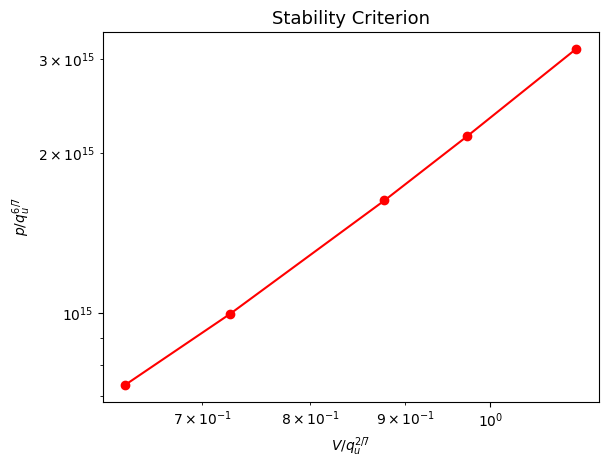

In [236]:
plt.loglog(x_parameter, y_parameter, color = 'r', marker = 'o')
#plt.loglog((y_parameter)**(3/2)/1e18, y_parameter, color = 'b', marker = 'o')
#plt.scatter(x_parameter[-2], y_parameter[-2], color='b', marker='x')
plt.title('Stability Criterion', fontsize=13)
plt.ylabel('$p/q_u^{6/7}$')
plt.xlabel('$V/q_u^{2/7}$')
plt.show()

In [ ]:
#6 Tt = 75, 1.5chi
np.savez(
    'parameters6.npz',
    T=Tt,
    x=x_parameter,
    y=y_parameter,
    stability=stability_pack,
    inst_x=instability_x,
    inst_y=instability_y,
    st_x=stability_x,
    st_y=stability_y,
)

In [ ]:
#7 Tt = 300, 1.5chi
np.savez(
    'parameters7.npz',
    T=Tt,
    x=x_parameter,
    y=y_parameter,
    stability=stability_pack,
    inst_x=instability_x,
    inst_y=instability_y,
    st_x=stability_x,
    st_y=stability_y,
)

In [ ]:
#8 Tt = 500, 1.5chi
np.savez(
    'parameters8.npz',
    T=Tt,
    x=x_parameter,
    y=y_parameter,
    stability=stability_pack,
    inst_x=instability_x,
    inst_y=instability_y,
    st_x=stability_x,
    st_y=stability_y,
)

In [102]:
#9 Tt = 75, 1.25chi
np.savez(
    'parameters9.npz',
    T=Tt,
    x=x_parameter,
    y=y_parameter,
    stability=stability_pack,
    inst_x=instability_x,
    inst_y=instability_y,
    st_x=stability_x,
    st_y=stability_y,
)

In [ ]:
#10 Tt = 300, 1.25chi
np.savez(
    'parameters10.npz',
    T=Tt,
    x=x_parameter,
    y=y_parameter,
    stability=stability_pack,
    inst_x=instability_x,
    inst_y=instability_y,
    st_x=stability_x,
    st_y=stability_y,
)

In [ ]:
#11 Tt = 500, 1.25chi
np.savez(
    'parameters11.npz',
    T=Tt,
    x=x_parameter,
    y=y_parameter,
    stability=stability_pack,
    inst_x=instability_x,
    inst_y=instability_y,
    st_x=stability_x,
    st_y=stability_y,
)

In [237]:
#12 Tt = 75, 1.125chi
np.savez(
    'parameters12.npz',
    T=Tt,
    x=x_parameter,
    y=y_parameter,
    stability=stability_pack,
    inst_x=instability_x,
    inst_y=instability_y,
    st_x=stability_x,
    st_y=stability_y,
)

In [245]:
#13 Tt = 300, 1.125chi
np.savez(
    'parameters13.npz',
    T=Tt,
    x=x_parameter,
    y=y_parameter,
    stability=stability_pack,
    inst_x=instability_x,
    inst_y=instability_y,
    st_x=stability_x,
    st_y=stability_y,
)

In [247]:
#14 Tt = 500, 1.125chi
np.savez(
    'parameters14.npz',
    T=Tt,
    x=x_parameter,
    y=y_parameter,
    stability=stability_pack,
    inst_x=instability_x,
    inst_y=instability_y,
    st_x=stability_x,
    st_y=stability_y,
)

In [239]:
#15 Tt = 75, 1.375chi
np.savez(
    'parameters15.npz',
    T=Tt,
    x=x_parameter,
    y=y_parameter,
    stability=stability_pack,
    inst_x=instability_x,
    inst_y=instability_y,
    st_x=stability_x,
    st_y=stability_y,
)

In [243]:
#16 Tt = 300, 1.375chi
np.savez(
    'parameters16.npz',
    T=Tt,
    x=x_parameter,
    y=y_parameter,
    stability=stability_pack,
    inst_x=instability_x,
    inst_y=instability_y,
    st_x=stability_x,
    st_y=stability_y,
)

In [249]:
#17 Tt = 500, 1.375chi
np.savez(
    'parameters17.npz',
    T=Tt,
    x=x_parameter,
    y=y_parameter,
    stability=stability_pack,
    inst_x=instability_x,
    inst_y=instability_y,
    st_x=stability_x,
    st_y=stability_y,
)

0.09362708545438712 0.10457029476904135 0.09913676563896345 0.09926041910497506 0.09893105538649367
0.09910941337681073


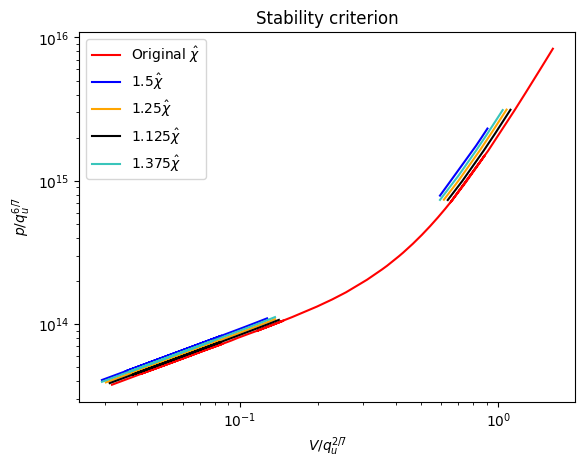

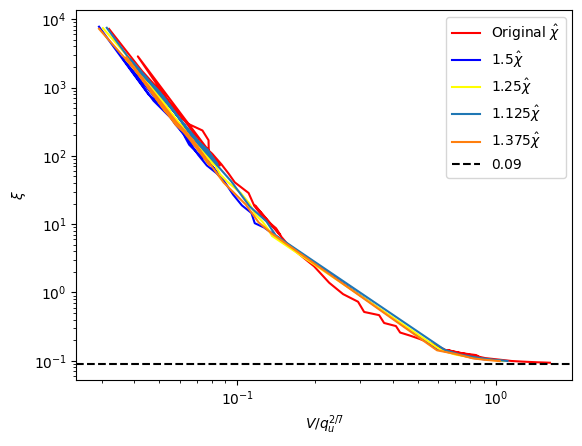

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data1 = np.load('parameters1.npz')
data2 = np.load('parameters2.npz')
data3 = np.load('parameters3.npz')
data4 = np.load('parameters4.npz')
data5 = np.load('parameters5.npz')
data6 = np.load('parameters6.npz')
data7 = np.load('parameters7.npz')
data8 = np.load('parameters8.npz')
data9 = np.load('parameters9.npz')
data10 = np.load('parameters10.npz')
data11 = np.load('parameters11.npz')
data12 = np.load('parameters12.npz')
data13 = np.load('parameters13.npz')
data14 = np.load('parameters14.npz')
data15 = np.load('parameters15.npz')
data16 = np.load('parameters16.npz')
data17 = np.load('parameters17.npz')
   
x_parameter1 = (np.concatenate((data2['x'], data4['x'], data3['x'], data5['x']), axis = 0))
y_parameter1 = (np.concatenate((data2['y'], data4['y'], data3['y'], data5['y']), axis = 0))

x_parameter2 = (np.concatenate((data8['x'], data7['x'], data6['x']), axis = 0))
x_parameter3 = (np.concatenate((data11['x'], data10['x'], data9['x']), axis = 0))
x_parameter4 = (np.concatenate((data14['x'], data13['x'], data12['x']), axis = 0))
x_parameter5 = (np.concatenate((data17['x'], data16['x'], data15['x']), axis = 0))

ksi_parameter1 = (np.concatenate((data2['stability'][3,:], data4['stability'][3,:], data3['stability'][3,:], data5['stability'][3,:]), axis = 0))
ksi_parameter2 = (np.concatenate((data8['stability'][3,:], data7['stability'][3,:], data6['stability'][3,:]), axis = 0))
ksi_parameter3 = (np.concatenate((data11['stability'][3,:], data10['stability'][3,:], data9['stability'][3,:]), axis = 0))
ksi_parameter4 = (np.concatenate((data14['stability'][3,:], data13['stability'][3,:], data12['stability'][3,:]), axis = 0))
ksi_parameter5 = (np.concatenate((data17['stability'][3,:], data16['stability'][3,:], data15['stability'][3,:]), axis = 0))


plt.figure()
plt.loglog(x_parameter1, y_parameter1, color = 'r', label = r'Original $\hat{\chi}$')
plt.loglog((np.concatenate((data8['x'], data7['x']), axis = 0)), (np.concatenate((data8['y'], data7['y']), axis = 0)), color = 'b', label = r'1.5$\hat{\chi}$')
plt.loglog(data6['x'], data6['y'], color = 'b')
plt.loglog((np.concatenate((data11['x'], data10['x']), axis = 0)), (np.concatenate((data11['y'], data10['y']), axis = 0)), color = 'orange', label = r'1.25$\hat{\chi}$')
plt.loglog(data9['x'], data9['y'], color = 'orange')
plt.loglog((np.concatenate((data14['x'], data13['x']), axis = 0)), (np.concatenate((data14['y'], data13['y']), axis = 0)), color = 'black', label = r'1.125$\hat{\chi}$')
plt.loglog(data12['x'], data12['y'], color = 'black')
plt.loglog((np.concatenate((data17['x'], data16['x']), axis = 0)), (np.concatenate((data17['y'], data16['y']), axis = 0)), color = '#39C5BB', label = r'1.375$\hat{\chi}$')
plt.loglog(data15['x'], data15['y'], color = '#39C5BB')

plt.title(f"Stability criterion")
plt.ylabel('$p/q_u^{6/7}$')
plt.xlabel('$V/q_u^{2/7}$')
plt.legend()

plt.figure()
plt.loglog(x_parameter1, ksi_parameter1, color = 'r', label = r'Original $\hat{\chi}$')
plt.loglog(x_parameter2, ksi_parameter2, color = 'b', label = r'1.5$\hat{\chi}$')
plt.loglog(x_parameter3, ksi_parameter3, color = 'yellow', label = r'1.25$\hat{\chi}$')
plt.loglog(x_parameter4, ksi_parameter4, label = r'1.125$\hat{\chi}$')
plt.loglog(x_parameter5, ksi_parameter5, label = r'1.375$\hat{\chi}$')
print(ksi_parameter1[-1], ksi_parameter2[-1], ksi_parameter3[-1], ksi_parameter4[-1], ksi_parameter5[-1])
print((ksi_parameter3[-1]+ksi_parameter4[-1]+ksi_parameter5[-1])/3)
plt.axhline(0.09, color = 'black', linestyle = '--', label = '0.09')
plt.legend()
plt.ylabel(r'$\xi$')
plt.xlabel('$V/q_u^{2/7}$')
plt.legend()

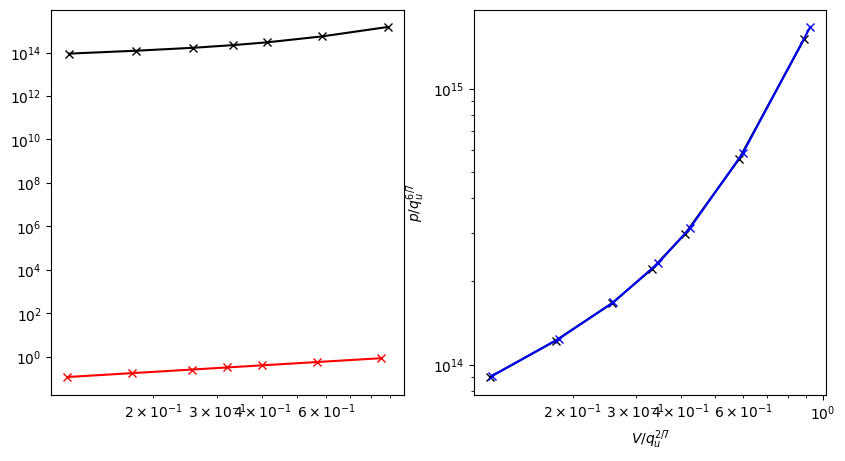

In [49]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.loglog(x_parameter[:], y_parameter[:], color='black', marker='x')
plt.loglog(stability_x[:], stability_y[:], color='r', marker='x')

plt.subplot(1, 2, 2)
plt.loglog(x_parameter[:], y_parameter[:], color='black', marker='x')
plt.loglog(instability_x[:], instability_y[:], color='b', marker='x')

#plt.scatter(x_parameter[5], y_parameter[5] * 1e18, color='b', marker='x')

#plt.title('Stability Criterion', fontsize=13)
plt.ylabel('$p/q_u^{6/7}$')
plt.xlabel('$V/q_u^{2/7}$')

plt.show()

In [129]:
import numpy as np

Lz = 50.0 # [m]
m = 1.67e-27# [kg] 
gamma_hat = 7.0 * np.sqrt(2/m)
e = 1.60218e-19 # [C]
epsilon0 = 8.8541878188e-12
me = 9.1093837015e-31
coulomb_log = 13
chi_hat = 9.6 * ((2 * np.pi)**(3/2) * epsilon0**2) / (me**(1/2) * e**(1/2) * coulomb_log) # [W/m eV^-7/2]
sigma_hat = 0.6125 * chi_hat

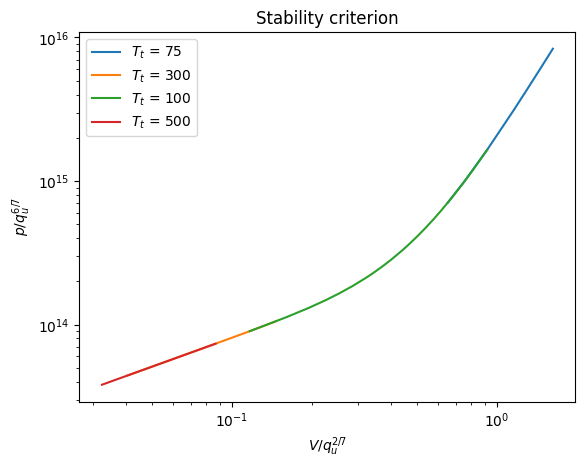

In [576]:
import numpy as np
import matplotlib.pyplot as plt

data1 = np.load('parameters1.npz') #200
data2 = np.load('parameters2.npz') #500
data3 = np.load('parameters3.npz') #100
data4 = np.load('parameters4.npz') #100
data5 = np.load('parameters5.npz') #100

Tt1 = data1['T']
x_parameter1 = data1['x']
y_parameter1 = data1['y']
Tt2 = data2['T']
x_parameter2 = data2['x']
y_parameter2 = data2['y']
Tt3 = data3['T']
x_parameter3 = data3['x']
y_parameter3 = data3['y']
Tt4 = data4['T']
x_parameter4 = data4['x']
y_parameter4 = data4['y']
Tt5 = data5['T']
x_parameter5 = data5['x']
y_parameter5 = data5['y']

Lz = 50.0 # [m]
m = 1.67e-27# [kg] 
gamma_hat = 7.0 * np.sqrt(2/m)
e = 1.60218e-19 # [C]
epsilon0 = 8.8541878188e-12
me = 9.1093837015e-31
coulomb_log = 13
chi_hat = 9.6 * ((2 * np.pi)**(3/2) * epsilon0**2) / (me**(1/2) * e**(1/2) * coulomb_log) # [W/m eV^-7/2]
sigma_hat = 0.6125 * chi_hat

plt.figure()

#plt.loglog(x_parameter1, y_parameter1, label = f'$T_t$ = {Tt1}')
plt.loglog(x_parameter5, y_parameter5, label = f'$T_t$ = {Tt5}')
plt.loglog(x_parameter4, y_parameter4, label = f'$T_t$ = {Tt4}')
plt.loglog(x_parameter3, y_parameter3, label = f'$T_t$ = {Tt3}')
plt.loglog(x_parameter2, y_parameter2, label = f'$T_t$ = {Tt2}')

plt.title(f"Stability criterion")
plt.ylabel('$p/q_u^{6/7}$')
plt.xlabel('$V/q_u^{2/7}$')
plt.legend()
plt.show()

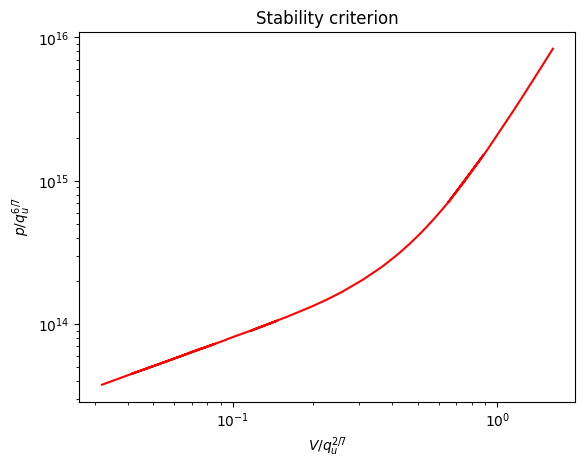

Text(0.5, 0, '$V/q_u^{2/7}$')

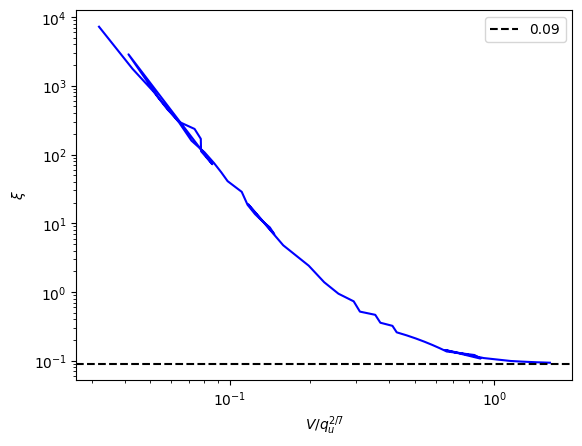

In [174]:
import numpy as np
import matplotlib.pyplot as plt

data1 = np.load('parameters1.npz') #200
data2 = np.load('parameters2.npz') #500
data3 = np.load('parameters3.npz') #100
data4 = np.load('parameters4.npz') #100
data5 = np.load('parameters5.npz') #100

x_parameter = (np.concatenate((data2['x'], data4['x'], data3['x'], data5['x']), axis = 0))
y_parameter = (np.concatenate((data2['y'], data4['y'], data3['y'], data5['y']), axis = 0))
ksi_parameter = (np.concatenate((data2['stability'][3,:], data4['stability'][3,:], data3['stability'][3,:], data5['stability'][3,:]), axis = 0))

plt.figure()
plt.loglog(x_parameter, y_parameter, color = 'r')

plt.title(f"Stability criterion")
plt.ylabel('$p/q_u^{6/7}$')
plt.xlabel('$V/q_u^{2/7}$')
plt.show()

plt.figure()
plt.loglog(x_parameter, ksi_parameter, color = 'b')
plt.axhline(0.09, color = 'black', linestyle = '--', label = '0.09')
plt.legend()
plt.ylabel(r'$\xi$')
plt.xlabel('$V/q_u^{2/7}$')

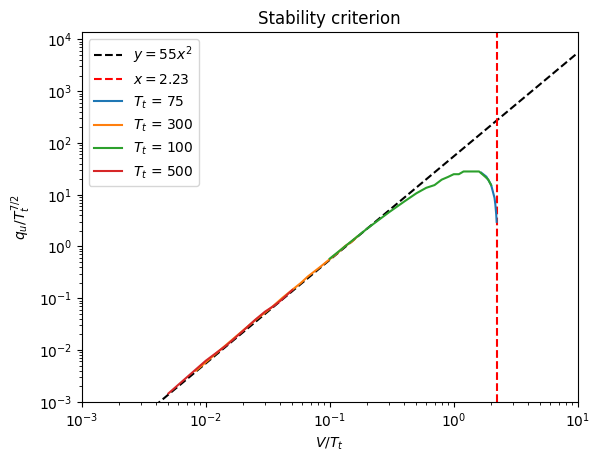

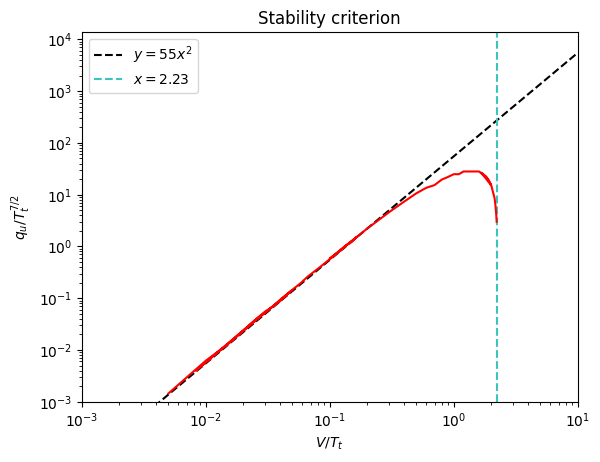

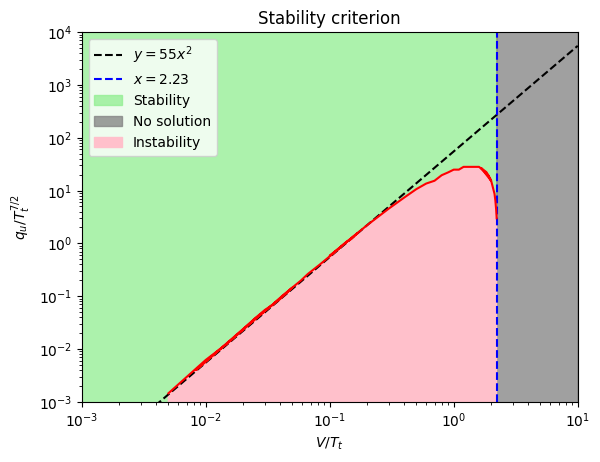

In [628]:
import numpy as np
import matplotlib.pyplot as plt

data1 = np.load('parameters1.npz') #200
data2 = np.load('parameters2.npz') #500
data3 = np.load('parameters3.npz') #100
data4 = np.load('parameters4.npz') #100
data5 = np.load('parameters5.npz') #100

Tt2 = data2['T']
x_parameter2 = data2['z']
y_parameter2 = data2['w']
Tt3 = data3['T']
x_parameter3 = data3['z']
y_parameter3 = data3['w']
Tt4 = data4['T']
x_parameter4 = data4['z']
y_parameter4 = data4['w']
Tt5 = data5['T']
x_parameter5 = data5['z']
y_parameter5 = data5['w']

Lz = 50.0 # [m]
m = 1.67e-27# [kg] 
gamma_hat = 7.0 * np.sqrt(2/m)
e = 1.60218e-19 # [C]
epsilon0 = 8.8541878188e-12
me = 9.1093837015e-31
coulomb_log = 13
chi_hat = 9.6 * ((2 * np.pi)**(3/2) * epsilon0**2) / (me**(1/2) * e**(1/2) * coulomb_log) # [W/m eV^-7/2]
sigma_hat = 0.6125 * chi_hat

ksi_parameter = (np.concatenate((data2['stability'][3,:], data4['stability'][3,:], data3['stability'][3,:], data5['stability'][3,:]), axis = 0))

plt.figure()
x_arr = np.logspace(-3, 1, 1000)
plt.loglog(x_arr, 55*x_arr**2, linestyle = '--', label = r'$y= 55x^2$', color = 'black')
plt.axvline(2.23, linestyle = '--', label = r'$x=2.23$', color = 'r')
#plt.loglog(x_parameter1, y_parameter1, label = f'$T_t$ = {Tt1}')
#plt.loglog((np.concatenate((data2['x'], data4['x'], data3['x'], data5['x']), axis = 0)), ksi_parameter, label = r'\xi')
plt.loglog(x_parameter5, y_parameter5, label = f'$T_t$ = {Tt5}')
plt.loglog(x_parameter4, y_parameter4, label = f'$T_t$ = {Tt4}')
plt.loglog(x_parameter3, y_parameter3, label = f'$T_t$ = {Tt3}')
plt.loglog(x_parameter2, y_parameter2, label = f'$T_t$ = {Tt2}')

plt.title(f"Stability criterion")
plt.ylabel('$q_u/T_t^{7/2}$')
plt.xlabel('$V/T_t$')
plt.xlim(1e-3, 1e1)
plt.ylim(1e-3,)
plt.legend()
plt.show()

plt.figure()
x_arr = np.logspace(-3, 1, 1000)
plt.loglog(x_arr, 55*x_arr**2, linestyle = '--', label = r'$y= 55x^2$', color = 'black')
plt.axvline(2.23, linestyle = '--', label = r'$x=2.23$', color = '#39C5BB')
plt.loglog((np.concatenate((data2['z'], data4['z'], data3['z'], data5['z']), axis = 0)), (np.concatenate((data2['w'], data4['w'], data3['w'], data5['w']), axis = 0)), color = 'r')
plt.title(f"Stability criterion")
plt.ylabel('$q_u/T_t^{7/2}$')
plt.xlabel('$V/T_t$')
plt.xlim(1e-3, 1e1)
plt.ylim(1e-3,)
plt.legend()
plt.show()

plt.figure()
x_arr = np.logspace(-3, 1, 1000)
plt.loglog(x_arr, 55*x_arr**2, linestyle = '--', label = r'$y= 55x^2$', color = 'black')
plt.axvline(2.23, linestyle = '--', label = r'$x=2.23$', color = 'blue')
z = (np.concatenate((data2['z'], data4['z'], data3['z'], data5['z']), axis = 0))
w = (np.concatenate((data2['w'], data4['w'], data3['w'], data5['w']), axis = 0))
plt.loglog(z, w, color = 'r')
plt.fill_between(np.linspace(1e-3, 2.23, 1000), 1e5, color = 'lightgreen', alpha = 0.75, label = 'Stability')
plt.fill_between(np.linspace(2.23, 10, 1000), 1e5, color = 'gray', alpha = 0.75, label = 'No solution')
plt.fill_between(z, w, where=(w > 0), color = 'pink', label = 'Instability')
plt.title(f"Stability criterion")
plt.ylabel('$q_u/T_t^{7/2}$')
plt.xlabel('$V/T_t$')
plt.xlim(1e-3, 1e1)
plt.ylim(1e-3, 1e4)
plt.legend()
plt.show()

In [623]:
print(1/0.09 * 5)

55.55555555555556


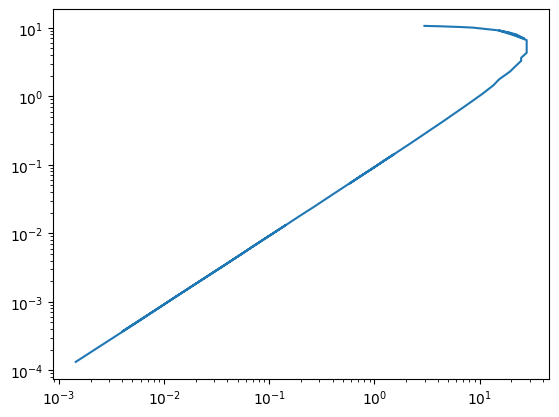

In [591]:
plt.loglog(np.concatenate((data2['w'], data4['w'], data3['w'], data5['w'])), 1/ksi_parameter)

## Fit for z-w:

Fit parameters: a = 50.64, b = 1.95, c = -0.00
R² = 0.9997
RMSD = 0.009218430030814972
CV(RMSD) = 2.4089519353824853 %
R² = 0.9995
RMSD = 0.012443104129580435
CV(RMSD) = 3.2516209023575575 %


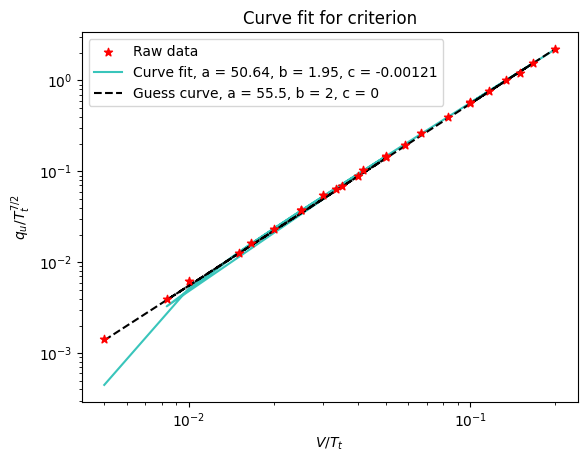

In [582]:
from scipy.optimize import curve_fit
def func(x, a, b, c):
    return a * x**b + c
    #return a * np.exp(x * b)

x_parameter = (np.concatenate((data2['z'], data4['z'], data3['z'][:2])))
y_parameter = (np.concatenate((data2['w'], data4['w'], data3['w'][:2])))

stability_pack = data5['stability']
instability_x = data5['inst_x']
instability_y = data5['inst_y']
stability_x = data5['st_x']
stability_y = data5['st_y']

guess = (50, 2, 0)
#guess = (1, 1, 1)
params, params_covariance = curve_fit(func, x_parameter, y_parameter, p0=guess, maxfev=int(1e9), ftol=1e-15, xtol=1e-15)

a_fit = 0
b_fit = 0
c_fit = 0

a_fit, b_fit, c_fit = params
print(f"Fit parameters: a = {a_fit:.2f}, b = {b_fit:.2f}, c = {c_fit:.2f}")

y_fit = func(x_parameter, a_fit, b_fit, c_fit)

residuals = y_parameter - y_fit
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y_parameter - np.mean(y_parameter))**2)
r_squared = 1 - (ss_res / ss_tot)
print(f"R² = {r_squared:.4f}")
plt.figure()
plt.scatter(x_parameter, y_parameter, label = 'Raw data', color = 'r', marker = '*', zorder=1000)
plt.loglog(x_parameter, y_fit, label = f'Curve fit, a = {a_fit:.2f}, b = {b_fit:.2f}, c = {c_fit:.5f}', color = '#39C5BB')
RMSD = np.sqrt(np.sum((y_parameter - y_fit)**2) / y_fit.size)
print(r'RMSD =',RMSD)
print('CV(RMSD) =', 100 * RMSD/np.mean(y_parameter), '%')

a_fit = 55.5
b_fit = 2
c_fit = 0
y_fit = func(x_parameter, a_fit, b_fit, c_fit)
residuals = y_parameter - y_fit
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y_parameter - np.mean(y_parameter))**2)
r_squared = 1 - (ss_res / ss_tot)
print(f"R² = {r_squared:.4f}")
RMSD = np.sqrt(np.sum((y_parameter - y_fit)**2) / y_fit.size)
print(r'RMSD =',RMSD)
print('CV(RMSD) =', 100 * RMSD/np.mean(y_parameter), '%')

#plt.loglog(x_parameter, func(x_parameter, 55, 2, 0), label = 'Guess curve', color = 'black', linestyle = '--')
plt.loglog(x_parameter, y_fit, label = f'Guess curve, a = {a_fit}, b = {b_fit}, c = {c_fit}', linestyle = '--', color = 'black')
plt.title(f"Curve fit for criterion")
plt.ylabel('$q_u/T_t^{7/2}$')
plt.xlabel('$V/T_t$')
plt.legend()
plt.show()

2.2200000000231674
Fit parameters: a = -0.51, b = 5.15, c = 33.67
R² = 0.9999
0.004087935094902031
0.00036252166506188136


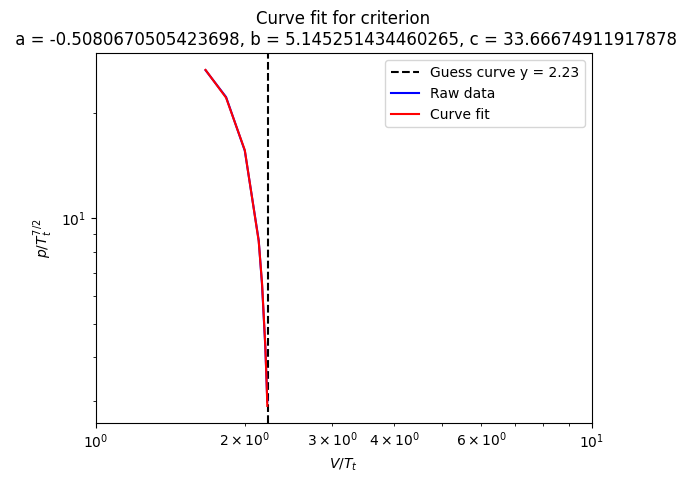

In [519]:
from scipy.optimize import curve_fit
def func(x, a, b, c):
    return a * x**b + c
    #return a * np.exp(x * b)

x_parameter = data5['z']
y_parameter = data5['w']
print(x_parameter[-1])

stability_pack = data5['stability']
instability_x = data5['inst_x']
instability_y = data5['inst_y']
stability_x = data5['st_x']
stability_y = data5['st_y']

guess = (1e18, 11/4, np.mean(y_parameter))
#guess = (1, 1, 1)
params, params_covariance = curve_fit(func, x_parameter, y_parameter, p0=guess, maxfev=int(1e9), ftol=1e-15, xtol=1e-15)

a_fit = 0
b_fit = 0
c_fit = 0

a_fit, b_fit, c_fit = params
print(f"Fit parameters: a = {a_fit:.2f}, b = {b_fit:.2f}, c = {c_fit:.2f}")
y_fit = func(x_parameter, a_fit, b_fit, c_fit)

residuals = y_parameter - y_fit
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y_parameter - np.mean(y_parameter))**2)
r_squared = 1 - (ss_res / ss_tot)
print(f"R² = {r_squared:.4f}")

MSD = np.mean((y_parameter - y_fit)**2)
print(MSD)
print(MSD/ np.mean(y_parameter))

guess_value = 2.23

plt.figure()
#plt.loglog(x_parameter, func(x_parameter, 50, 1.95, 0), label = 'Guess curve', color = 'black', linestyle = '--')
plt.axvline(guess_value, label = f'Guess curve y = {guess_value}', color = 'black', linestyle = '--')
plt.loglog(x_parameter, y_parameter, label = 'Raw data', color = 'b')
plt.loglog(x_parameter, y_fit, label = 'Curve fit', color = 'r')
plt.title(f"Curve fit for criterion\n a = {a_fit}, b = {b_fit}, c = {c_fit}")
plt.ylabel('$p/T_t^{7/2}$')
plt.xlabel('$V/T_t$')
plt.xlim(1e0, 1e1)
#plt.ylim(1e-3, 1e2)
plt.legend()
plt.show()

[125.   150.   160.   162.5  165.   165.25 165.5  165.75 166.   166.25
 166.5 ]
xi = [0.14302266 0.10946344 0.09929699 0.09716061 0.09497555 0.09477768
 0.09456804 0.09434743 0.09411659 0.09387625 0.09362709]


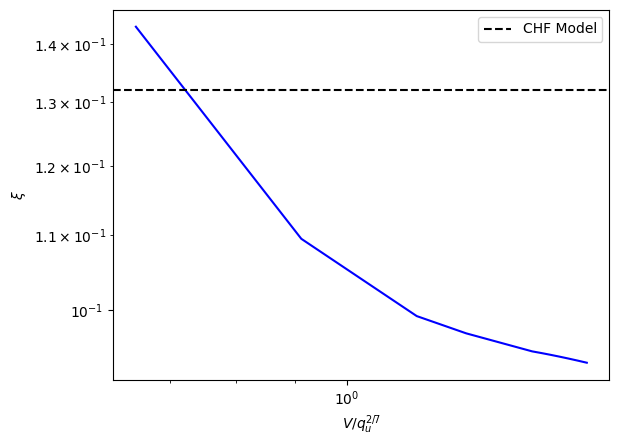

In [177]:
print(data5['stability'][0,:])
print('xi =', data5['stability'][3,:])


plt.figure()
plt.loglog(data5['x'], data5['stability'][3,:], color = 'b')
plt.axhline(0.132, color = 'black', linestyle = '--', label = 'CHF Model')
plt.ylabel(r'$\xi$')
plt.xlabel('$V/q_u^{2/7}$')
plt.legend()

## Low voltage regime

Fit parameters: a = 396532565722118.50, b = 0.71, c = 3132607696556.90
R² = 1.0000
RMSD = 78000031416.39009
CV(RMSD) = 0.1103462911385875 %


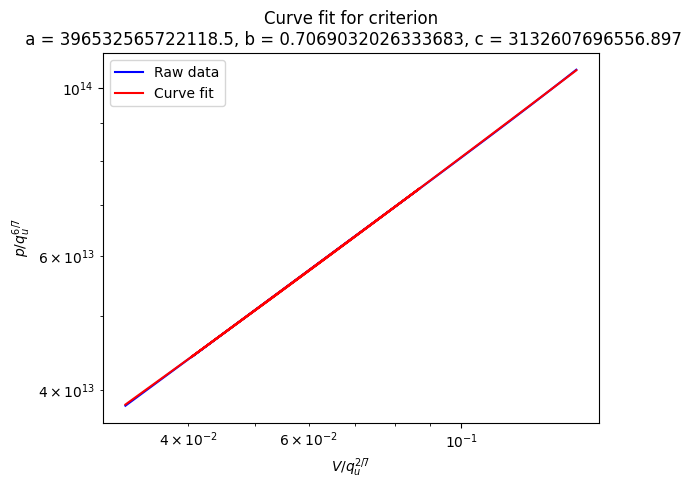

In [584]:
from scipy.optimize import curve_fit
def func(x, a, b, c):
    return a * x**b + c
    #return a * np.exp(x * b)

x_parameter = (np.concatenate((data2['x'], data4['x']), axis = 0))
y_parameter = (np.concatenate((data2['y'], data4['y']), axis = 0))

stability_pack = data5['stability']
instability_x = data5['inst_x']
instability_y = data5['inst_y']
stability_x = data5['st_x']
stability_y = data5['st_y']

guess = (1e18, 11/4, np.mean(y_parameter))
#guess = (1, 1, 1)
params, params_covariance = curve_fit(func, x_parameter, y_parameter, p0=guess, maxfev=int(1e9), ftol=1e-15, xtol=1e-15)

a_fit = 0
b_fit = 0
c_fit = 0

a_fit, b_fit, c_fit = params
print(f"Fit parameters: a = {a_fit:.2f}, b = {b_fit:.2f}, c = {c_fit:.2f}")
y_fit = func(x_parameter, a_fit, b_fit, c_fit)

residuals = y_parameter - y_fit
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y_parameter - np.mean(y_parameter))**2)
r_squared = 1 - (ss_res / ss_tot)
print(f"R² = {r_squared:.4f}")

RMSD = np.sqrt(np.sum((y_parameter - y_fit)**2) / y_fit.size)
print(r'RMSD =',RMSD)
print('CV(RMSD) =', 100 * RMSD/np.mean(y_parameter), '%')

plt.figure()
#plt.loglog(x_parameter, func(x_parameter, a_fit, 2.75, 0), label = 'Guess curve', color = 'black', linestyle = '--')
plt.loglog(x_parameter, y_parameter, label = 'Raw data', color = 'b')
plt.loglog(x_parameter, y_fit, label = 'Curve fit', color = 'r')
plt.title(f"Curve fit for criterion\n a = {a_fit}, b = {b_fit}, c = {c_fit}")
plt.ylabel('$p/q_u^{6/7}$')
plt.xlabel('$V/q_u^{2/7}$')
plt.legend()
plt.show()

Fit parameters: a = 412553269288358.31, b = 0.70, c = 2955663994612.85
R² = 1.0000
5.730682318024448e+21
84948968.00069371


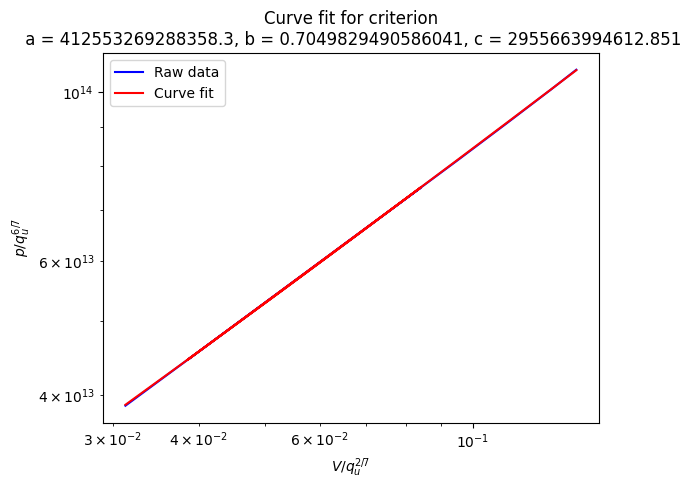

In [256]:
from scipy.optimize import curve_fit
def func(x, a, b, c):
    return a * x**b + c
    #return a * np.exp(x * b)

x_parameter = (np.concatenate((data14['x'], data13['x']), axis = 0))
y_parameter = (np.concatenate((data14['y'], data13['y']), axis = 0))

stability_pack = data5['stability']
instability_x = data5['inst_x']
instability_y = data5['inst_y']
stability_x = data5['st_x']
stability_y = data5['st_y']

guess = (1e18, 11/4, np.mean(y_parameter))
#guess = (1, 1, 1)
params, params_covariance = curve_fit(func, x_parameter, y_parameter, p0=guess, maxfev=int(1e9), ftol=1e-15, xtol=1e-15)

a_fit = 0
b_fit = 0
c_fit = 0

a_fit, b_fit, c_fit = params
print(f"Fit parameters: a = {a_fit:.2f}, b = {b_fit:.2f}, c = {c_fit:.2f}")
y_fit = func(x_parameter, a_fit, b_fit, c_fit)

residuals = y_parameter - y_fit
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y_parameter - np.mean(y_parameter))**2)
r_squared = 1 - (ss_res / ss_tot)
print(f"R² = {r_squared:.4f}")

MSD = np.mean((y_parameter - y_fit)**2)
print(MSD)
print(MSD/ np.mean(y_parameter))

plt.figure()
#plt.loglog(x_parameter, func(x_parameter, a_fit, 2.75, 0), label = 'Guess curve', color = 'black', linestyle = '--')
plt.loglog(x_parameter, y_parameter, label = 'Raw data', color = 'b')
plt.loglog(x_parameter, y_fit, label = 'Curve fit', color = 'r')
plt.title(f"Curve fit for criterion\n a = {a_fit}, b = {b_fit}, c = {c_fit}")
plt.ylabel('$p/q_u^{6/7}$')
plt.xlabel('$V/q_u^{2/7}$')
plt.legend()
plt.show()

Fit parameters: a = 427859205904201.38, b = 0.71, c = 3108325900761.90
R² = 1.0000
5.516877967568594e+21
75587493.18756437


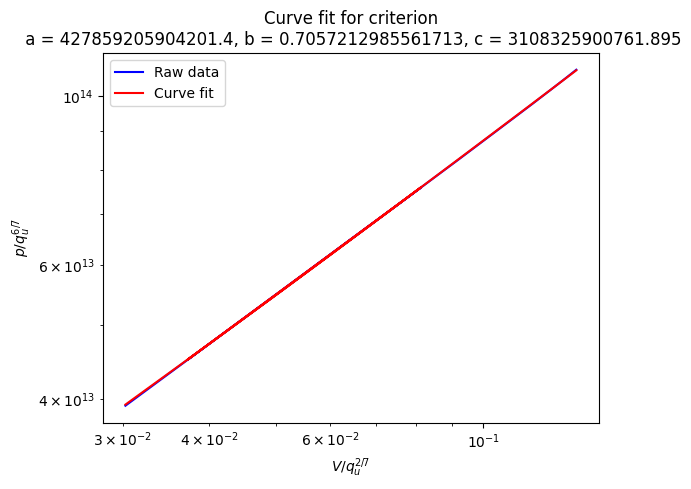

In [ ]:
from scipy.optimize import curve_fit
def func(x, a, b, c):
    return a * x**b + c
    #return a * np.exp(x * b)

x_parameter = (np.concatenate((data11['x'], data10['x']), axis = 0))
y_parameter = (np.concatenate((data11['y'], data10['y']), axis = 0))

stability_pack = data5['stability']
instability_x = data5['inst_x']
instability_y = data5['inst_y']
stability_x = data5['st_x']
stability_y = data5['st_y']

guess = (1e18, 11/4, np.mean(y_parameter))
#guess = (1, 1, 1)
params, params_covariance = curve_fit(func, x_parameter, y_parameter, p0=guess, maxfev=int(1e9), ftol=1e-15, xtol=1e-15)

a_fit = 0
b_fit = 0
c_fit = 0

a_fit, b_fit, c_fit = params
print(f"Fit parameters: a = {a_fit:.2f}, b = {b_fit:.2f}, c = {c_fit:.2f}")
y_fit = func(x_parameter, a_fit, b_fit, c_fit)

residuals = y_parameter - y_fit
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y_parameter - np.mean(y_parameter))**2)
r_squared = 1 - (ss_res / ss_tot)
print(f"R² = {r_squared:.4f}")

MSD = np.mean((y_parameter - y_fit)**2)
print(MSD)
print(MSD/ np.mean(y_parameter))

plt.figure()
#plt.loglog(x_parameter, func(x_parameter, a_fit, 2.75, 0), label = 'Guess curve', color = 'black', linestyle = '--')
plt.loglog(x_parameter, y_parameter, label = 'Raw data', color = 'b')
plt.loglog(x_parameter, y_fit, label = 'Curve fit', color = 'r')
plt.title(f"Curve fit for criterion\n a = {a_fit}, b = {b_fit}, c = {c_fit}")
plt.ylabel('$p/q_u^{6/7}$')
plt.xlabel('$V/q_u^{2/7}$')
plt.legend()
plt.show()

Fit parameters: a = 443433868173910.56, b = 0.71, c = 3232381582397.11
R² = 1.0000
8.167026156223921e+21
117431817.51662031


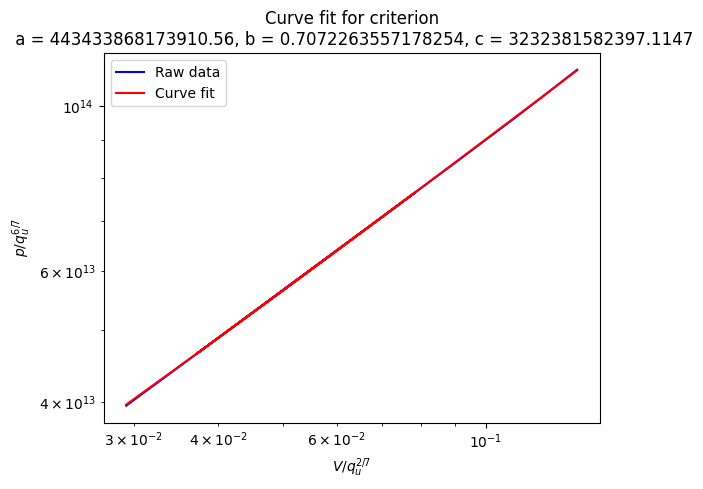

In [257]:
from scipy.optimize import curve_fit
def func(x, a, b, c):
    return a * x**b + c
    #return a * np.exp(x * b)

x_parameter = (np.concatenate((data17['x'], data16['x']), axis = 0))
y_parameter = (np.concatenate((data17['y'], data16['y']), axis = 0))

stability_pack = data5['stability']
instability_x = data5['inst_x']
instability_y = data5['inst_y']
stability_x = data5['st_x']
stability_y = data5['st_y']

guess = (1e18, 11/4, np.mean(y_parameter))
#guess = (1, 1, 1)
params, params_covariance = curve_fit(func, x_parameter, y_parameter, p0=guess, maxfev=int(1e9), ftol=1e-15, xtol=1e-15)

a_fit = 0
b_fit = 0
c_fit = 0

a_fit, b_fit, c_fit = params
print(f"Fit parameters: a = {a_fit:.2f}, b = {b_fit:.2f}, c = {c_fit:.2f}")
y_fit = func(x_parameter, a_fit, b_fit, c_fit)

residuals = y_parameter - y_fit
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y_parameter - np.mean(y_parameter))**2)
r_squared = 1 - (ss_res / ss_tot)
print(f"R² = {r_squared:.4f}")

MSD = np.mean((y_parameter - y_fit)**2)
print(MSD)
print(MSD/ np.mean(y_parameter))

plt.figure()
#plt.loglog(x_parameter, func(x_parameter, a_fit, 2.75, 0), label = 'Guess curve', color = 'black', linestyle = '--')
plt.loglog(x_parameter, y_parameter, label = 'Raw data', color = 'b')
plt.loglog(x_parameter, y_fit, label = 'Curve fit', color = 'r')
plt.title(f"Curve fit for criterion\n a = {a_fit}, b = {b_fit}, c = {c_fit}")
plt.ylabel('$p/q_u^{6/7}$')
plt.xlabel('$V/q_u^{2/7}$')
plt.legend()
plt.show()

Fit parameters: a = 454291599853256.56, b = 0.70, c = 3068306665404.10
R² = 1.0000
4.5175442271375416e+21
61304728.71548215


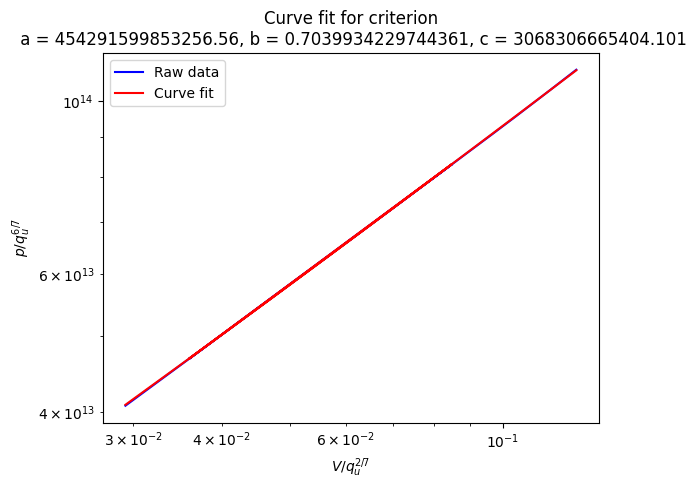

In [78]:
from scipy.optimize import curve_fit
def func(x, a, b, c):
    return a * x**b + c
    #return a * np.exp(x * b)

x_parameter = (np.concatenate((data8['x'], data7['x']), axis = 0))
y_parameter = (np.concatenate((data8['y'], data7['y']), axis = 0))

stability_pack = data5['stability']
instability_x = data5['inst_x']
instability_y = data5['inst_y']
stability_x = data5['st_x']
stability_y = data5['st_y']

guess = (1e18, 11/4, np.mean(y_parameter))
#guess = (1, 1, 1)
params, params_covariance = curve_fit(func, x_parameter, y_parameter, p0=guess, maxfev=int(1e9), ftol=1e-15, xtol=1e-15)

a_fit = 0
b_fit = 0
c_fit = 0

a_fit, b_fit, c_fit = params
print(f"Fit parameters: a = {a_fit:.2f}, b = {b_fit:.2f}, c = {c_fit:.2f}")
y_fit = func(x_parameter, a_fit, b_fit, c_fit)

residuals = y_parameter - y_fit
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y_parameter - np.mean(y_parameter))**2)
r_squared = 1 - (ss_res / ss_tot)
print(f"R² = {r_squared:.4f}")

MSD = np.mean((y_parameter - y_fit)**2)
print(MSD)
print(MSD/ np.mean(y_parameter))

plt.figure()
#plt.loglog(x_parameter, func(x_parameter, a_fit, 2.75, 0), label = 'Guess curve', color = 'black', linestyle = '--')
plt.loglog(x_parameter, y_parameter, label = 'Raw data', color = 'b')
plt.loglog(x_parameter, y_fit, label = 'Curve fit', color = 'r')
plt.title(f"Curve fit for criterion\n a = {a_fit}, b = {b_fit}, c = {c_fit}")
plt.ylabel('$p/q_u^{6/7}$')
plt.xlabel('$V/q_u^{2/7}$')
plt.legend()
plt.show()

(1.0, 1.1738988846274026)

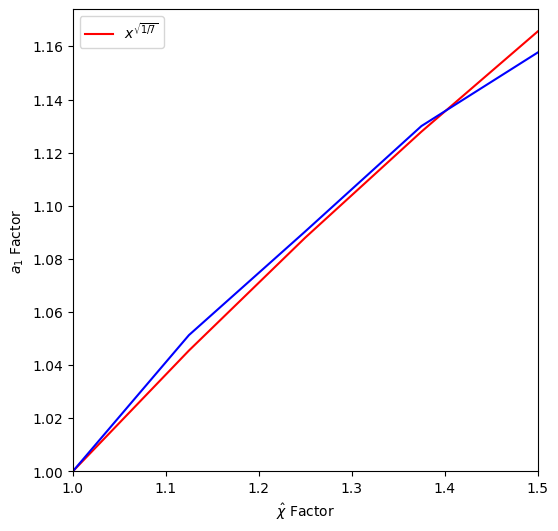

In [319]:
x_arr = np.array([1, 1.125, 1.25, 1.375, 1.5])
a1_arr = np.array([392410755382546.56, 412553269288358.31, 427859205904201.38, 443433868173910.56, 454291599853256.56])

plt.figure(figsize=(6,6))
plt.plot(x_arr, x_arr**np.sqrt(1/7), color = 'r', label = r'$x^\sqrt{1/7}$')
plt.plot(x_arr, a1_arr/a1_arr[0], color = 'b')
plt.xlabel('$\hat{\chi}$ Factor')
plt.ylabel('$a_1$ Factor')
plt.legend()
plt.xlim(1, 1.5)
plt.ylim(1,)

In [373]:
print(a1_arr/a1_arr[0])
print(x_arr**np.sqrt(1/7))

[1.         1.05133018 1.09033506 1.13002476 1.15769406]
[1.         1.04552359 1.08799911 1.12790756 1.16561799]


In [396]:
import numpy as np

def another_amazing_guess(sigma, chi):
    return (1e18 * np.sqrt(sigma * chi)/0.098 * 1e-7)

Lz = 50.0 # [m]
m = 1.67e-27# [kg] 
gamma_hat = 7.0 * np.sqrt(2/m)
e = 1.60218e-19 # [C]
epsilon0 = 8.8541878188e-12
me = 9.1093837015e-31
coulomb_log = 13
chi_hat = 9.6 * ((2 * np.pi)**(3/2) * epsilon0**2) / (me**(1/2) * e**(1/2) * coulomb_log) # [W/m eV^-7/2]
sigma_hat = 0.6125 * chi_hat

Guess_a = another_amazing_guess(sigma_hat, chi_hat)
print('Ratio =', Guess_a / a1_arr[0])
Guess_a = another_amazing_guess(sigma_hat*1.125, chi_hat*1.125)
print('Ratio =', Guess_a / a1_arr[1])
Guess_a = another_amazing_guess(sigma_hat*1.25, chi_hat*1.25)
print('Ratio =', Guess_a / a1_arr[2])
Guess_a = another_amazing_guess(sigma_hat*1.375, chi_hat*1.375)
print('Ratio =', Guess_a / a1_arr[3])
Guess_a = another_amazing_guess(sigma_hat*1.5, chi_hat*1.5)
print('Ratio =', Guess_a / a1_arr[4])

Ratio = 4.857144918607181
Ratio = 5.19749946116302
Ratio = 5.5684086032611235
Ratio = 5.91011323119717
Ratio = 6.293301176366047


## High V regime

Fit parameters: a = 1895306064168324.50, b = 3.01, c = 184672909359600.91
R² = 1.0000
RMSD = 402348128399.11383
CV(RMSD) = 0.009937072660686792 %


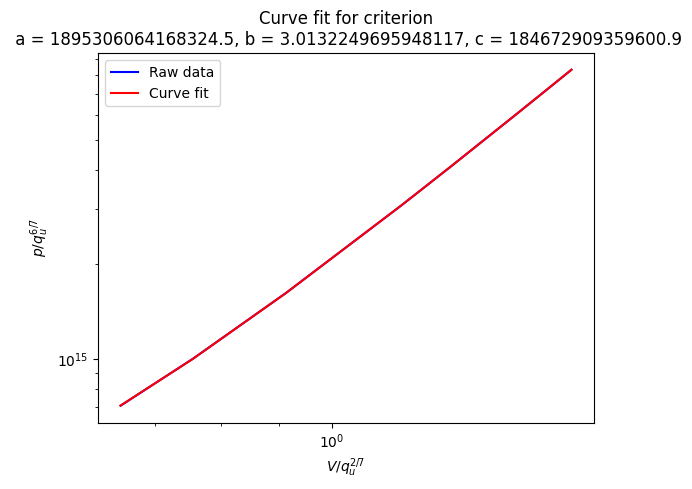

In [583]:
from scipy.optimize import curve_fit
def func(x, a, b, c):
    return a * x**b + c
    #return a * np.exp(x * b)

x_parameter = data5['x']
y_parameter = data5['y']


stability_pack = data5['stability']
instability_x = data5['inst_x']
instability_y = data5['inst_y']
stability_x = data5['st_x']
stability_y = data5['st_y']

guess = (1e18, 11/4, np.mean(y_parameter))
#guess = (1, 1, 1)
params, params_covariance = curve_fit(func, x_parameter, y_parameter, p0=guess, maxfev=int(1e9), ftol=1e-15, xtol=1e-15)

a_fit = 0
b_fit = 0
c_fit = 0

a_fit, b_fit, c_fit = params
print(f"Fit parameters: a = {a_fit:.2f}, b = {b_fit:.2f}, c = {c_fit:.2f}")
y_fit = func(x_parameter, a_fit, b_fit, c_fit)

residuals = y_parameter - y_fit
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y_parameter - np.mean(y_parameter))**2)
r_squared = 1 - (ss_res / ss_tot)
print(f"R² = {r_squared:.4f}")

RMSD = np.sqrt(np.sum((y_parameter - y_fit)**2) / y_fit.size)
print(r'RMSD =',RMSD)
print('CV(RMSD) =', 100 * RMSD/np.mean(y_parameter), '%')

plt.figure()
#plt.loglog(x_parameter, func(x_parameter, a_fit, 2.75, 0), label = 'Guess curve', color = 'black', linestyle = '--')
plt.loglog(x_parameter, y_parameter, label = 'Raw data', color = 'b')
plt.loglog(x_parameter, y_fit, label = 'Curve fit', color = 'r')
plt.title(f"Curve fit for criterion\n a = {a_fit}, b = {b_fit}, c = {c_fit}")
plt.ylabel('$p/q_u^{6/7}$')
plt.xlabel('$V/q_u^{2/7}$')
plt.legend()
plt.show()

Fit parameters: a = 2136902876965040.00, b = 3.01, c = 185803014021952.78
R² = 1.0000
1.0346212350255446e+23
59926575.05894586


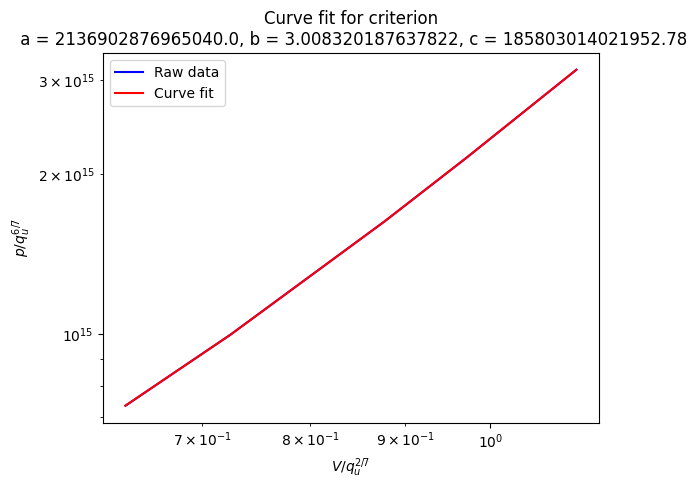

In [259]:
from scipy.optimize import curve_fit
def func(x, a, b, c):
    return a * x**b + c
    #return a * np.exp(x * b)

x_parameter = data12['x']
y_parameter = data12['y']


stability_pack = data5['stability']
instability_x = data5['inst_x']
instability_y = data5['inst_y']
stability_x = data5['st_x']
stability_y = data5['st_y']

guess = (1e18, 11/4, np.mean(y_parameter))
#guess = (1, 1, 1)
params, params_covariance = curve_fit(func, x_parameter, y_parameter, p0=guess, maxfev=int(1e9), ftol=1e-15, xtol=1e-15)

a_fit = 0
b_fit = 0
c_fit = 0

a_fit, b_fit, c_fit = params
print(f"Fit parameters: a = {a_fit:.2f}, b = {b_fit:.2f}, c = {c_fit:.2f}")
y_fit = func(x_parameter, a_fit, b_fit, c_fit)

residuals = y_parameter - y_fit
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y_parameter - np.mean(y_parameter))**2)
r_squared = 1 - (ss_res / ss_tot)
print(f"R² = {r_squared:.4f}")

MSD = np.mean((y_parameter - y_fit)**2)
print(MSD)
print(MSD/ np.mean(y_parameter))

plt.figure()
#plt.loglog(x_parameter, func(x_parameter, a_fit, 2.75, 0), label = 'Guess curve', color = 'black', linestyle = '--')
plt.loglog(x_parameter, y_parameter, label = 'Raw data', color = 'b')
plt.loglog(x_parameter, y_fit, label = 'Curve fit', color = 'r')
plt.title(f"Curve fit for criterion\n a = {a_fit}, b = {b_fit}, c = {c_fit}")
plt.ylabel('$p/q_u^{6/7}$')
plt.xlabel('$V/q_u^{2/7}$')
plt.legend()
plt.show()

Fit parameters: a = 2375162794009519.50, b = 3.01, c = 188391319969631.38
R² = 1.0000
1.1365276151862917e+23
65637644.66747935


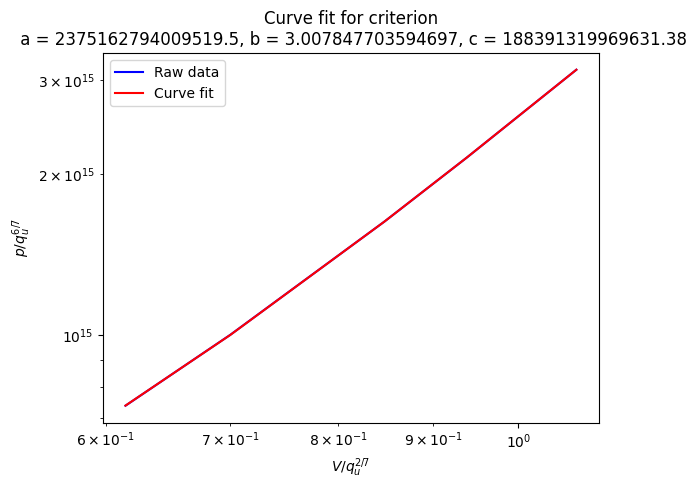

In [258]:
from scipy.optimize import curve_fit
def func(x, a, b, c):
    return a * x**b + c
    #return a * np.exp(x * b)

x_parameter = data9['x']
y_parameter = data9['y']


stability_pack = data5['stability']
instability_x = data5['inst_x']
instability_y = data5['inst_y']
stability_x = data5['st_x']
stability_y = data5['st_y']

guess = (1e18, 11/4, np.mean(y_parameter))
#guess = (1, 1, 1)
params, params_covariance = curve_fit(func, x_parameter, y_parameter, p0=guess, maxfev=int(1e9), ftol=1e-15, xtol=1e-15)

a_fit = 0
b_fit = 0
c_fit = 0

a_fit, b_fit, c_fit = params
print(f"Fit parameters: a = {a_fit:.2f}, b = {b_fit:.2f}, c = {c_fit:.2f}")
y_fit = func(x_parameter, a_fit, b_fit, c_fit)

residuals = y_parameter - y_fit
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y_parameter - np.mean(y_parameter))**2)
r_squared = 1 - (ss_res / ss_tot)
print(f"R² = {r_squared:.4f}")

MSD = np.mean((y_parameter - y_fit)**2)
print(MSD)
print(MSD/ np.mean(y_parameter))

plt.figure()
#plt.loglog(x_parameter, func(x_parameter, a_fit, 2.75, 0), label = 'Guess curve', color = 'black', linestyle = '--')
plt.loglog(x_parameter, y_parameter, label = 'Raw data', color = 'b')
plt.loglog(x_parameter, y_fit, label = 'Curve fit', color = 'r')
plt.title(f"Curve fit for criterion\n a = {a_fit}, b = {b_fit}, c = {c_fit}")
plt.ylabel('$p/q_u^{6/7}$')
plt.xlabel('$V/q_u^{2/7}$')
plt.legend()
plt.show()

Fit parameters: a = 2613863666204388.00, b = 3.01, c = 190335163283399.09
R² = 1.0000
1.2524555633266507e+23
72041309.40677297


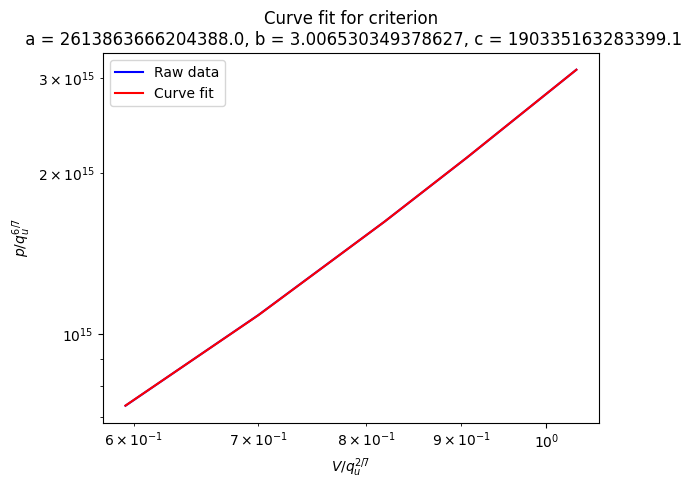

In [260]:
from scipy.optimize import curve_fit
def func(x, a, b, c):
    return a * x**b + c
    #return a * np.exp(x * b)

x_parameter = data15['x']
y_parameter = data15['y']


stability_pack = data5['stability']
instability_x = data5['inst_x']
instability_y = data5['inst_y']
stability_x = data5['st_x']
stability_y = data5['st_y']

guess = (1e18, 11/4, np.mean(y_parameter))
#guess = (1, 1, 1)
params, params_covariance = curve_fit(func, x_parameter, y_parameter, p0=guess, maxfev=int(1e9), ftol=1e-15, xtol=1e-15)

a_fit = 0
b_fit = 0
c_fit = 0

a_fit, b_fit, c_fit = params
print(f"Fit parameters: a = {a_fit:.2f}, b = {b_fit:.2f}, c = {c_fit:.2f}")
y_fit = func(x_parameter, a_fit, b_fit, c_fit)

residuals = y_parameter - y_fit
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y_parameter - np.mean(y_parameter))**2)
r_squared = 1 - (ss_res / ss_tot)
print(f"R² = {r_squared:.4f}")

MSD = np.mean((y_parameter - y_fit)**2)
print(MSD)
print(MSD/ np.mean(y_parameter))

plt.figure()
#plt.loglog(x_parameter, func(x_parameter, a_fit, 2.75, 0), label = 'Guess curve', color = 'black', linestyle = '--')
plt.loglog(x_parameter, y_parameter, label = 'Raw data', color = 'b')
plt.loglog(x_parameter, y_fit, label = 'Curve fit', color = 'r')
plt.title(f"Curve fit for criterion\n a = {a_fit}, b = {b_fit}, c = {c_fit}")
plt.ylabel('$p/q_u^{6/7}$')
plt.xlabel('$V/q_u^{2/7}$')
plt.legend()
plt.show()

Fit parameters: a = 2851450713522229.50, b = 3.00, c = 192303790109760.06
R² = 1.0000
1.0162112542885429e+21
591656.9816399788


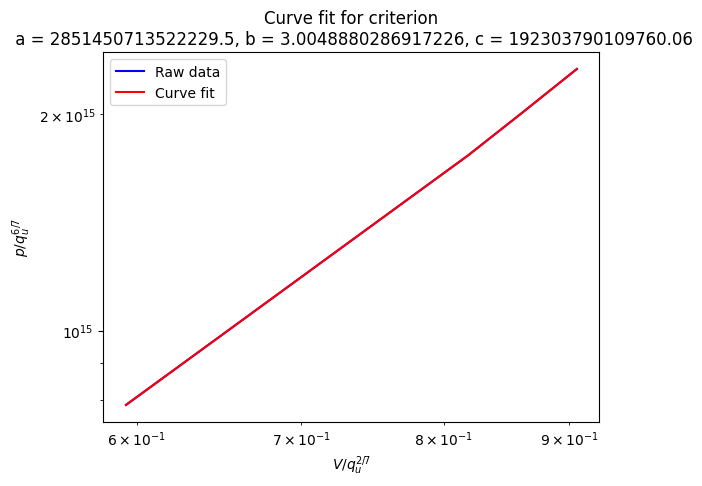

In [72]:
from scipy.optimize import curve_fit
def func(x, a, b, c):
    return a * x**b + c
    #return a * np.exp(x * b)

x_parameter = data6['x']
y_parameter = data6['y']


stability_pack = data5['stability']
instability_x = data5['inst_x']
instability_y = data5['inst_y']
stability_x = data5['st_x']
stability_y = data5['st_y']

guess = (1e18, 11/4, np.mean(y_parameter))
#guess = (1, 1, 1)
params, params_covariance = curve_fit(func, x_parameter, y_parameter, p0=guess, maxfev=int(1e9), ftol=1e-15, xtol=1e-15)

a_fit = 0
b_fit = 0
c_fit = 0

a_fit, b_fit, c_fit = params
print(f"Fit parameters: a = {a_fit:.2f}, b = {b_fit:.2f}, c = {c_fit:.2f}")
y_fit = func(x_parameter, a_fit, b_fit, c_fit)

residuals = y_parameter - y_fit
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y_parameter - np.mean(y_parameter))**2)
r_squared = 1 - (ss_res / ss_tot)
print(f"R² = {r_squared:.4f}")

MSD = np.mean((y_parameter - y_fit)**2)
print(MSD)
print(MSD/ np.mean(y_parameter))

plt.figure()
#plt.loglog(x_parameter, func(x_parameter, a_fit, 2.75, 0), label = 'Guess curve', color = 'black', linestyle = '--')
plt.loglog(x_parameter, y_parameter, label = 'Raw data', color = 'b')
plt.loglog(x_parameter, y_fit, label = 'Curve fit', color = 'r')
plt.title(f"Curve fit for criterion\n a = {a_fit}, b = {b_fit}, c = {c_fit}")
plt.ylabel('$p/q_u^{6/7}$')
plt.xlabel('$V/q_u^{2/7}$')
plt.legend()
plt.show()

(1.0, 1.5)

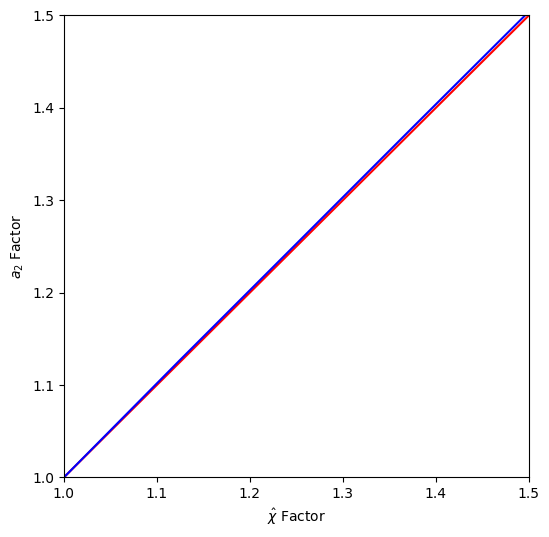

In [317]:
x_arr = np.array([1, 1.125, 1.25, 1.375, 1.5])
a2_arr = np.array([1895815606198673.75, 2136902876965040.00, 2375162794009519.50, 2613863666204388.00, 2851450713522229.50])

plt.figure(figsize=(6,6))
plt.plot(x_arr, x_arr, color = 'r', label = '$y=x$')
plt.plot(x_arr, a2_arr/a2_arr[0], color = 'b')
plt.xlabel('$\hat{\chi}$ Factor')
plt.ylabel('$a_2$ Factor')
plt.legend()
plt.xlim(1, 1.5)
plt.ylim(1, 1.5)


In [398]:
import numpy as np

def amazing_guess(sigma, chi):
    return 1e18 * np.sqrt(sigma * chi)/0.098 * 1e-7

Lz = 50.0 # [m]
m = 1.67e-27# [kg] 
gamma_hat = 7.0 * np.sqrt(2/m)
e = 1.60218e-19 # [C]
epsilon0 = 8.8541878188e-12
me = 9.1093837015e-31
coulomb_log = 13
chi_hat = 9.6 * ((2 * np.pi)**(3/2) * epsilon0**2) / (me**(1/2) * e**(1/2) * coulomb_log) # [W/m eV^-7/2]
sigma_hat = 0.6125 * chi_hat

Guess_a = amazing_guess(sigma_hat, chi_hat)
print(Guess_a)
print('Ratio =', Guess_a / a2_arr[0])
Guess_a = amazing_guess(sigma_hat*1.125, chi_hat*1.125)
print('Ratio =', Guess_a / a2_arr[1])
Guess_a = amazing_guess(sigma_hat*1.25, chi_hat*1.25)
print('Ratio =', Guess_a / a2_arr[2])
Guess_a = amazing_guess(sigma_hat*1.375, chi_hat*1.375)
print('Ratio =', Guess_a / a2_arr[3])
Guess_a = amazing_guess(sigma_hat*1.5, chi_hat*1.5)
print('Ratio =', Guess_a / a2_arr[4])

1905995906513141.5
Ratio = 1.0053698789487657
Ratio = 1.003436055958085
Ratio = 1.00308698382713
Ratio = 1.0026323887278994
Ratio = 1.0026453714285546


## Whole interval

Fit parameters: a = 1905995906513141.50, b = 3.00, c = 381199181302628.31, d = 0.70
R² = 0.9965
1.9585042531105704e+28
0.011573182304244662


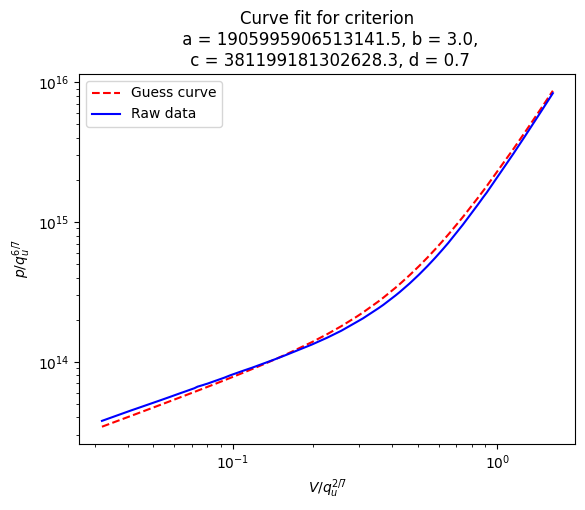

In [ ]:
from scipy.optimize import curve_fit
def func(x, a, b, c, d):
    return a * x**b + c * x**d
    #return a * np.exp(x * b)

x_parameter = np.sort(np.concatenate((data2['x'], data3['x'], data4['x'], data5['x']), axis = 0))
y_parameter = np.sort(np.concatenate((data2['y'], data3['y'], data4['y'], data5['y']), axis = 0))
#print(x_parameter, y_parameter)
stability_pack = data5['stability']
instability_x = data5['inst_x']
instability_y = data5['inst_y']
stability_x = data5['st_x']
stability_y = data5['st_y']

a_fit = 1905995906513141.5#1887324874117471.75
b_fit = 3.00
c_fit = a_fit/5
d_fit = 0.7 #11/16

print(f"Fit parameters: a = {a_fit:.2f}, b = {b_fit:.2f}, c = {c_fit:.2f}, d = {d_fit:.2f}")
y_fit = func(x_parameter, a_fit, b_fit, c_fit, d_fit)

residuals = y_parameter - y_fit
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y_parameter - np.mean(y_parameter))**2)
r_squared = 1 - (ss_res / ss_tot)
print(f"R² = {r_squared:.4f}")

MSD = np.mean((y_parameter - y_fit)**2)
print(MSD)
print(MSD/ np.mean(y_parameter)**2)

plt.figure()
plt.loglog(x_parameter, y_fit, label = 'Guess curve', color = 'r', linestyle = '--')
plt.loglog(x_parameter, y_parameter, label = 'Raw data', color = 'b')
#plt.loglog(x_parameter, y_fit, label = 'Curve fit', color = 'r')
plt.title(f"Curve fit for criterion\n a = {a_fit}, b = {b_fit},\n c = {c_fit}, d = {d_fit}")
plt.ylabel('$p/q_u^{6/7}$')
plt.xlabel('$V/q_u^{2/7}$')
plt.legend()
plt.show()

Fit parameters: a = 11.29, b = 1.20, c = -0.13, d = 0.00
R² = 0.9959
0.45847465001081955
0.005525854332320891


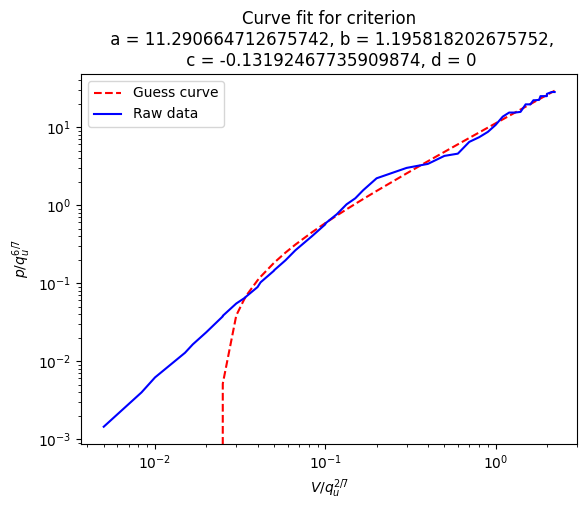

In [634]:
from scipy.optimize import curve_fit
def func(x, a, b, c):
    return a * x**b + c
    #return a * np.exp(x * b)

x_parameter = np.sort(np.concatenate((data2['z'], data3['z'], data4['z'], data5['z']), axis = 0))
y_parameter = np.sort(np.concatenate((data2['w'], data3['w'], data4['w'], data5['w']), axis = 0))
#print(x_parameter, y_parameter)
stability_pack = data5['stability']
instability_x = data5['inst_x']
instability_y = data5['inst_y']
stability_x = data5['st_x']
stability_y = data5['st_y']

guess = (50, 2, 0)
#guess = (1, 1, 1)
params, params_covariance = curve_fit(func, x_parameter, y_parameter, p0=guess, maxfev=int(1e9), ftol=1e-15, xtol=1e-15)

a_fit, b_fit, c_fit = params

print(f"Fit parameters: a = {a_fit:.2f}, b = {b_fit:.2f}, c = {c_fit:.2f}, d = {d_fit:.2f}")
y_fit = func(x_parameter, a_fit, b_fit, c_fit)

residuals = y_parameter - y_fit
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y_parameter - np.mean(y_parameter))**2)
r_squared = 1 - (ss_res / ss_tot)
print(f"R² = {r_squared:.4f}")

MSD = np.mean((y_parameter - y_fit)**2)
print(MSD)
print(MSD/ np.mean(y_parameter)**2)

plt.figure()
plt.loglog(x_parameter, y_fit, label = 'Guess curve', color = 'r', linestyle = '--')
plt.loglog(x_parameter, y_parameter, label = 'Raw data', color = 'b')
#plt.loglog(x_parameter, y_fit, label = 'Curve fit', color = 'r')
plt.title(f"Curve fit for criterion\n a = {a_fit}, b = {b_fit},\n c = {c_fit}, d = {d_fit}")
plt.ylabel('$p/q_u^{6/7}$')
plt.xlabel('$V/q_u^{2/7}$')
plt.legend()
plt.show()